# Check if is executing on Google Colab
If running on google colab download the repositories

In [2]:
try:
  import google.colab
  !git clone --recursive https://github.com/migperfer/AMPL-UPF-MSC
  IN_COLAB = True
except:
  IN_COLAB = False

# Import libraries

In [3]:
from music21 import *
from music21.note import Note as noteclass
from music21.chord import Chord as chordclass
from music21.meter import TimeSignature as tsclass
import os, glob, math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Creation of Usul related objects
## Definition of the UsulStroke and Usul classes

In [4]:
class UsulStroke:
  def __init__(self, mnote, stroke, barduration):    
    self.stroketype = stroke.content
    self.duration = mnote.duration.quarterLength
    self.offset = mnote.beat
    self.barduration = barduration
    self.compatoffset = float(str(float((mnote.beat - 1)/barduration))[:4])
    if isinstance(mnote, chordclass):
      self.hand = "both"
    elif mnote.pitch.name == "F":
      self.hand = "right"
    elif mnote.pitch.name == "D":
      self.hand = "left"
    else:
      self.hand = "unknown"

  def __repr__(self):
    return "UsulStroke"

  def __str__(self):
    return "Stroke:%s, Duration:%s, Hand:%s, Offset:%s" % (self.stroketype, self.duration, self.hand, self.compatoffset)

class Usul:
  def __init__(self, usulname, strokes, nbeats):
    self.nbeats = nbeats
    self.usul = usulname
    self.strokes = strokes

  @classmethod
  def usul_from_file(cls, file):
    nbeats = 0
    score = converter.parse(file)
    rhythm = score.getElementsByClass('Part')[0].getElementsByClass('Measure')[0]
    notes = []
    for element in rhythm:
      if isinstance(element, (noteclass, chordclass)):
        notes.append(element)
      if isinstance(element, (tsclass)):
        nbeats = element.beatCount
        
    strokes = rhythm.getElementsByClass('TextExpression')
    usul_name = file.split('/')[-1].split('.mxl')[0].lower().replace('_', ' ')
    strokes_list = []
    for note in range(len(notes)):
      strk = UsulStroke(notes[note], strokes[note], nbeats)
      strokes_list.append(strk)
    return cls(usul_name, strokes_list, nbeats)


  def __iter__(self):
    self.index = 0
    return self

  def __getitem__(self, idx):
        return self.strokes[idx]

  def __next__(self):
    if self.index < len(self.strokes):
      idx = self.index
      self.index += 1
      return self.strokes[idx]
    else:
      raise StopIteration

  def _repr__(self):
    return "Usul"
  
  def __str__(self):
    return "Usul Object: %s" % (self.usul)

## Load all existing usuls with the classes created in last cell

We load all the usuls possible (the ones for which we have the scores), into the *usul_dict* dictionary

In [5]:
if IN_COLAB:
    usuls_files_list = glob.glob('./AMPL-UPF-MSC/scores/mxl/*.mxl')
else:
    usuls_files_list = glob.glob('./scores/mxl/*.mxl')

usuls_dict = {}
for usul_file in usuls_files_list:
  usul_name = usul_file.split('/')[-1].split('.mxl')[0].lower().replace('_', ' ')
  if '\\' in usul_name:  # Windows use \ instead of /
        usul_name = usul_name.split('\\')[-1]
  usuls_dict[usul_name] = Usul.usul_from_file(usul_file)

## Load define makams functions

In [7]:
usuldict = {'sofyan':0,'duyek':1,'raksaksagi':2,'cenber':3,'hafif':4,'devrikebir':5,'muhammes':6,'turkaksagi':7,'oynak':8,'havi':9,'aksak':10,'yuruksemai':11,'berefsan':12,'aksaksemai':13,'fahte':14,'semai':15,'cifteduyek':16,'evfer':17}
makamlist = ['hicaz','rast','nihavent','ussak','segah','huseyni','huzzam','mahur','kurdilihicazkar','muhayyer']
makamdict = {makamlist[i]:i for i in range(len(makamlist))}

rast = {'G': 1, 'A': 2, 'B':3,'C':4,'D':5,'E':6,'F':7,'Dom':['D5'],'Lead':['F4#4','G4b5'],'Tonic':'G4'}
huseyni = {'A': 1, 'B':2,'C':3,'D':4,'E':5,'F':6, 'G':7,'Dom':['E5'],'Lead':['G4'],'Tonic':'A4'}
muhayyer = {'A': 1, 'B':2,'C':3,'D':4,'E':5,'F':6, 'G':7,'Dom':['A5','E5'],'Lead':['G4'],'Tonic':'A4'}
ussak = {'A': 1, 'B':2,'C':3,'D':4,'E':5,'F':6, 'G':7,'Dom':['D5'],'Lead':['G4'],'Tonic':'A4'}
hicaz = {'A': 1, 'B':2,'C':3,'D':4,'E':5,'F':6, 'G':7,'Dom':['D5'],'Lead':['G4'],'Tonic':'A4'}
huzzam = {'B':1,'C':2,'D':3,'E':4,'F':5, 'G':6,'A':7,'Dom':['D5'],'Lead':['A4#4','B4b5'],'Tonic':'B4b1'}
kurdilihicazkar = {'G': 1, 'A': 2, 'B':3,'C':4,'D':5,'E':6,'F':7,'Dom':['G5','C5'],'Lead':['F4'],'Tonic':'G4'} 
nihavent = {'G': 1, 'A': 2, 'B':3,'C':4,'D':5,'E':6,'F':7,'Dom':['D5'],'Lead':['F4#4','G4b5'],'Tonic':'G4'}
segah = {'B':1,'C':2,'D':3,'E':4,'F':5, 'G':6,'A':7,'Dom':['D5'],'Lead':['A4#4','B4b5'],'Tonic':'B4b1'}
mahur = {'G': 1, 'A': 2, 'B':3,'C':4,'D':5,'E':6,'F':7,'Dom':['G5','D5'],'Lead':['F4#5','G4b4'],'Tonic':'G4'}

if IN_COLAB:
    folder = 'AMPL-UPF-MSC/SymbTr/txt/'
else:
    folder = 'SymbTr/txt/'

allScores = os.listdir(folder)

def getDegree(note,makam):
    significance = None
    degree = eval(makam)[note[0]]
    if note == eval(makam)['Tonic']:
        significance = 'Tonic'
    if note in eval(makam)['Dom']:
        significance = 'Dominant'
    if note in eval(makam)['Lead']:
        significance = 'Leading'    
    return degree,significance

def getbars(makam,usul):
    bars = []
    bar = []
    nPieces = 0 # how many pieces are there for these makam&usul?

    for file in allScores:
        mak,_,us = file.split('--')[:3]
        
        if (mak != makam) or (us != usul):
            continue
        
        with open(folder + file, encoding="utf8") as scoretxt:
            txtlines = scoretxt.read().split('\n')
        for i in range(2,len(txtlines)-1):
            if int(txtlines[i].split('\t')[1])==51: # possible usul change, leave the rest
                break
            if int(txtlines[i].split('\t')[6])>0:
                dur = int(txtlines[i].split('\t')[6])/int(txtlines[i].split('\t')[7])
                notename = txtlines[i].split('\t')[3]
                degree, significance = getDegree(notename,mak)
                offset = txtlines[i].split('\t')[-1]     
                bar.append([offset,dur,notename,degree,significance])
                if float(offset).is_integer():
                    bars.append(bar)
                    bar = []
        nPieces += 1

    return bars, nPieces

## Function to analyze a makam using an usul object

In [8]:
def analyze_makam(makam_name, usul_name):
    usul_part = usul_name.replace("ü", "u").replace(" ", "").replace("ç","c").replace("ğ","g").replace("ş","s").replace("-","")
    makam_part = makamdict[makam_name]
    makam, nPieces = getbars(makam_name, usul_part)
    if makam == []:
      raise ValueError("Can't load makam %s-%s" % (makam_name, usul_part))
    usul = usuls_dict[usul_name]
    coincidences = []
    not_coincide = []
    usul_onsets = []
    for stroke in usul:
        usul_onsets.append(stroke.compatoffset)  # Get the position of every stroke in this
    onsets_indx = dict((k,i) for i,k in enumerate(usul_onsets))  # Store the index of every beat position

    notes_total = 0
    notes_coinc = 0  # to see how many notes coincide 

    for bar in makam:
        for note in bar:
            beat, bar = math.modf(float(note[0]))  # Split the integer part and the decimal one
            beat = beat # Substract the duration, to get the beat position
            beat = float(str(beat)[:4])  # Limit to 4 the number of decimals

            notes_total += 1
            if beat in usul_onsets:
                notes_coinc += 1
                coinc_stroke = usul[onsets_indx[beat]]  # Get coincident stroke
                coincidence = {'hand': coinc_stroke.hand, 'duration': coinc_stroke.duration, 'stroke': coinc_stroke.stroketype, 'offset':coinc_stroke.compatoffset,
                               'note_name': note[2], 'note_degree': note[3], 'note_significance': note[4], 'makam': makam_name, 'usul': usul_name}
                coincidences.append(coincidence)
            
            else:
                not_coincide.append({'note_name': note[2], 'note_degree': note[3], 'note_significance': note[4], 'makam': makam_name, 'usul': usul_name})
    coincidences = pd.DataFrame(coincidences)
    percentage = notes_coinc/notes_total
    return coincidences, percentage, nPieces, not_coincide
            

## Analyze the scores
Analyze the scores and save them into a folder called _csv-data_

In [9]:
if not os.path.isdir('csv-data/'):
  os.mkdir('csv-data/')
import gc
empty_ones = []
broken_ones = []
for usul_key in usuls_dict.keys():
  for makam_key in makamdict.keys():
    print("Analizing %s-%s" % (usul_key, makam_key))
    try:
      results, percentage, nPieces, not_coincide = analyze_makam(makam_key, usul_key)
    except ValueError:
      print("\tBroken %s, %s" % (makam_key, usul_key))
      broken_ones.append("%s, %s" % (makam_key, usul_key))
      continue
    if not results.empty:
      results.to_csv('csv-data/%s-%s.csv' % (usul_key, makam_key))
      print("\tAnalyzed %s-%s" % (usul_key, makam_key))
    else:
      print("\tEmpty: ", usul_key, makam_key)
      empty_ones.append("%s-%s" % (usul_key, makam_key))
  gc.collect()
with open('csv-data/empty_ones.txt', 'w', encoding="utf8") as file:
  for empty in empty_ones:
    file.write("%s\n" % empty)
with open('csv-data/broken_ones.txt', 'w', encoding="utf8") as file:
  for broken in broken_ones:
    file.write("%s\n" % broken)

Analizing raks aksaği-hicaz
	Analyzed raks aksaği-hicaz
Analizing raks aksaği-rast
	Broken rast, raks aksaği
Analizing raks aksaği-nihavent
	Broken nihavent, raks aksaği
Analizing raks aksaği-ussak
	Analyzed raks aksaği-ussak
Analizing raks aksaği-segah
	Analyzed raks aksaği-segah
Analizing raks aksaği-huseyni
	Analyzed raks aksaği-huseyni
Analizing raks aksaği-huzzam
	Broken huzzam, raks aksaği
Analizing raks aksaği-mahur
	Broken mahur, raks aksaği
Analizing raks aksaği-kurdilihicazkar
	Broken kurdilihicazkar, raks aksaği
Analizing raks aksaği-muhayyer
	Analyzed raks aksaği-muhayyer
Analizing sofyan-hicaz
	Analyzed sofyan-hicaz
Analizing sofyan-rast
	Analyzed sofyan-rast
Analizing sofyan-nihavent
	Analyzed sofyan-nihavent
Analizing sofyan-ussak
	Analyzed sofyan-ussak
Analizing sofyan-segah
	Analyzed sofyan-segah
Analizing sofyan-huseyni
	Analyzed sofyan-huseyni
Analizing sofyan-huzzam
	Analyzed sofyan-huzzam
Analizing sofyan-mahur
	Analyzed sofyan-mahur
Analizing sofyan-kurdilihicazka

	Analyzed evfer-kurdilihicazkar
Analizing evfer-muhayyer
	Broken muhayyer, evfer
Analizing türk aksaği-hicaz
	Analyzed türk aksaği-hicaz
Analizing türk aksaği-rast
	Analyzed türk aksaği-rast
Analizing türk aksaği-nihavent
	Analyzed türk aksaği-nihavent
Analizing türk aksaği-ussak
	Analyzed türk aksaği-ussak
Analizing türk aksaği-segah
	Analyzed türk aksaği-segah
Analizing türk aksaği-huseyni
	Analyzed türk aksaği-huseyni
Analizing türk aksaği-huzzam
	Analyzed türk aksaği-huzzam
Analizing türk aksaği-mahur
	Broken mahur, türk aksaği
Analizing türk aksaği-kurdilihicazkar
	Analyzed türk aksaği-kurdilihicazkar
Analizing türk aksaği-muhayyer
	Analyzed türk aksaği-muhayyer


# Analyse the data

In [10]:
all_files = glob.glob("csv-data/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, header=0, index_col=0)
    li.append(df)

frame = pd.concat(li, axis=0)
frame.head()

,hand,duration,stroke,offset,note_name,note_degree,note_significance,makam,usul
0,right,0.5,Te,0.2,G4,7,Leading,hicaz,aksak semai
1,left,1.0,Ka,0.3,A4,1,Tonic,hicaz,aksak semai
2,right,1.0,Düm,0.5,G4,7,Leading,hicaz,aksak semai
3,left,1.0,Tek,0.7,G4,7,Leading,hicaz,aksak semai
4,left,0.5,Tek,0.9,D5,4,Dominant,hicaz,aksak semai


## Overall note significance


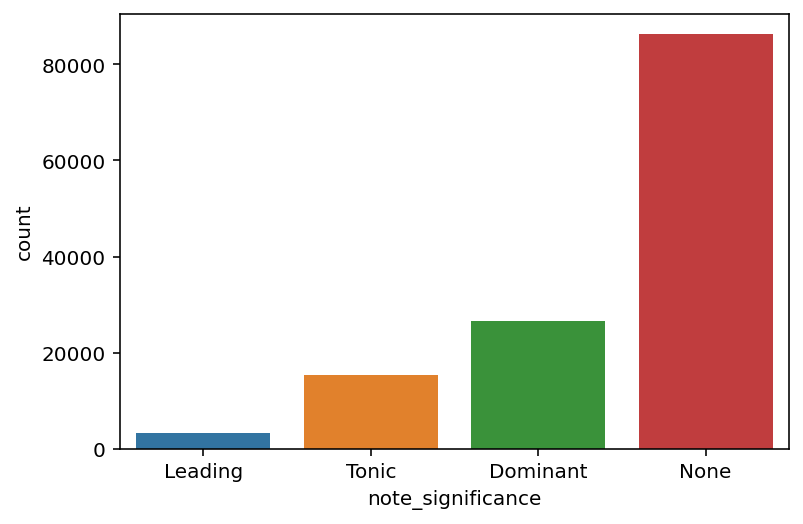

In [12]:
sns.countplot(frame['note_significance'].fillna("None"))
plt.show()

## Offset of the notes


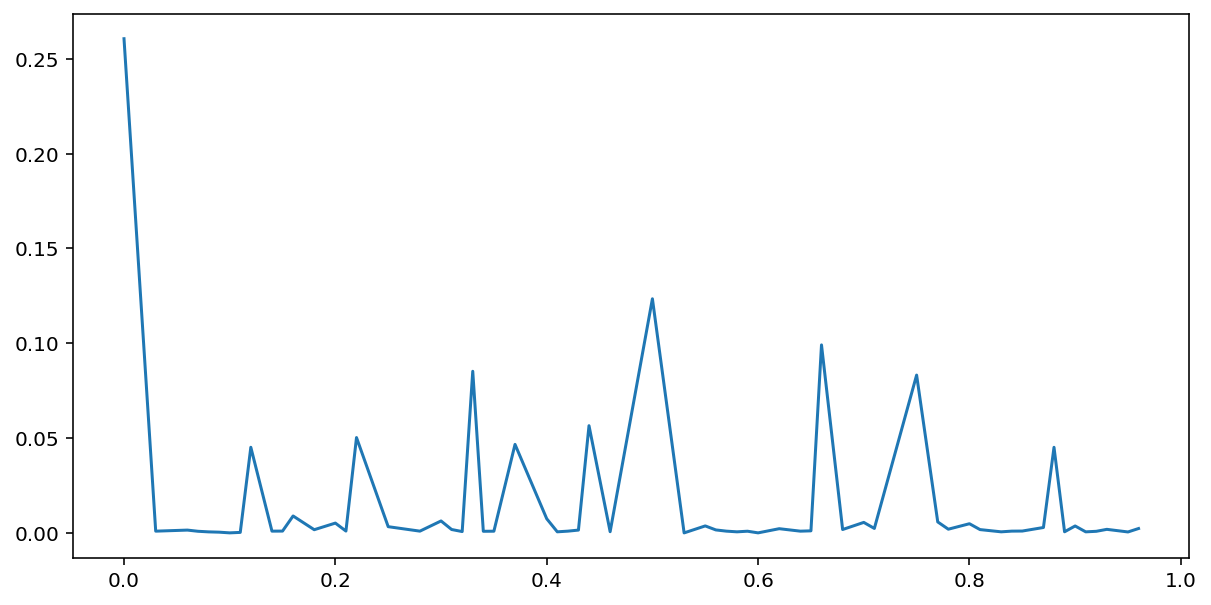

In [19]:
fig = plt.figure(figsize = (10,5))
ax = fig.gca()
sns.lineplot(data=frame.offset.value_counts().sort_index()/len(frame), ax=ax)
plt.show()

## Note significance according to hand


In [20]:
both_hands = frame[frame['hand'] == 'both']
both_hands.groupby(by=['hand', 'note_significance']).count()/len(both_hands)*10

duration   stroke   offset  note_name  note_degree  \
hand note_significance                                                       
both Dominant            1.18750  1.18750  1.18750    1.18750      1.18750   
     Leading             0.15625  0.15625  0.15625    0.15625      0.15625   
     Tonic               1.18750  1.18750  1.18750    1.18750      1.18750   

                          makam     usul  
hand note_significance                    
both Dominant           1.18750  1.18750  
     Leading            0.15625  0.15625  
     Tonic              1.18750  1.18750

In [21]:
right_hands = frame[frame['hand'] == 'right']
right_hands.groupby(by=['hand', 'note_significance']).count()/len(right_hands)*100

duration     stroke     offset  note_name  \
hand  note_significance                                               
right Dominant           20.557184  20.557184  20.557184  20.557184   
      Leading             2.828605   2.828605   2.828605   2.828605   
      Tonic              12.660425  12.660425  12.660425  12.660425   

                         note_degree      makam       usul  
hand  note_significance                                     
right Dominant             20.557184  20.557184  20.557184  
      Leading               2.828605   2.828605   2.828605  
      Tonic                12.660425  12.660425  12.660425

In [22]:
left_hands = frame[frame['hand'] == 'left']
left_hands.groupby(by=['hand', 'note_significance']).count()/len(left_hands)*100

duration     stroke     offset  note_name  \
hand note_significance                                               
left Dominant           19.959661  19.959661  19.959661  19.959661   
     Leading             2.159618   2.159618   2.159618   2.159618   
     Tonic              10.552121  10.552121  10.552121  10.552121   

                        note_degree      makam       usul  
hand note_significance                                     
left Dominant             19.959661  19.959661  19.959661  
     Leading               2.159618   2.159618   2.159618  
     Tonic                10.552121  10.552121  10.552121

## Note significance according to stroke type

In [23]:
d1 = frame.groupby(['note_significance', 'stroke']).agg({'duration': 'sum'})
d1.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

duration
note_significance stroke           
Dominant          Dum      9.324067
                  Düm     38.024069
                  Hek      0.311622
                  Ka       0.631445
                  Ke       7.083256
                  Ta       0.582242
                  Te       9.953462
                  Tek     34.089837
Leading           Dum      7.632277
                  Düm     42.968628
                  Hek      0.312159
                  Ka       0.749181
                  Ke       6.758233
                  Ta       0.437022
                  Te      11.596691
                  Tek     29.545809
Tonic             Dum      8.030814
                  Düm     45.386372
                  Hek      0.518117
                  Ka       0.531752
                  Ke       8.497801
                  Ta       0.490848
                  Te       8.456897
                  Tek     28.087398

## Note significance according to note duration

In [24]:
d1 = frame.groupby(['note_significance', 'duration']).agg({'duration': 'sum'})
d1.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

duration
note_significance duration           
Dominant          0.5       17.969535
                  1.0       64.714927
                  1.5        0.528938
                  2.0       16.409373
                  4.0        0.377227
Leading           0.5       12.626814
                  1.0       68.706103
                  1.5        0.374590
                  2.0       18.167629
                  4.0        0.124863
Tonic             0.5       16.167297
                  1.0       61.137812
                  1.5        0.429492
                  2.0       21.856359
                  4.0        0.409040

## Stroke distribution according to hand

In [25]:
d1 = frame.groupby(['hand', 'stroke']).agg({'duration': 'sum'})
d1.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

duration
hand  stroke            
both  Hek     100.000000
left  Ka        1.580270
      Ke       17.597760
      Tek      80.821970
right Dum      15.473524
      Düm      67.625904
      Ta        0.979038
      Te       15.921534

## Note significance according to makam

In [26]:
d1 = frame.groupby(['note_significance', 'makam']).agg({'duration': 'sum'})
d1.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

duration
note_significance makam                     
Dominant          hicaz            12.774463
                  huseyni           7.835660
                  huzzam            9.336368
                  kurdilihicazkar   7.843861
                  mahur            14.031203
                  muhayyer          5.791664
                  nihavent         13.463313
                  rast              9.668491
                  segah             9.199008
                  ussak            10.055969
Leading           hicaz            14.031528
                  huseyni          13.891057
                  huzzam            3.293273
                  kurdilihicazkar   2.060247
                  mahur             8.553145
                  muhayyer          4.323396
                  nihavent         10.925550
                  rast             10.863118
                  segah            11.440612
                  ussak            20.618074
Tonic             hicaz            18.151140
                  huseyni          10.399836
                  huzzam            7.812660
                  kurdilihicazkar   3.050755
                  mahur             5.055050
                  muhayyer          6.115145
                  nihavent          9.295429
                  rast             10.791833
                  segah            12.922248
                  ussak            16.405904

## Note significance according to Usul type

In [27]:
d1 = frame.groupby(['note_significance', 'usul']).agg({'duration': 'sum'})
d1.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

duration
note_significance usul                   
Dominant          aksak         25.266007
                  aksak semai    4.008037
                  berefşan       1.156283
                  devr-i kebir   2.234660
                  düyek         19.849519
                  evfer          1.531459
                  fahte          0.344425
                  hafif          3.481149
                  havi           0.057404
                  muhammes       1.791828
                  oynak          0.135310
                  raks aksaği    1.102979
                  semai         12.288579
                  sofyan        18.229903
                  türk aksaği    2.952211
                  yürük semai    3.885028
                  çenber         1.377699
                  çifte düyek    0.307522
Leading           aksak         26.346184
                  aksak semai    5.759326
                  devr-i kebir   3.121586
                  düyek         16.497581
                  evfer          2.200718
                  fahte          0.218511
                  hafif          3.870766
                  havi           0.124863
                  muhammes       0.874044
                  oynak          0.280943
                  raks aksaği    2.372405
                  semai          6.773841
                  sofyan        22.163259
                  türk aksaği    2.512877
                  yürük semai    4.136101
                  çenber         1.217418
                  çifte düyek    1.529577
Tonic             aksak         24.525343
                  aksak semai    3.279136
                  berefşan       0.640829
                  devr-i kebir   2.379248
                  düyek         15.318540
                  evfer          1.786140
                  fahte          0.422674
                  hafif          3.040529
                  havi           0.293145
                  muhammes       0.940791
                  oynak          0.303371
                  raks aksaği    2.488325
                  semai          9.264751
                  sofyan        25.687698
                  türk aksaği    4.185840
                  yürük semai    3.275727
                  çenber         1.240754
                  çifte düyek    0.927157

## Note significance distribution according to Usul and Makam

Average percentage of coincidence for usul raks aksaği is 0.511715
Average percentage of coincidence for usul sofyan is 0.347371


/home/srv/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/srv/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/srv/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


Average percentage of coincidence for usul düyek is 0.564659
Average percentage of coincidence for usul çenber is 0.394785
Average percentage of coincidence for usul hafif is 0.522201
Average percentage of coincidence for usul devr-i kebir is 0.340991
Average percentage of coincidence for usul muhammes is 0.352331
Average percentage of coincidence for usul oynak is 0.577864
Average percentage of coincidence for usul havi is 0.377871
Average percentage of coincidence for usul aksak is 0.589508
Average percentage of coincidence for usul yürük semai is 0.591556
Average percentage of coincidence for usul berefşan is 0.471560
Average percentage of coincidence for usul aksak semai is 0.332768
Average percentage of coincidence for usul fahte is 0.222323
Average percentage of coincidence for usul semai is 0.851151
Average percentage of coincidence for usul çifte düyek is 0.332286
Average percentage of coincidence for usul evfer is 0.577509
Average percentage of coincidence for usul türk aksaği

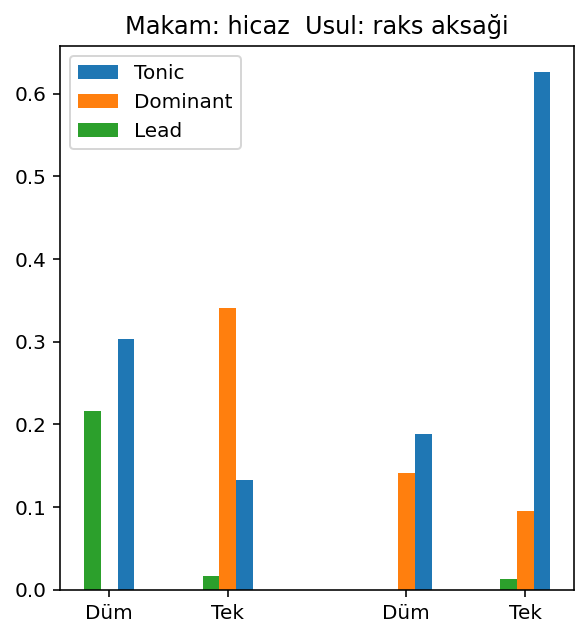

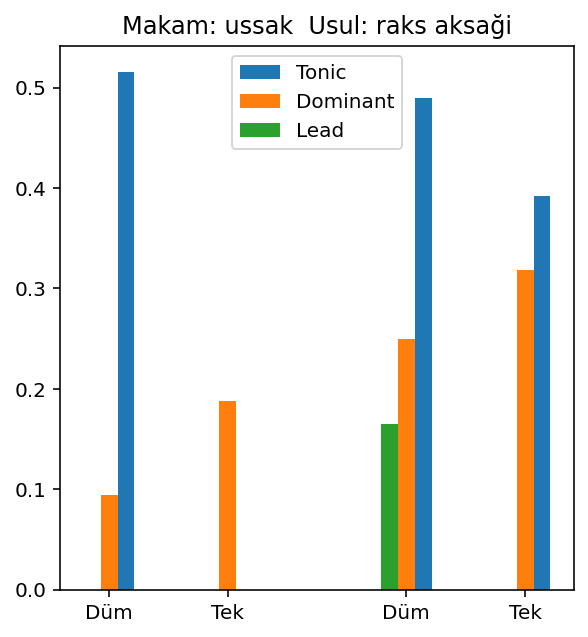

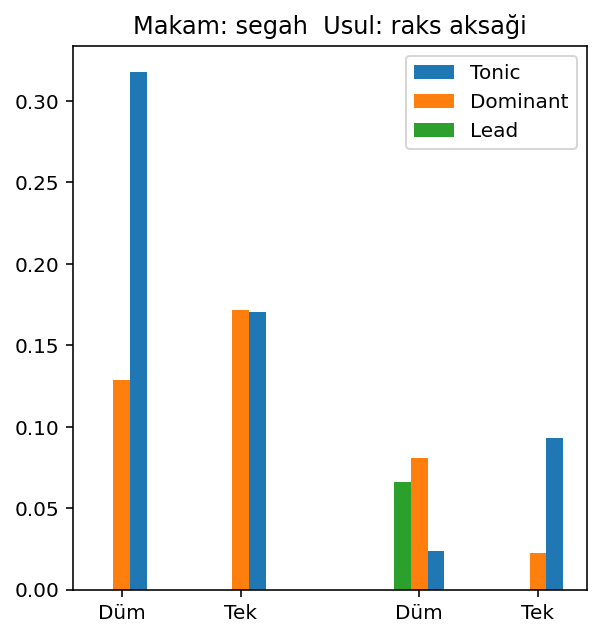

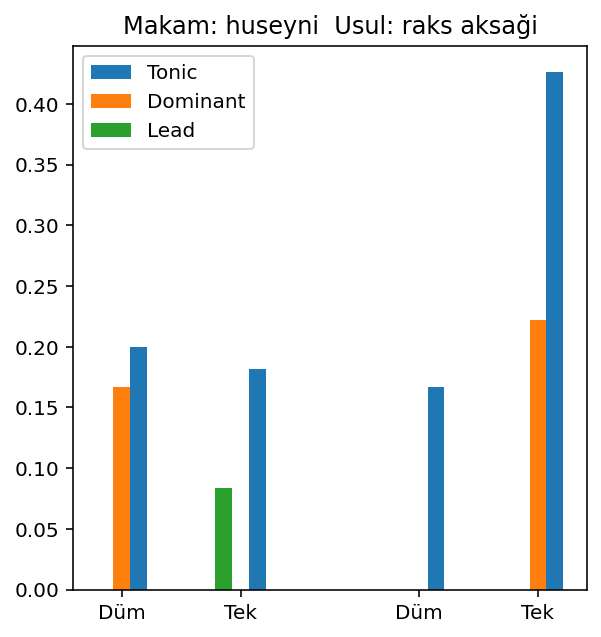

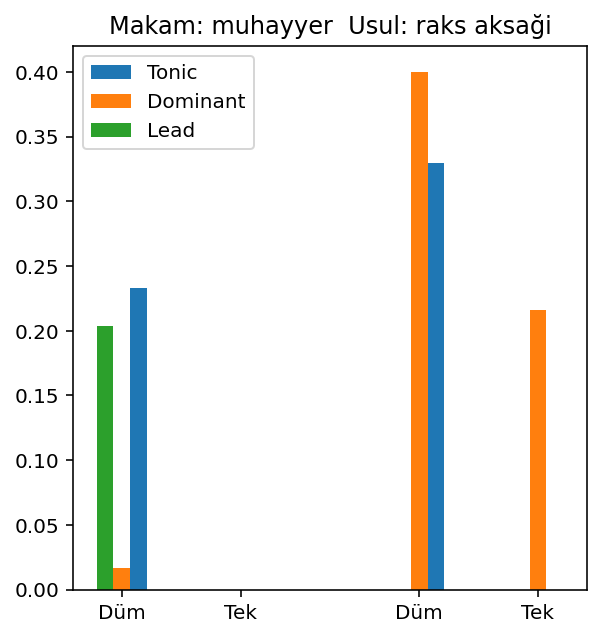

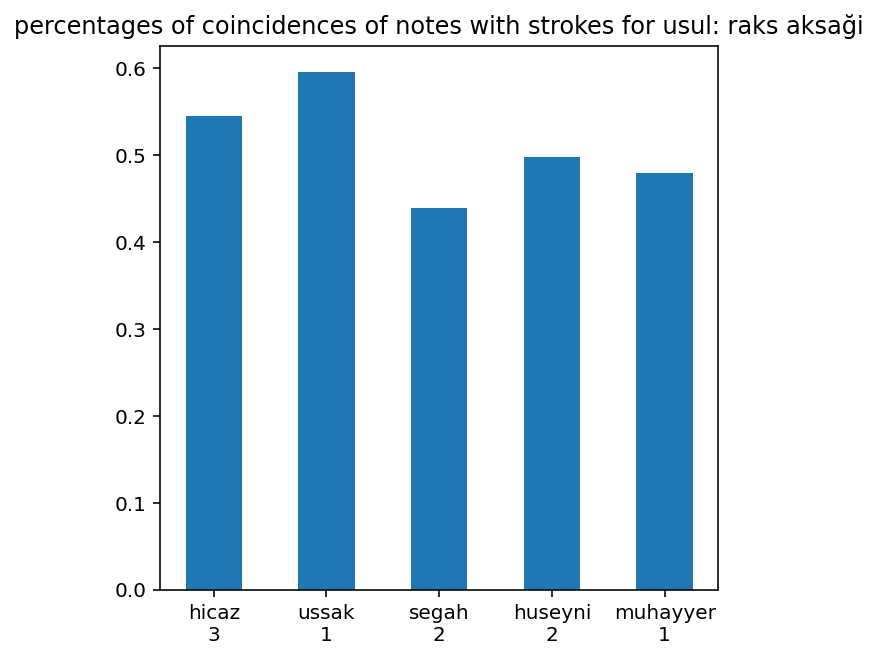

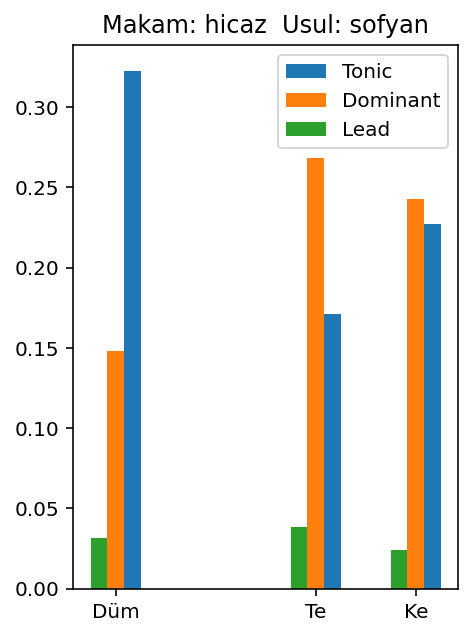

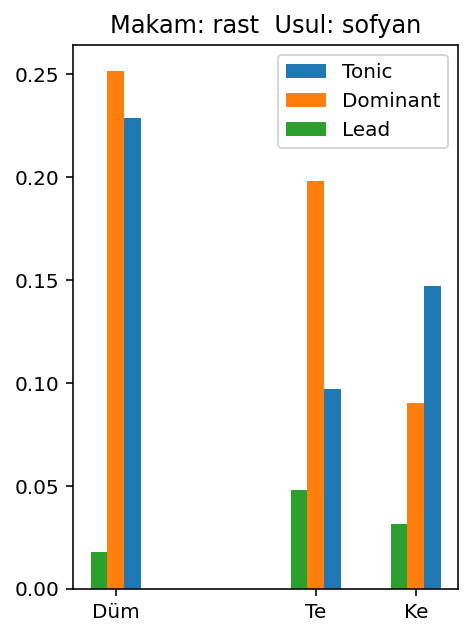

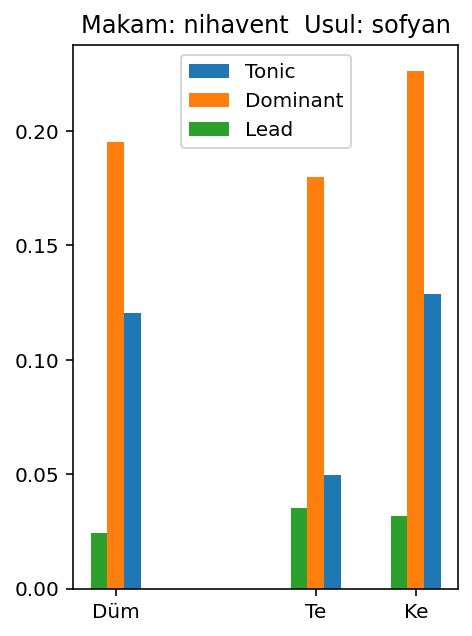

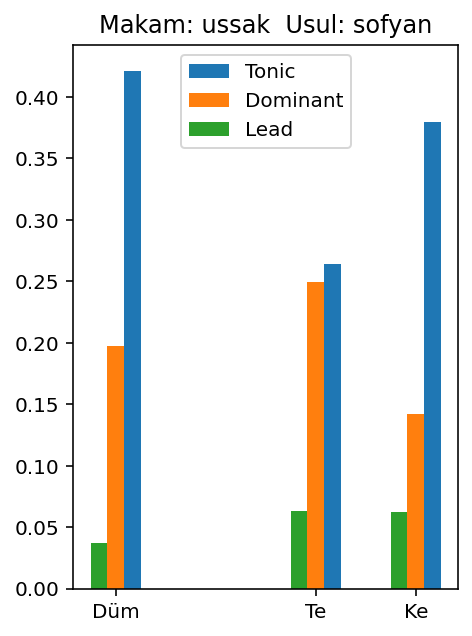

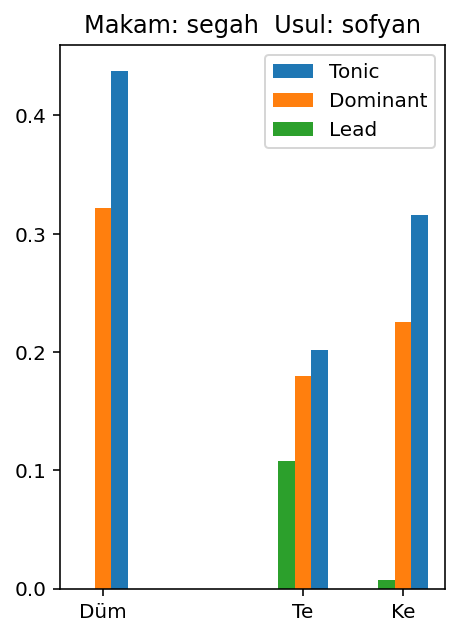

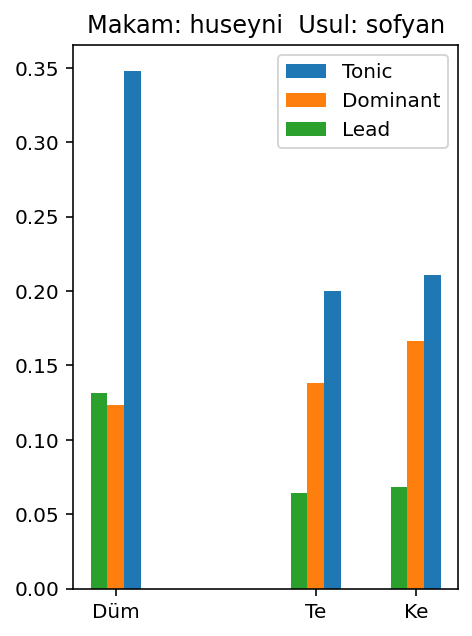

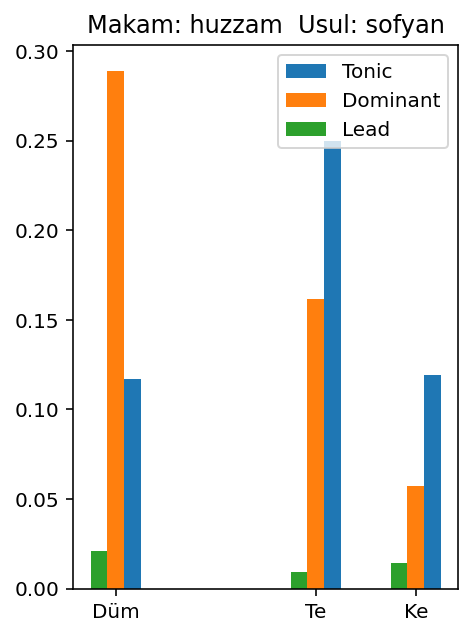

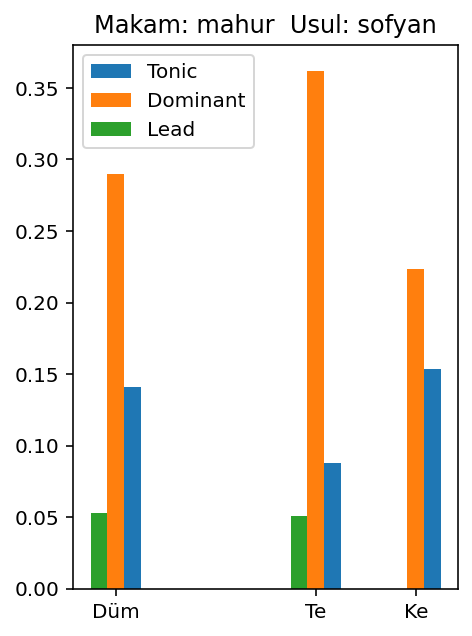

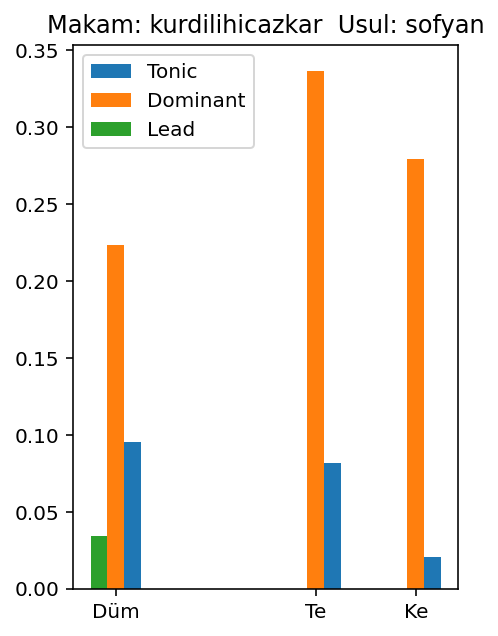

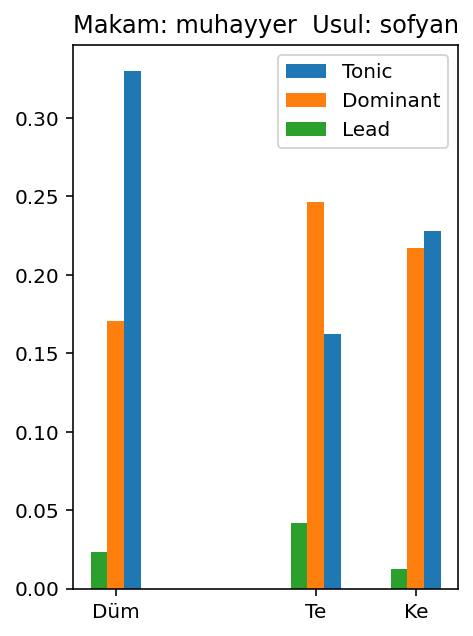

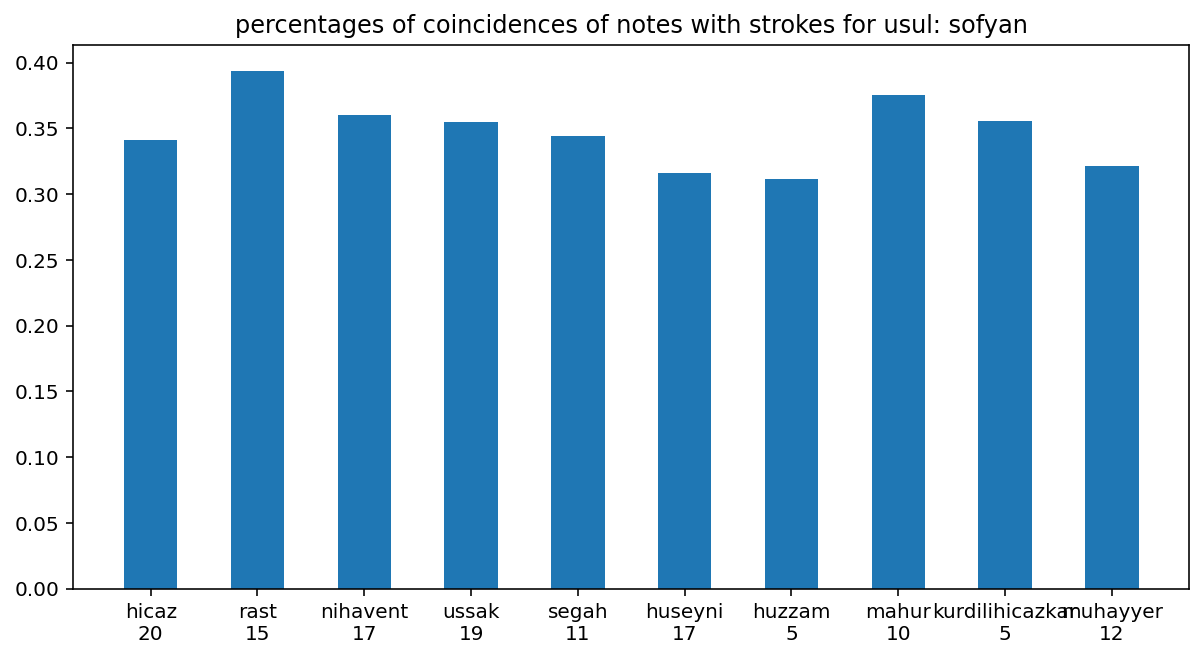

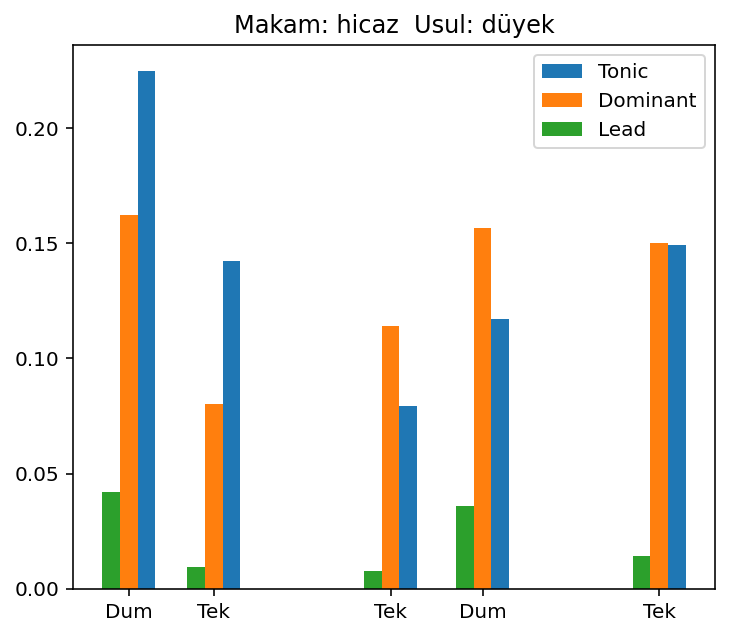

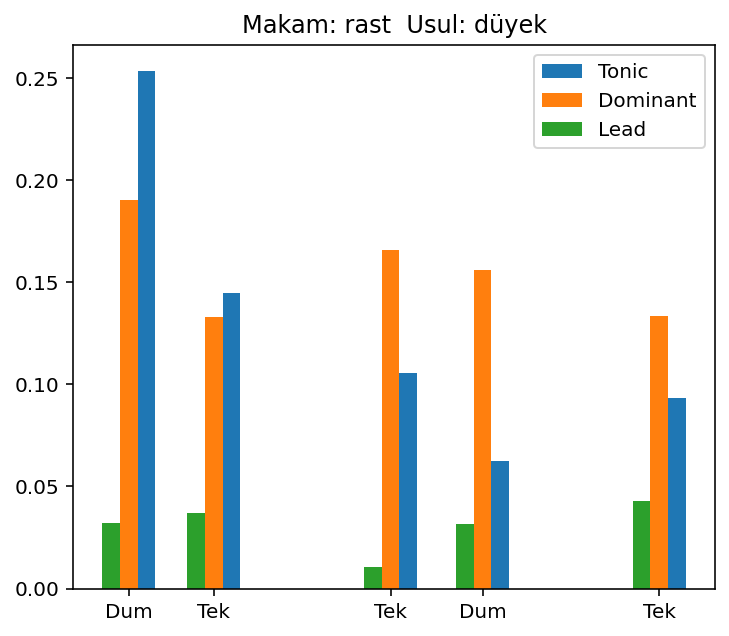

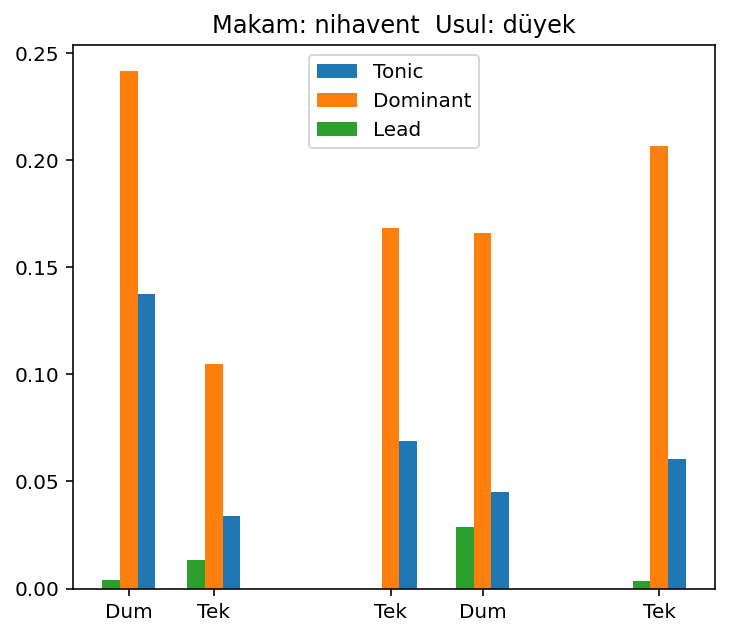

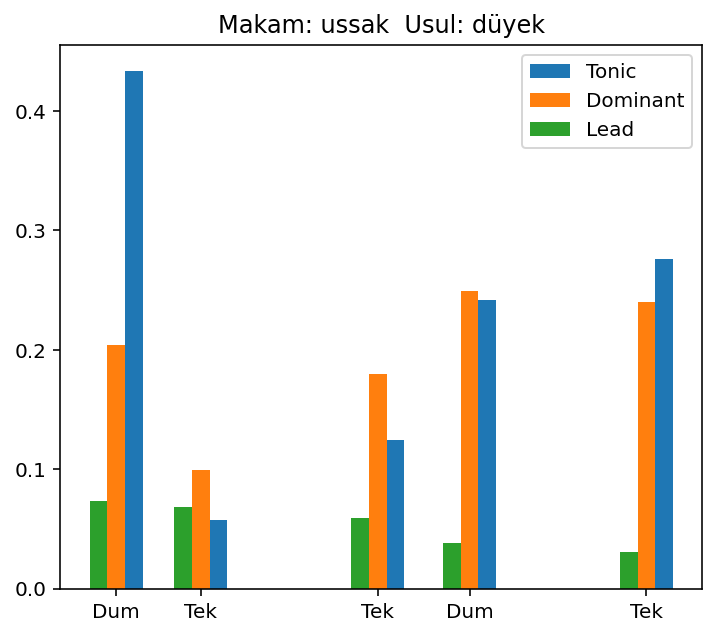

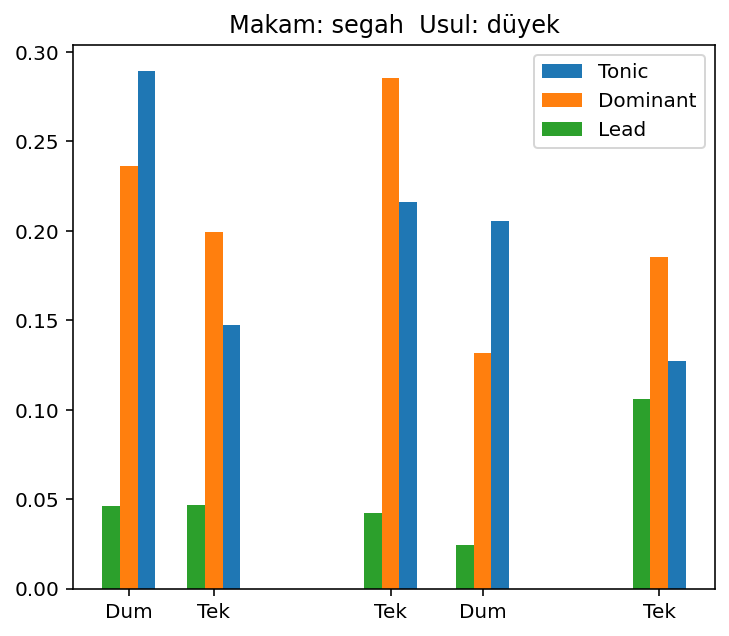

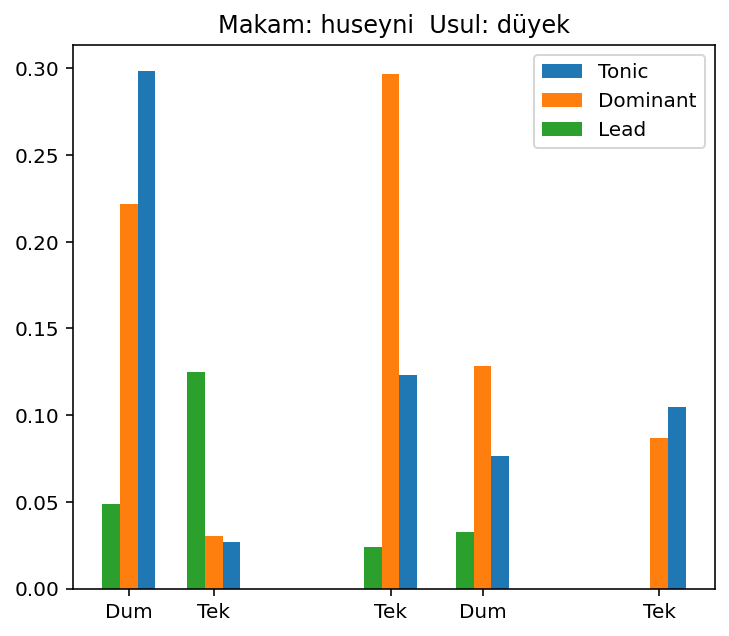

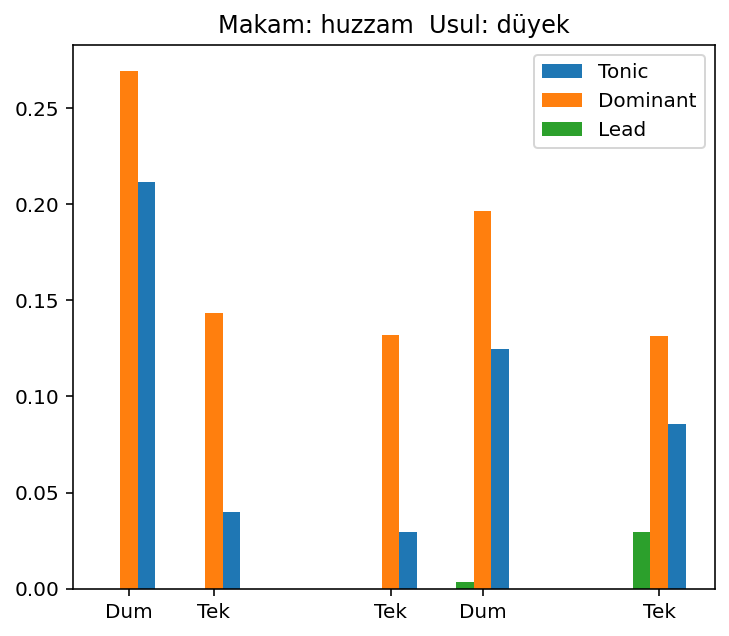

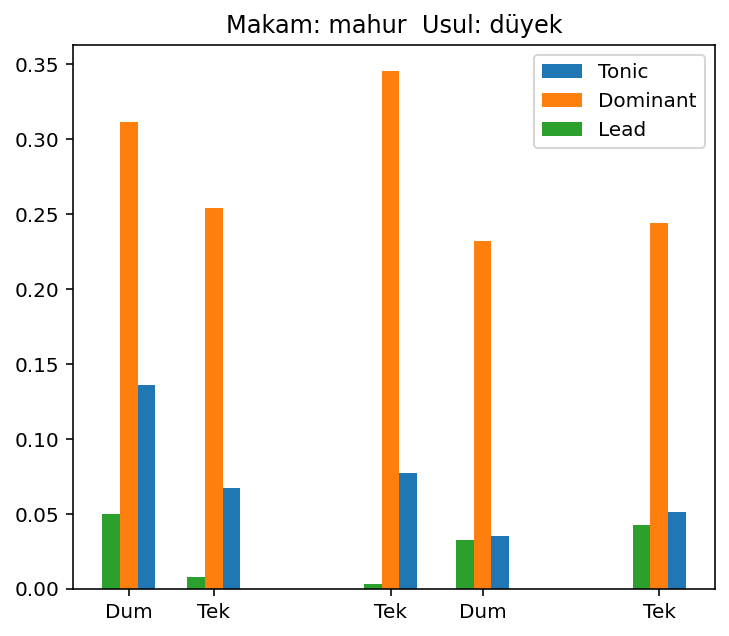

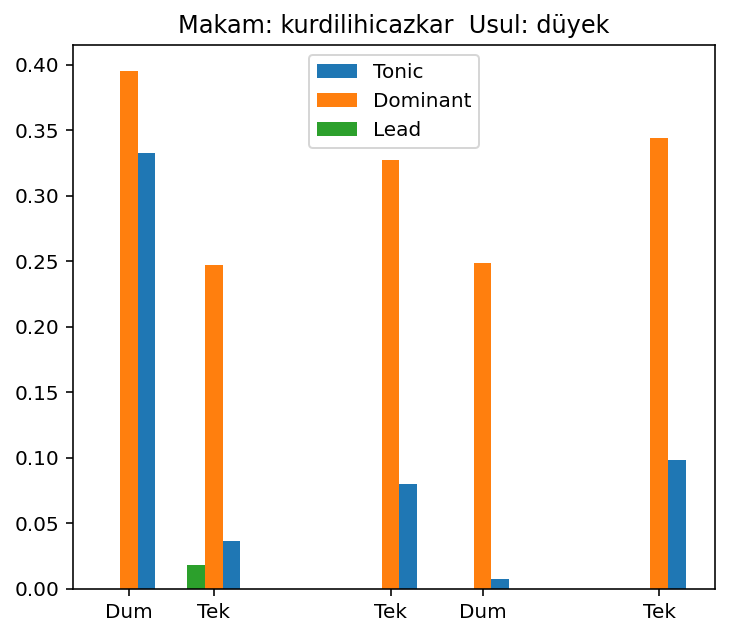

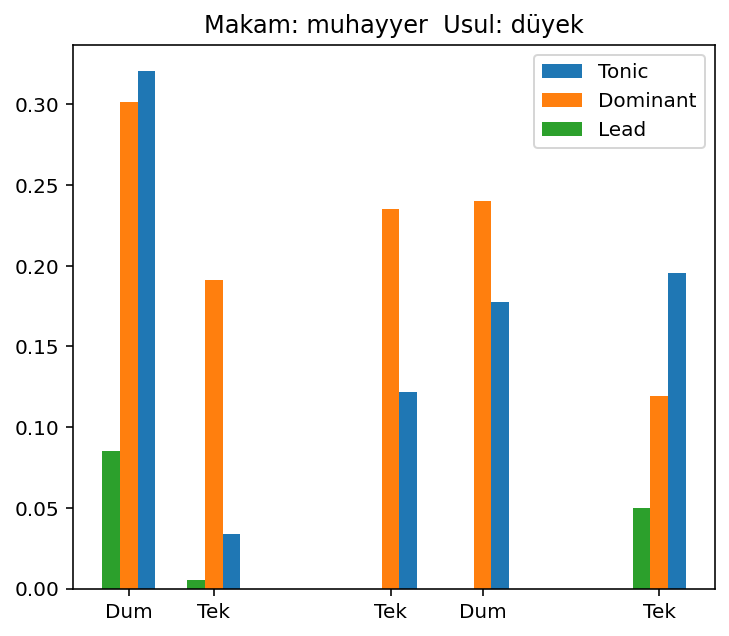

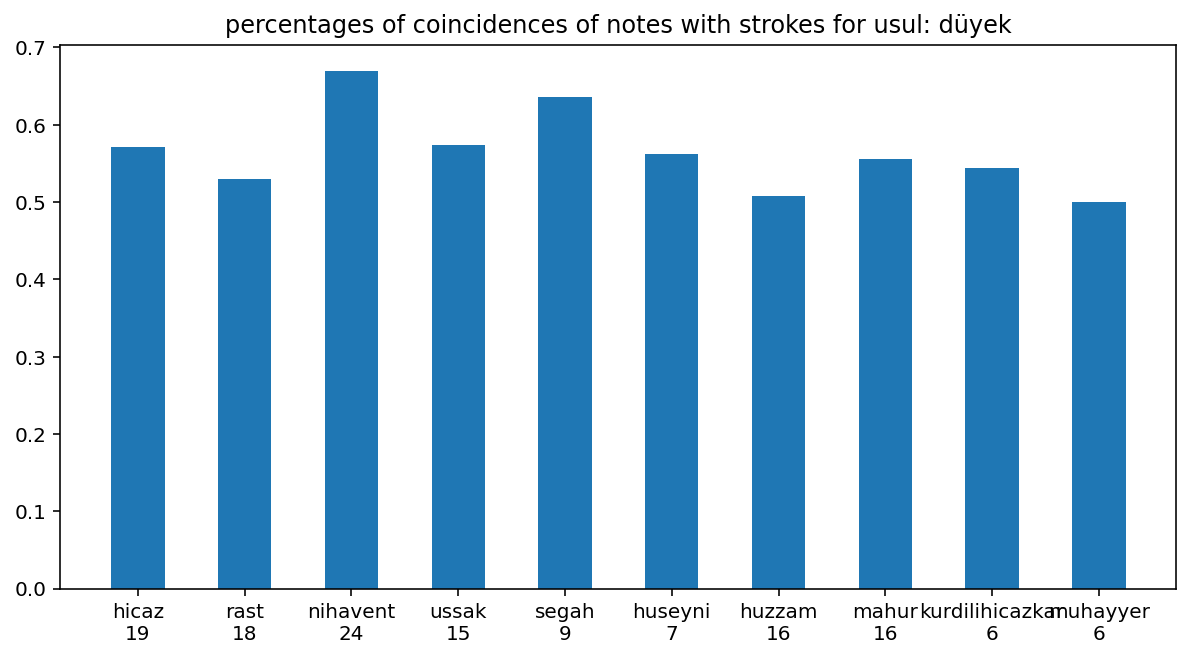

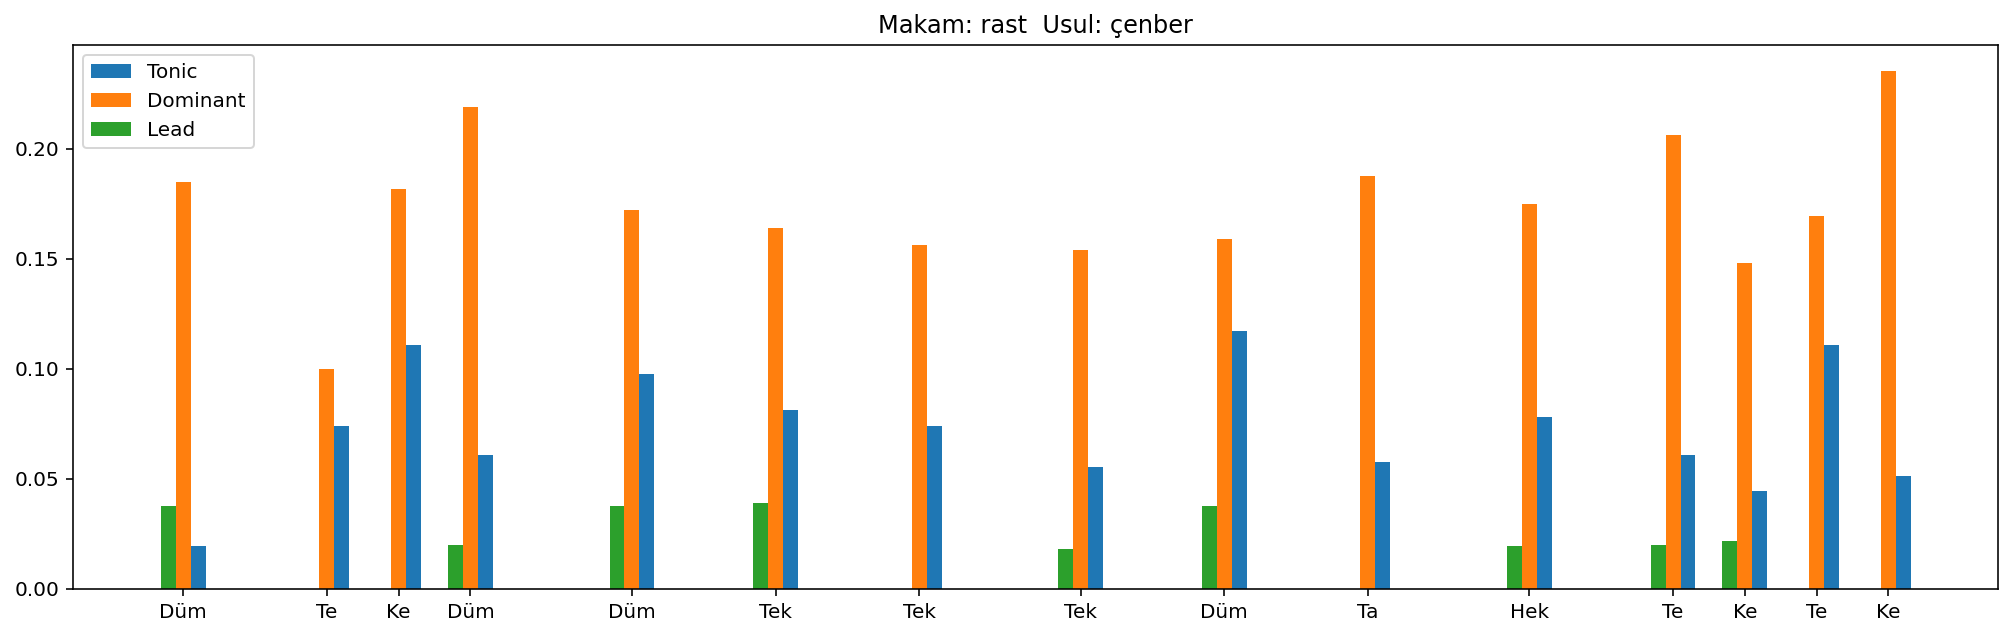

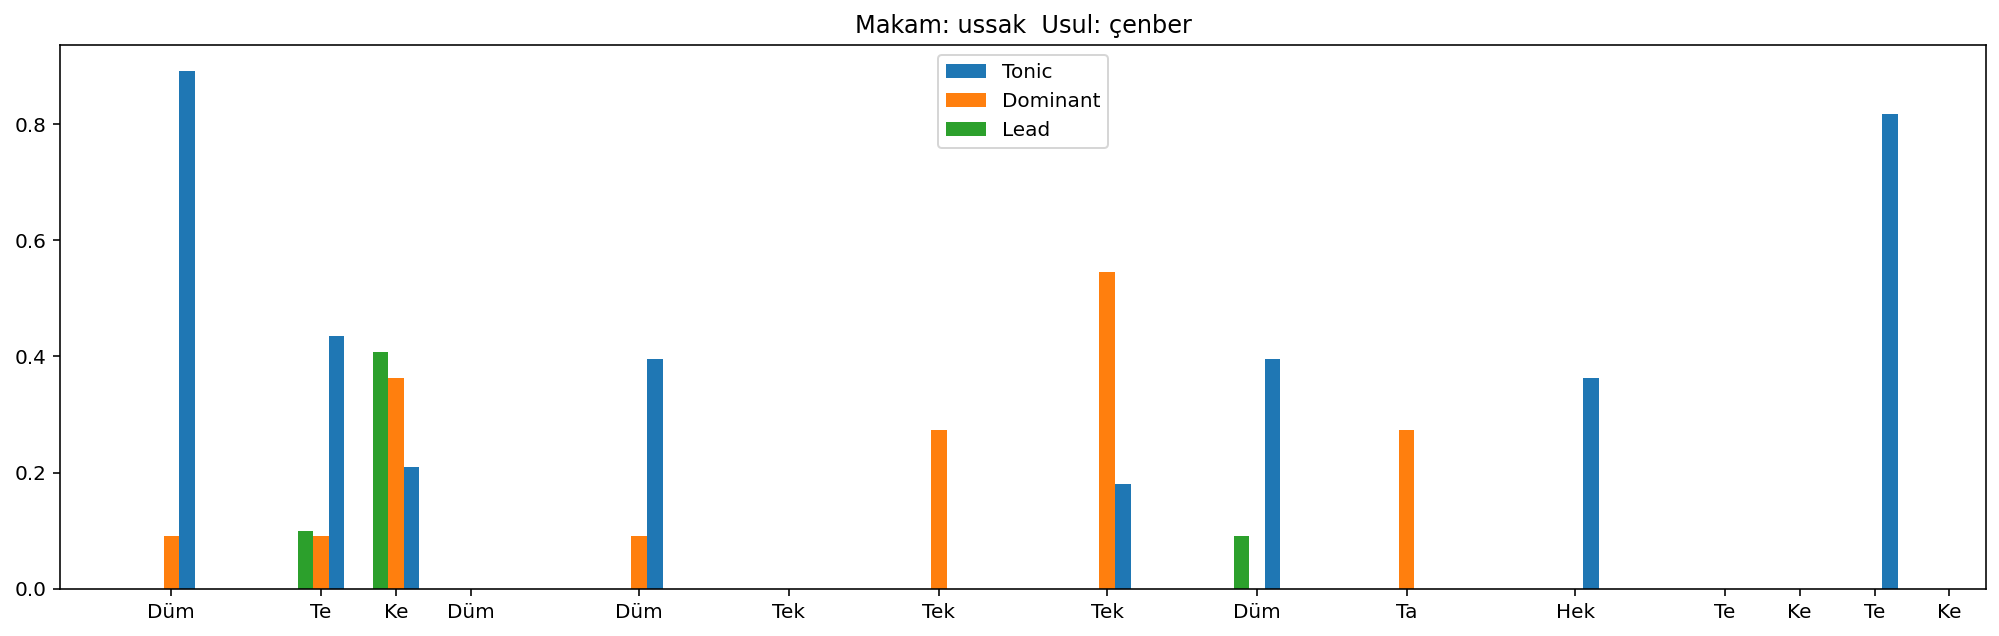

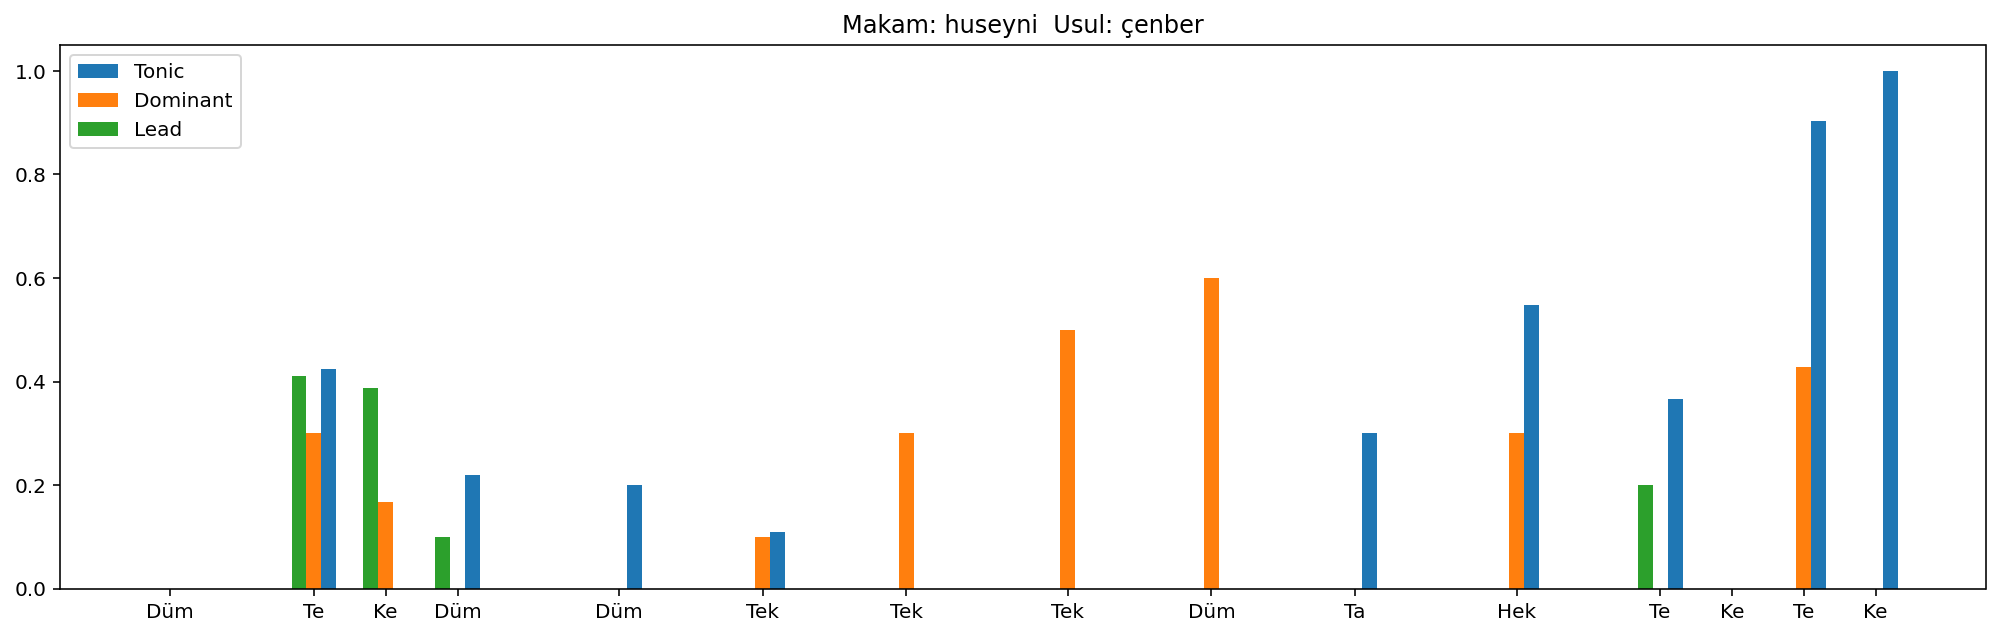

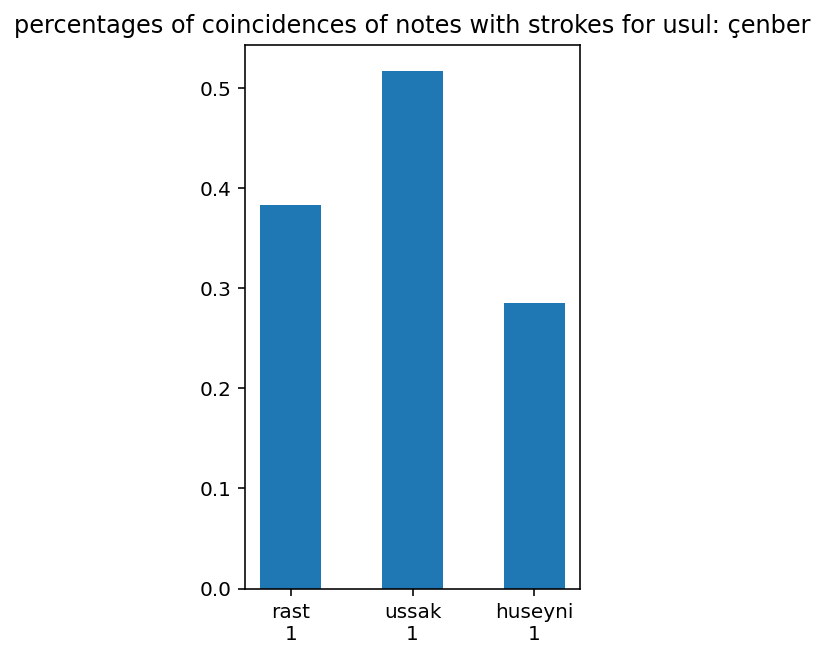

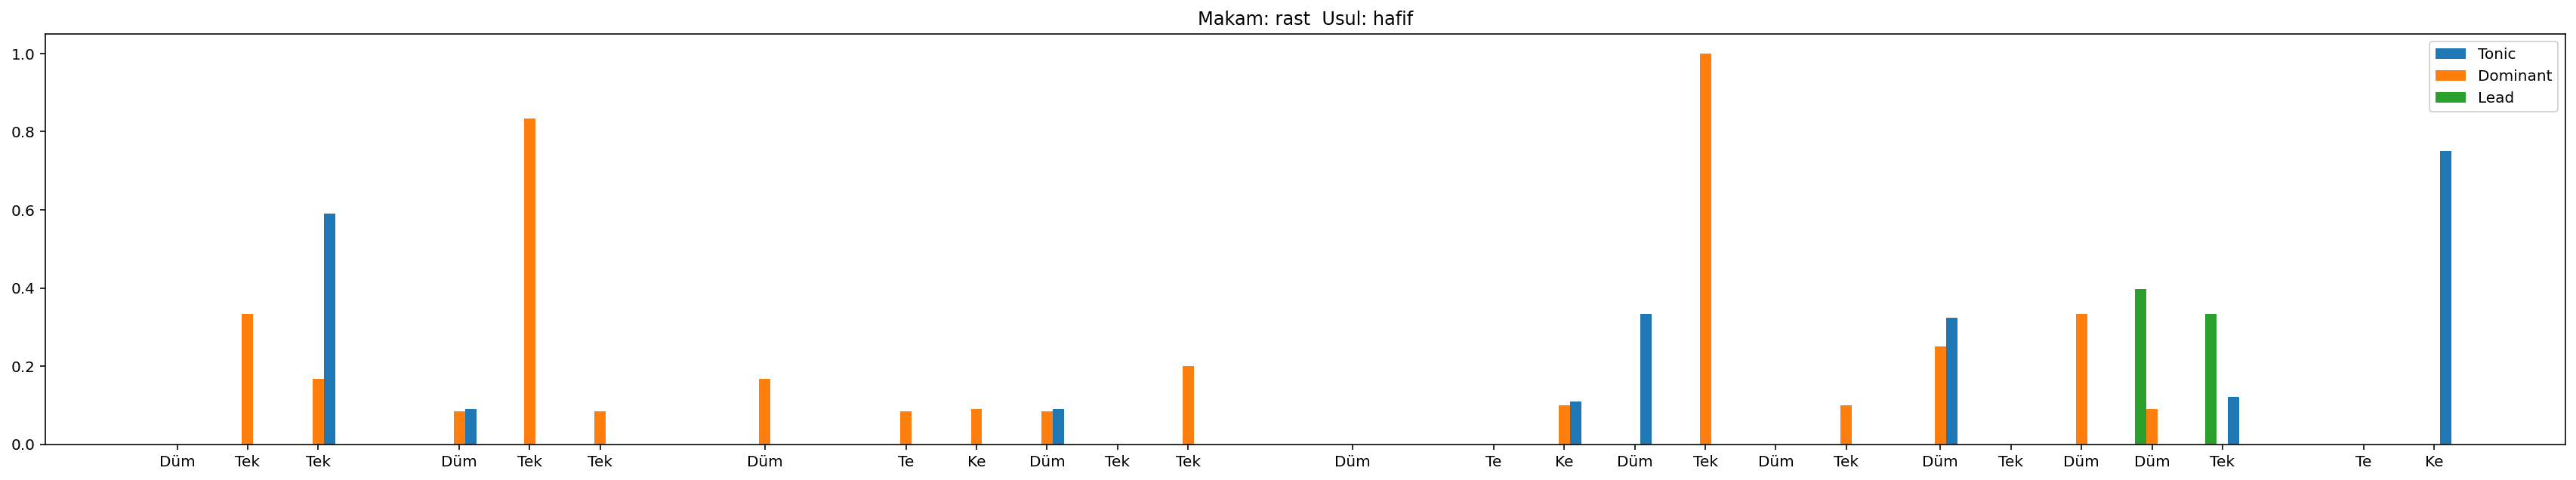

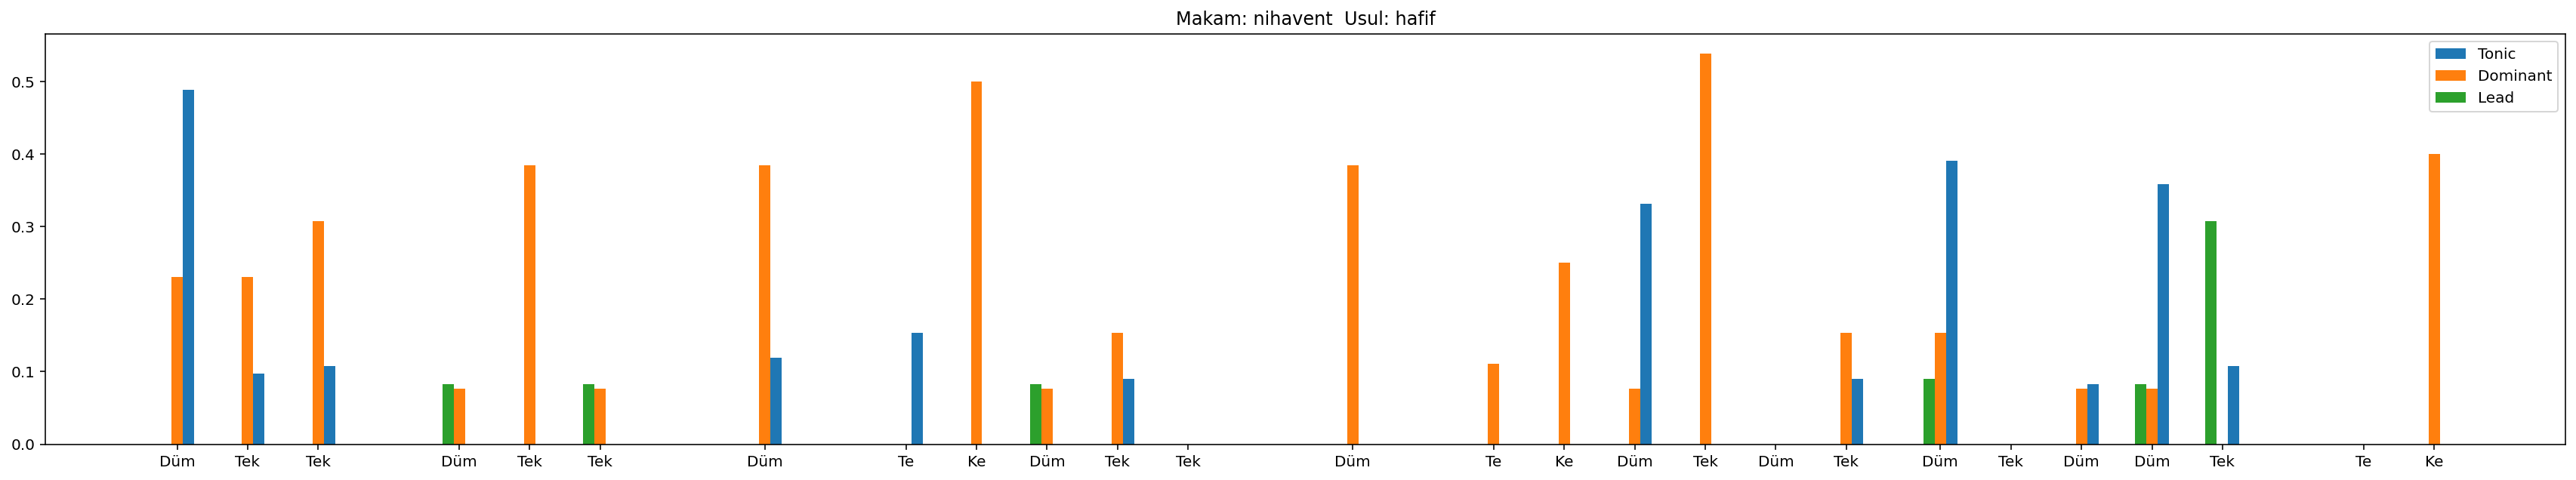

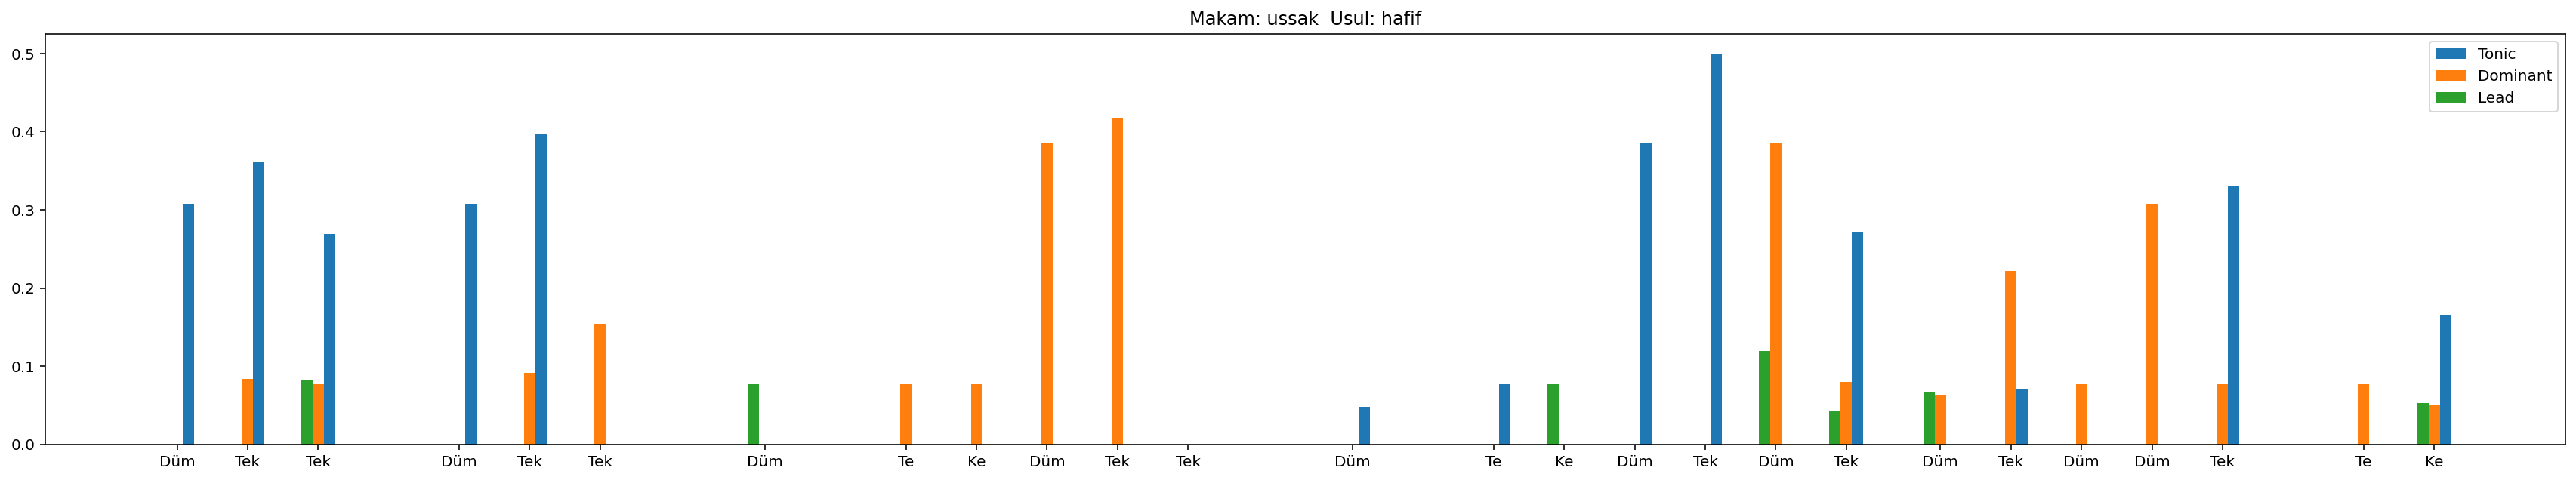

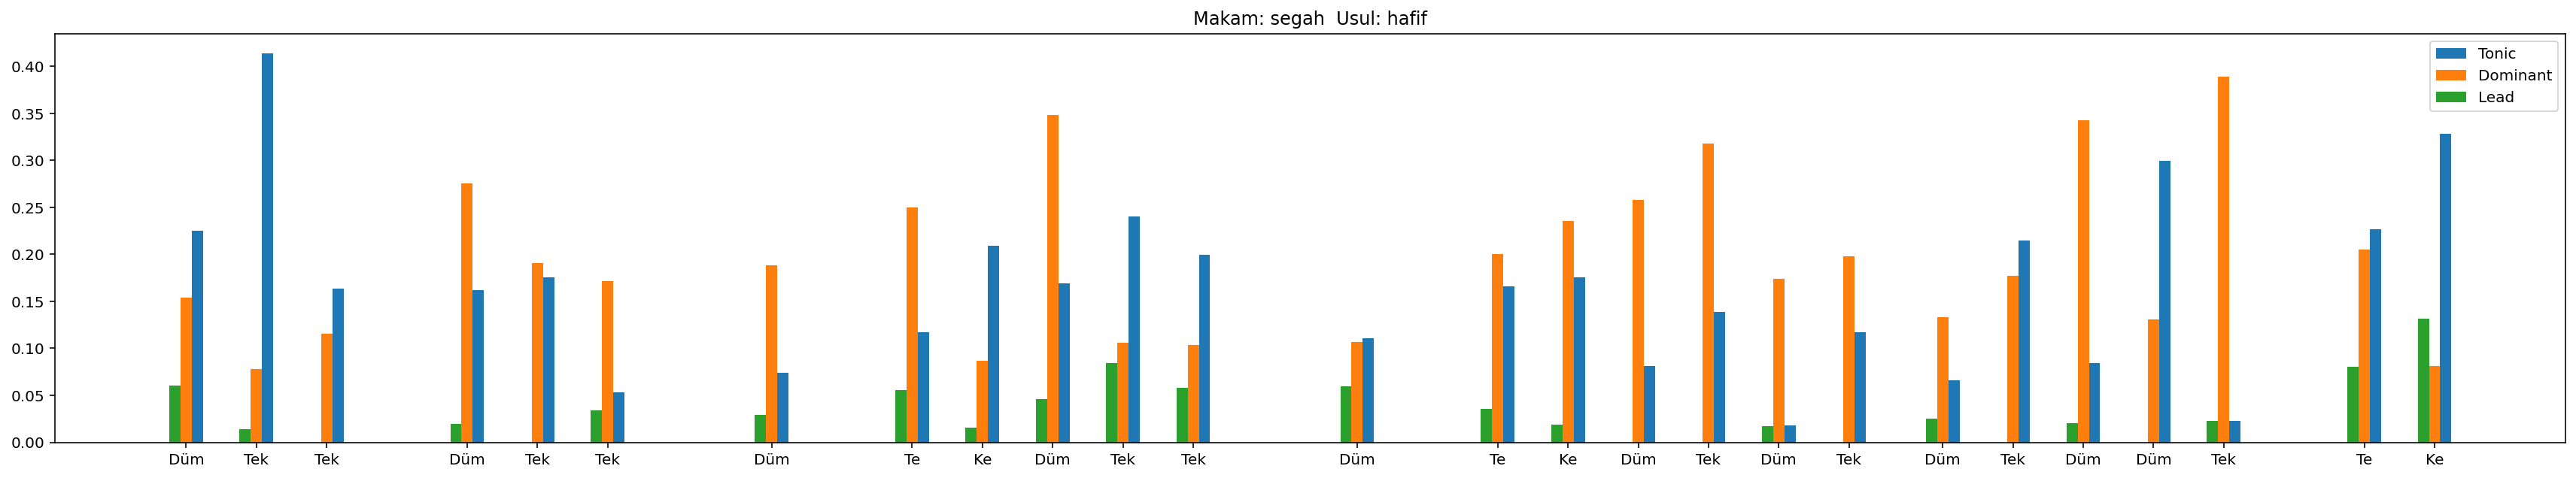

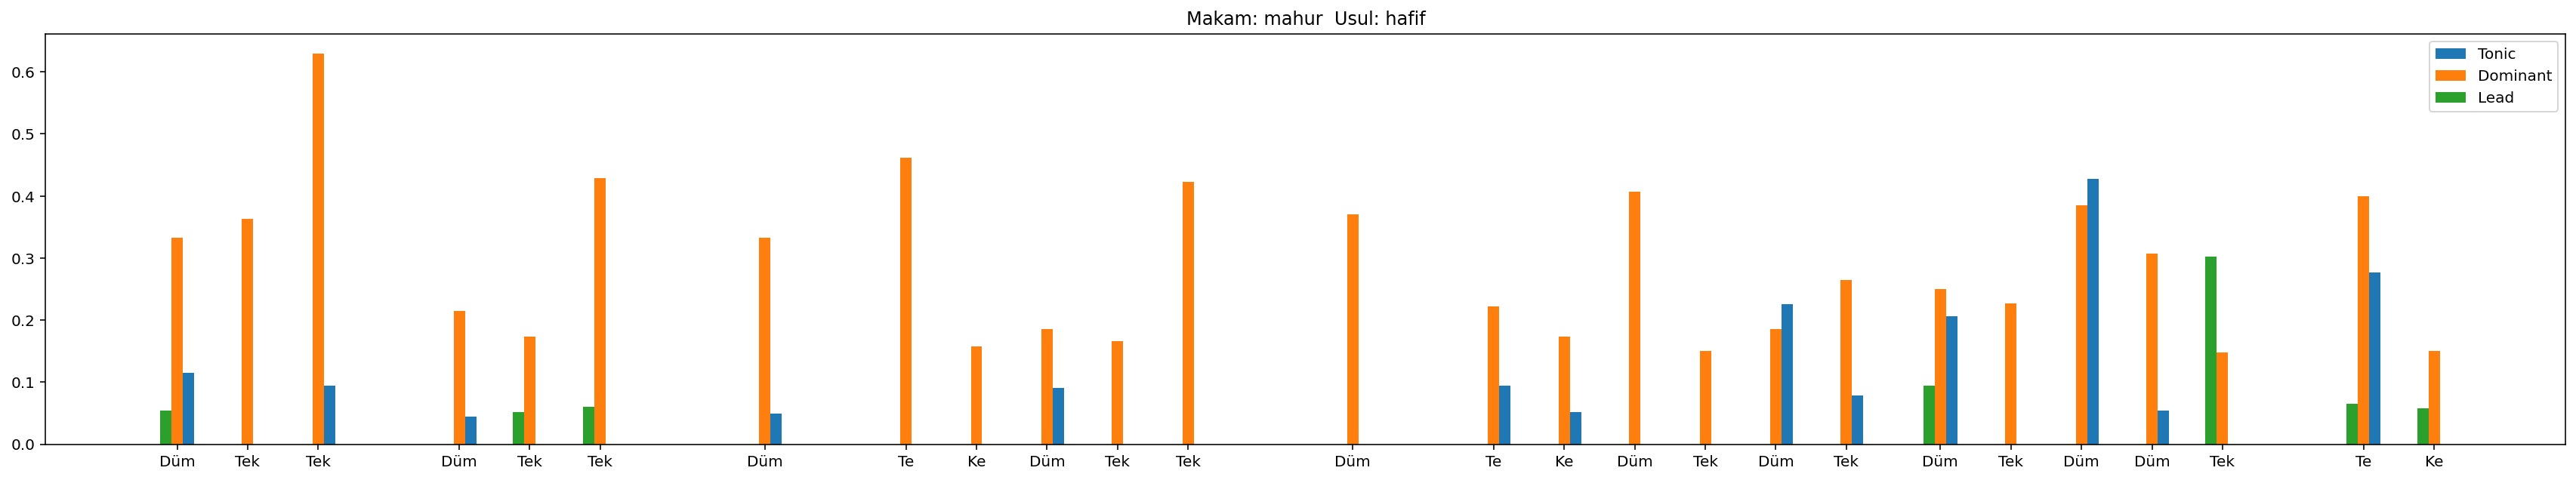

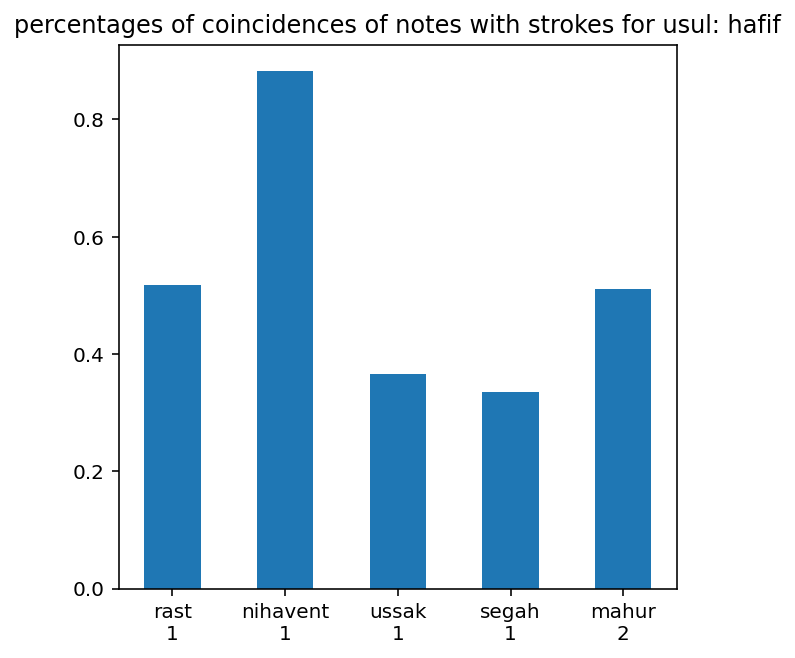

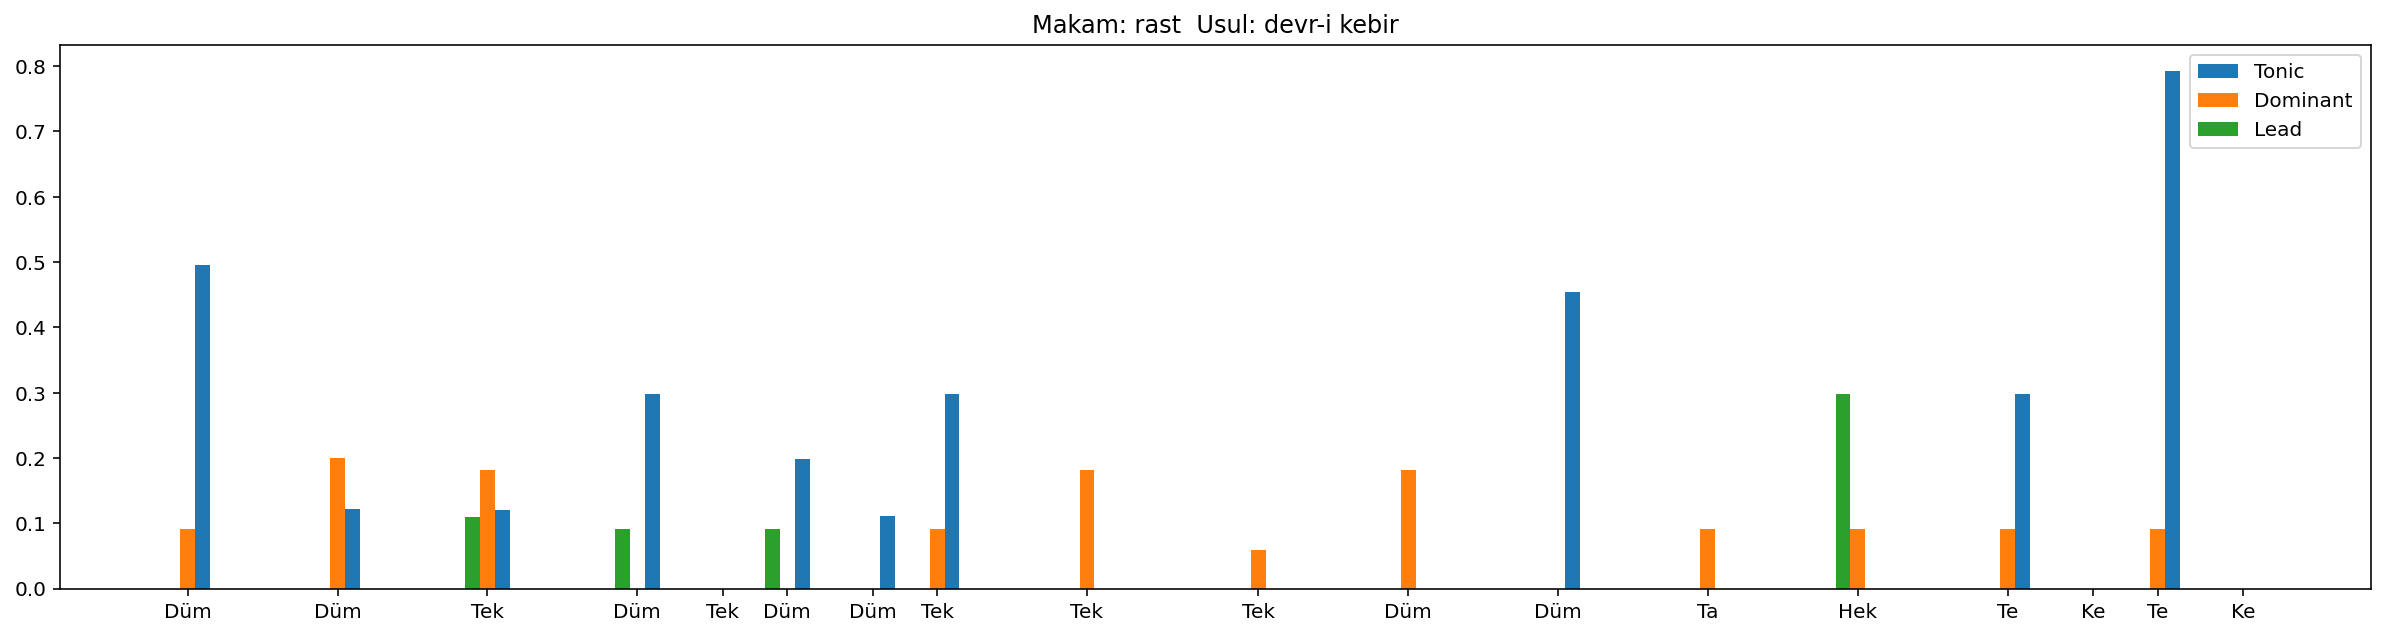

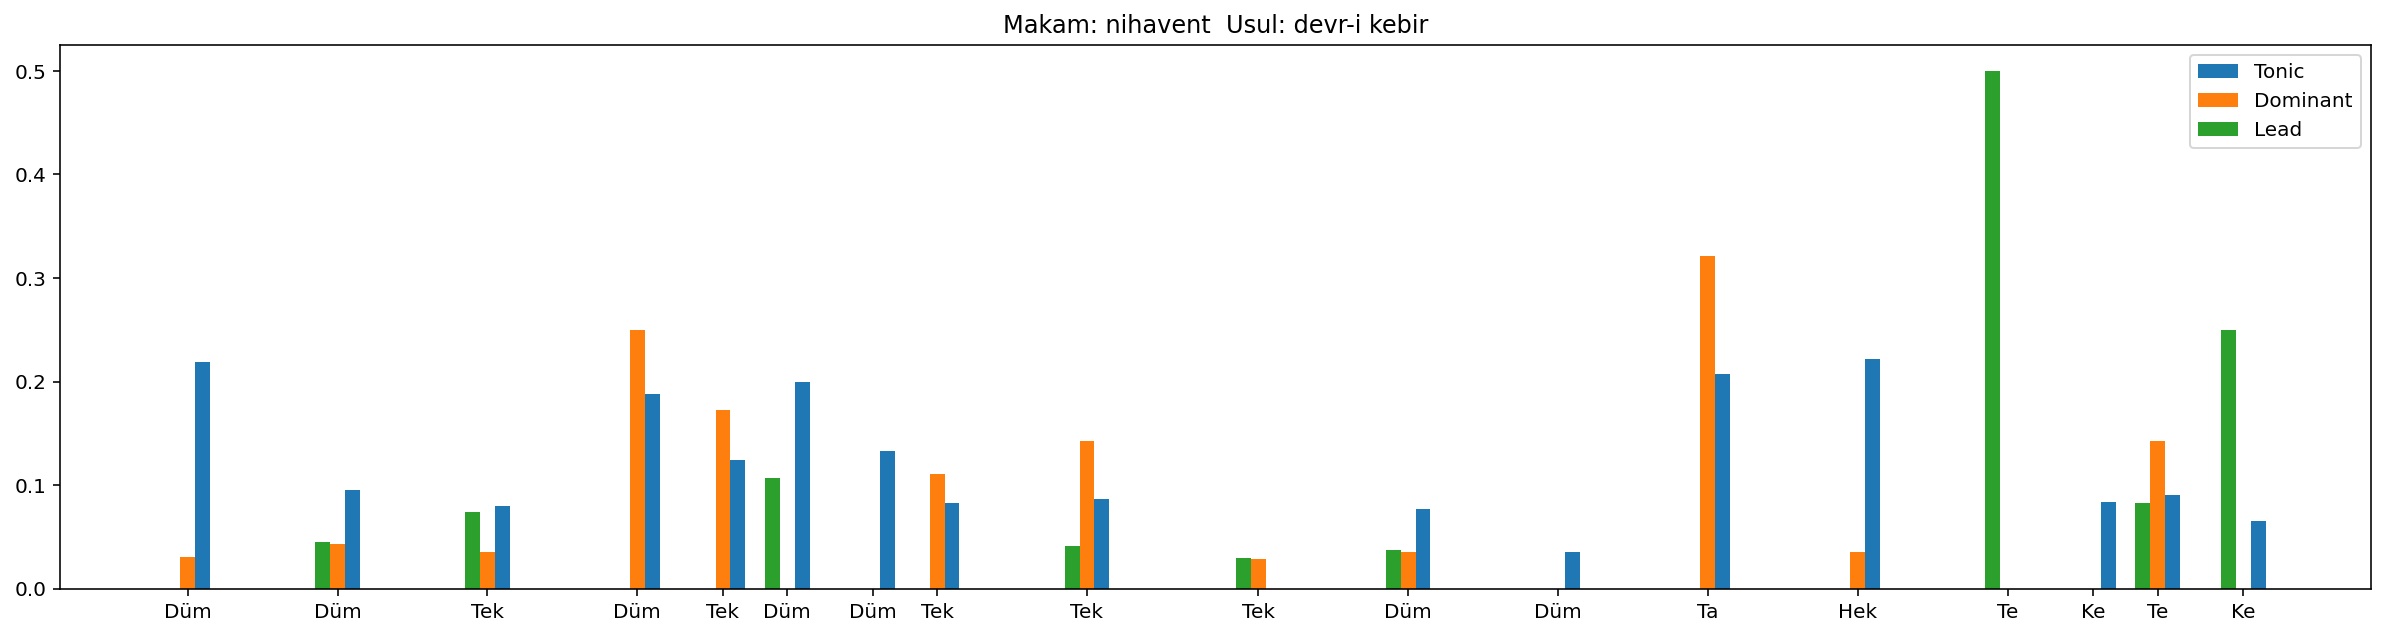

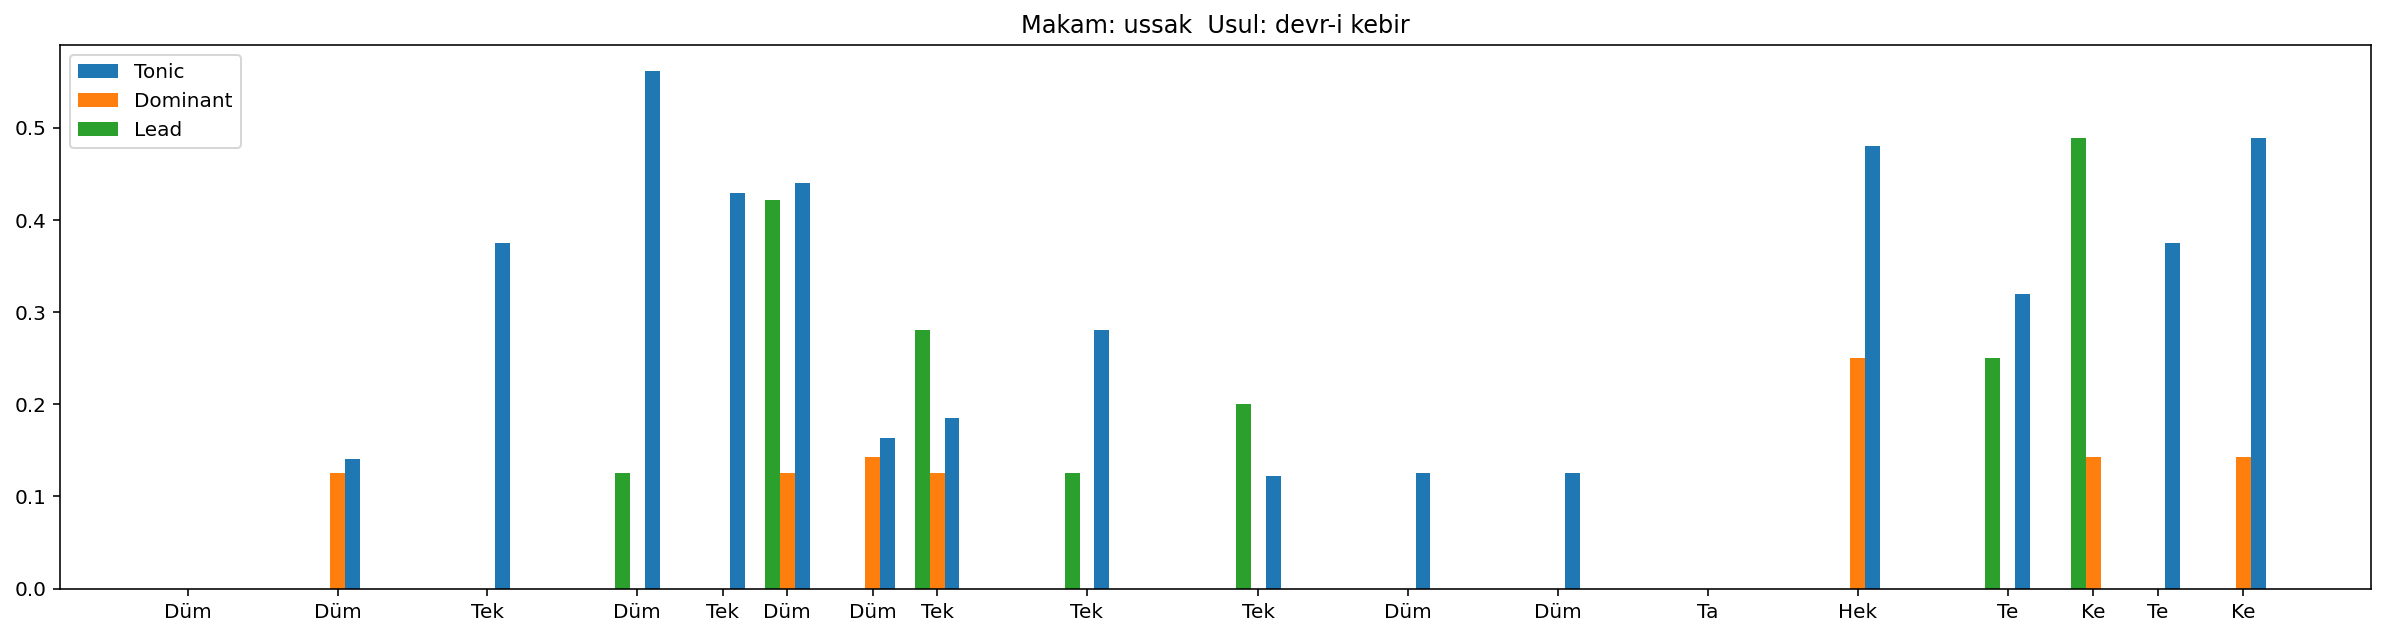

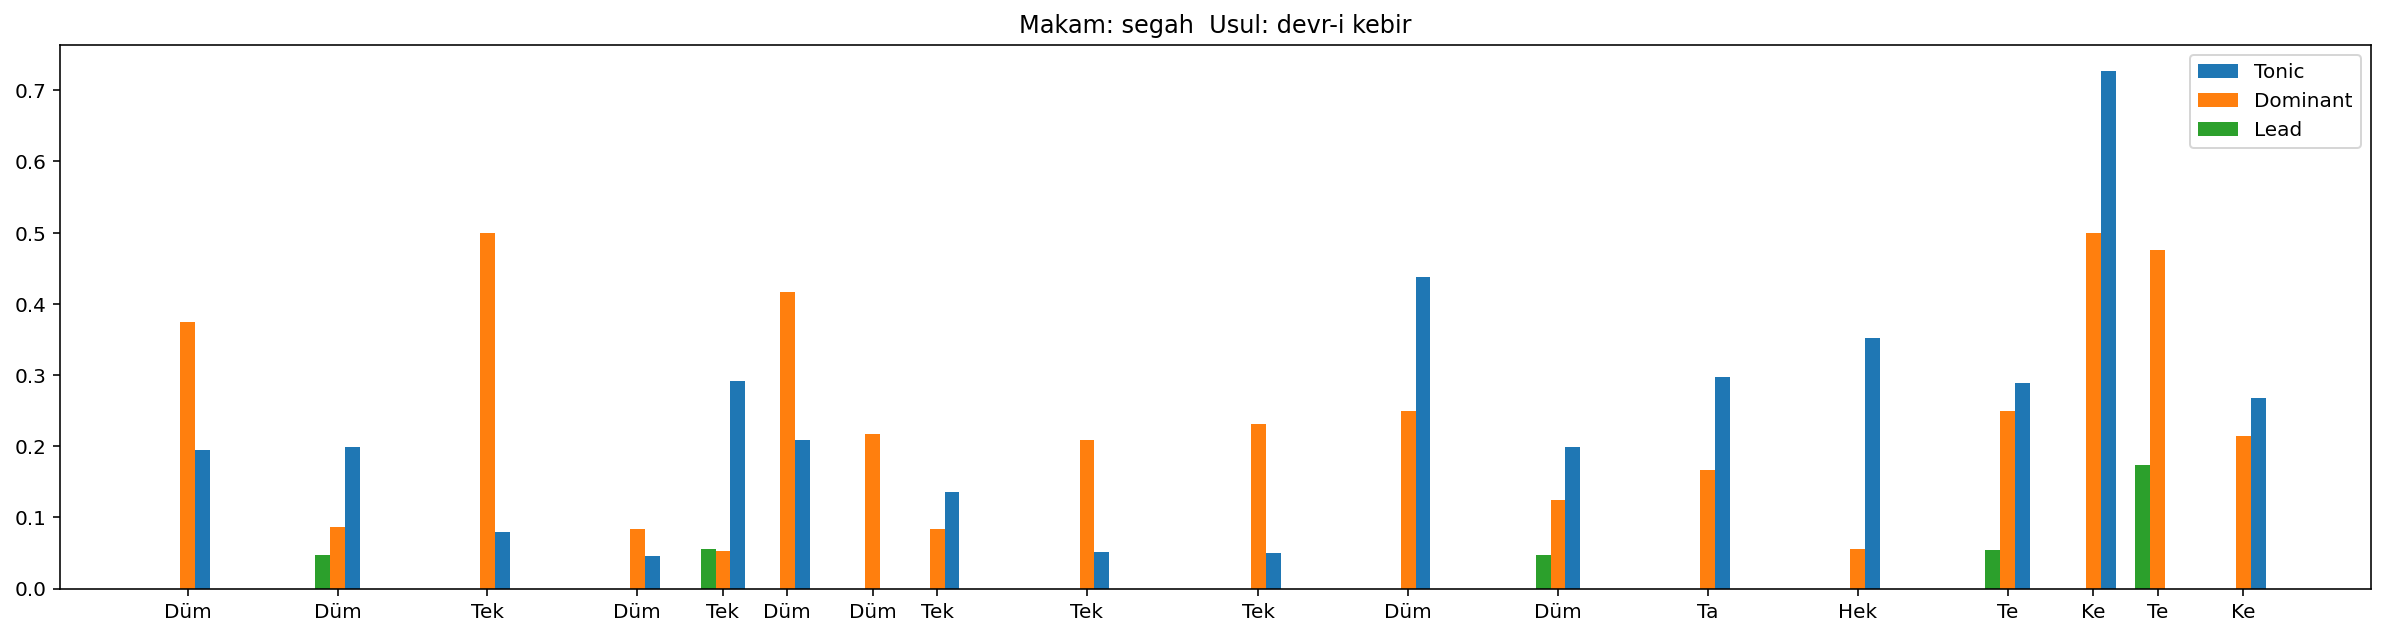

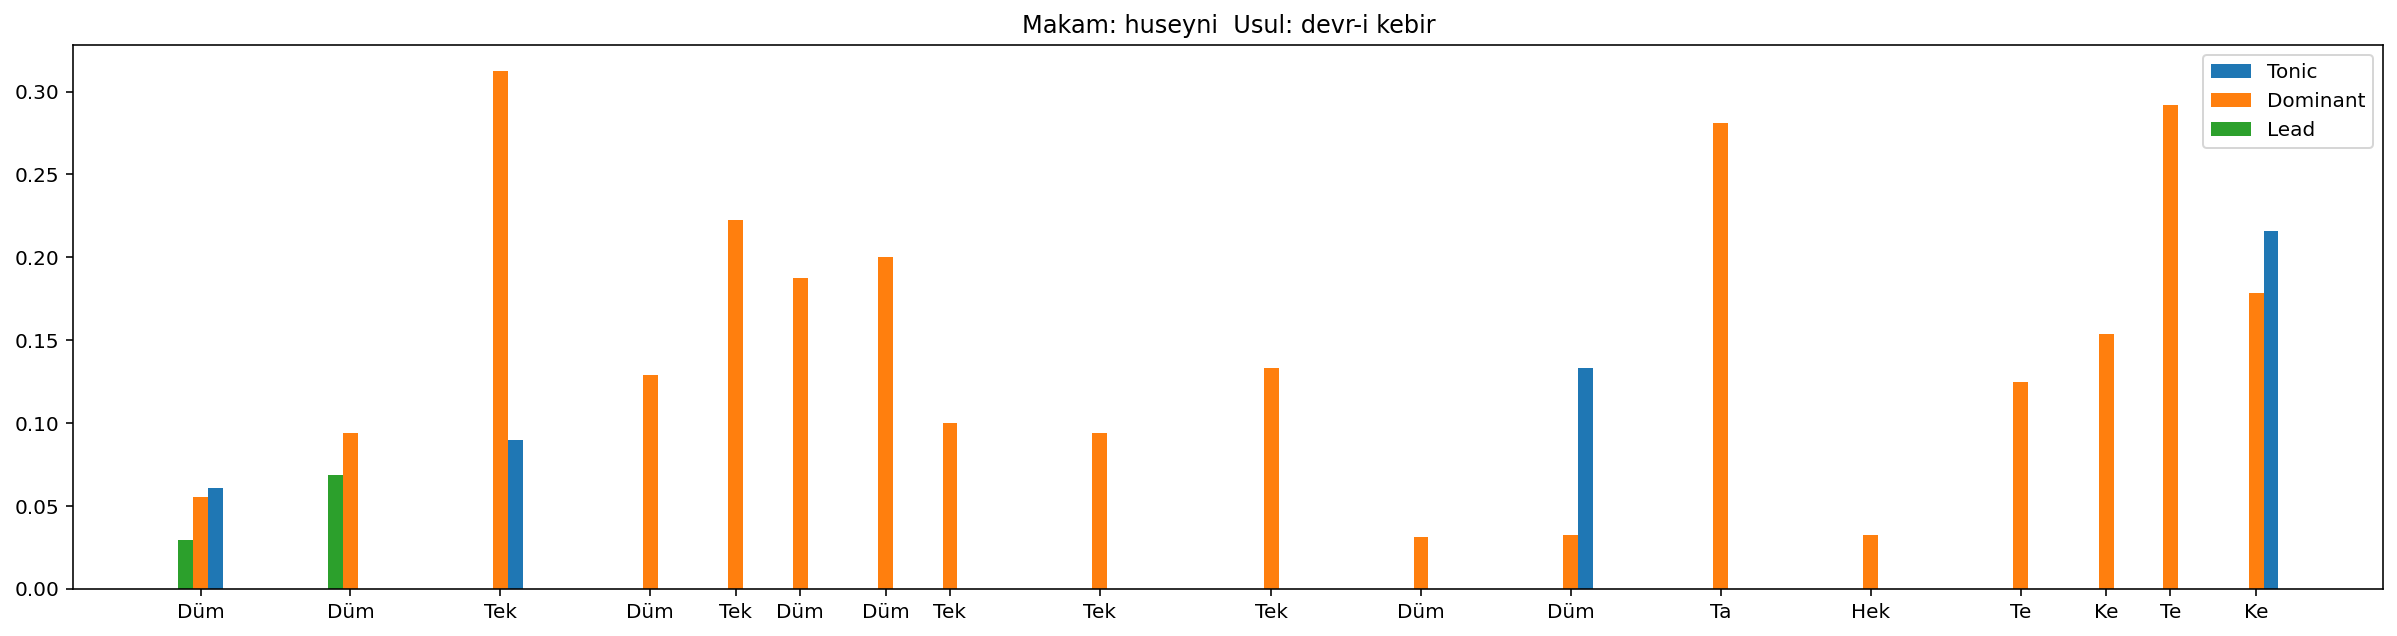

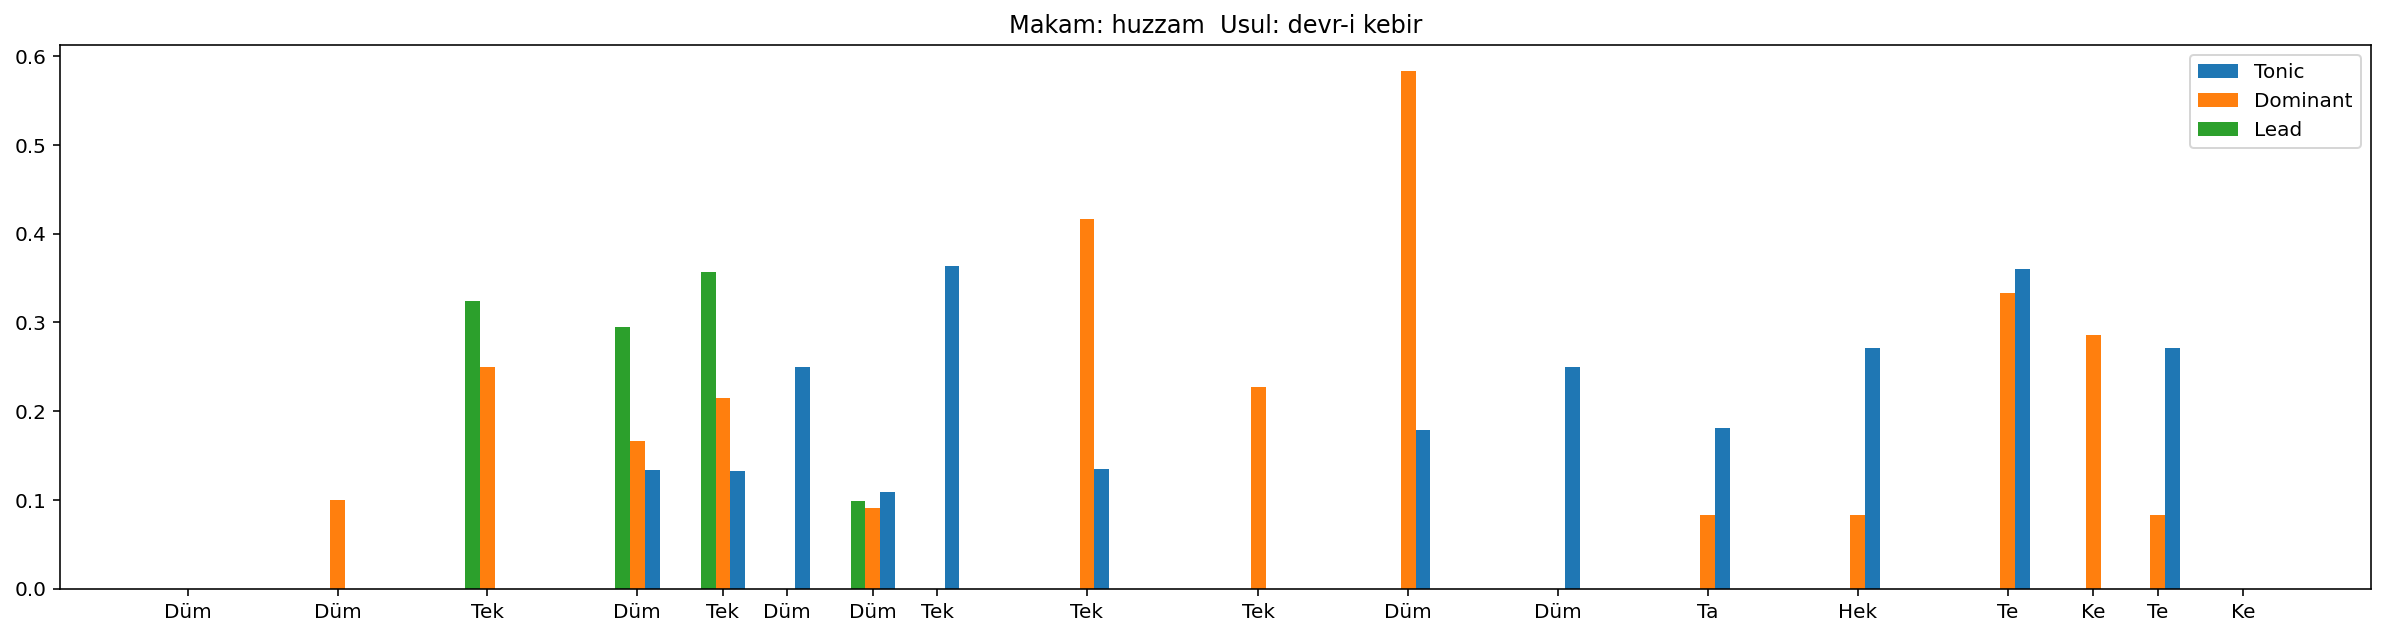

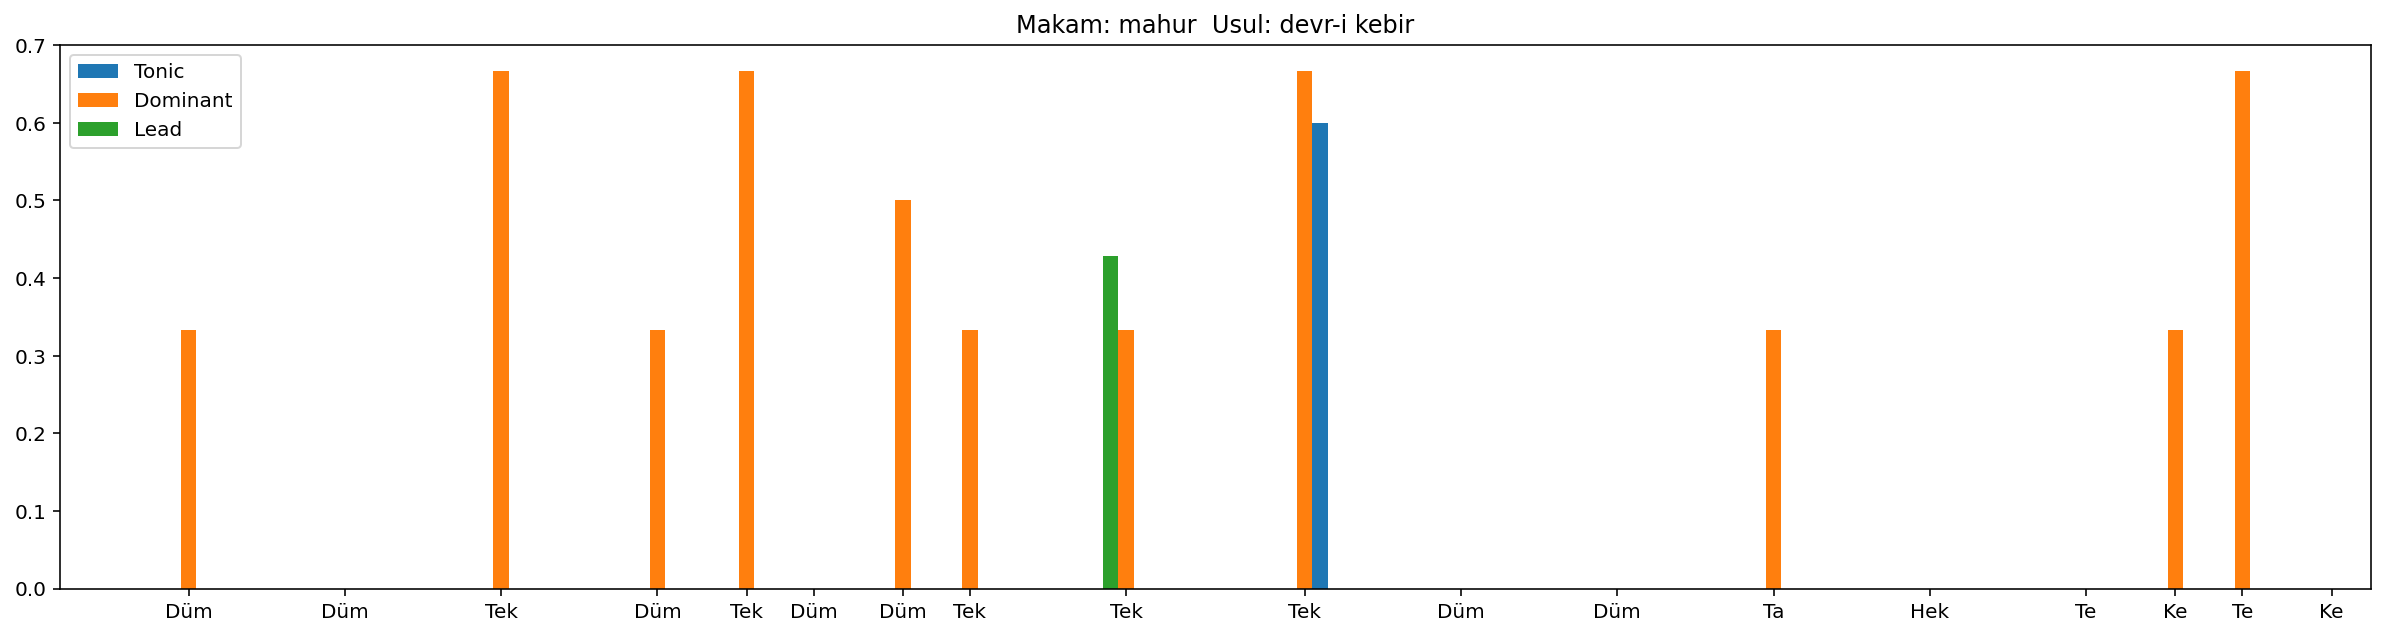

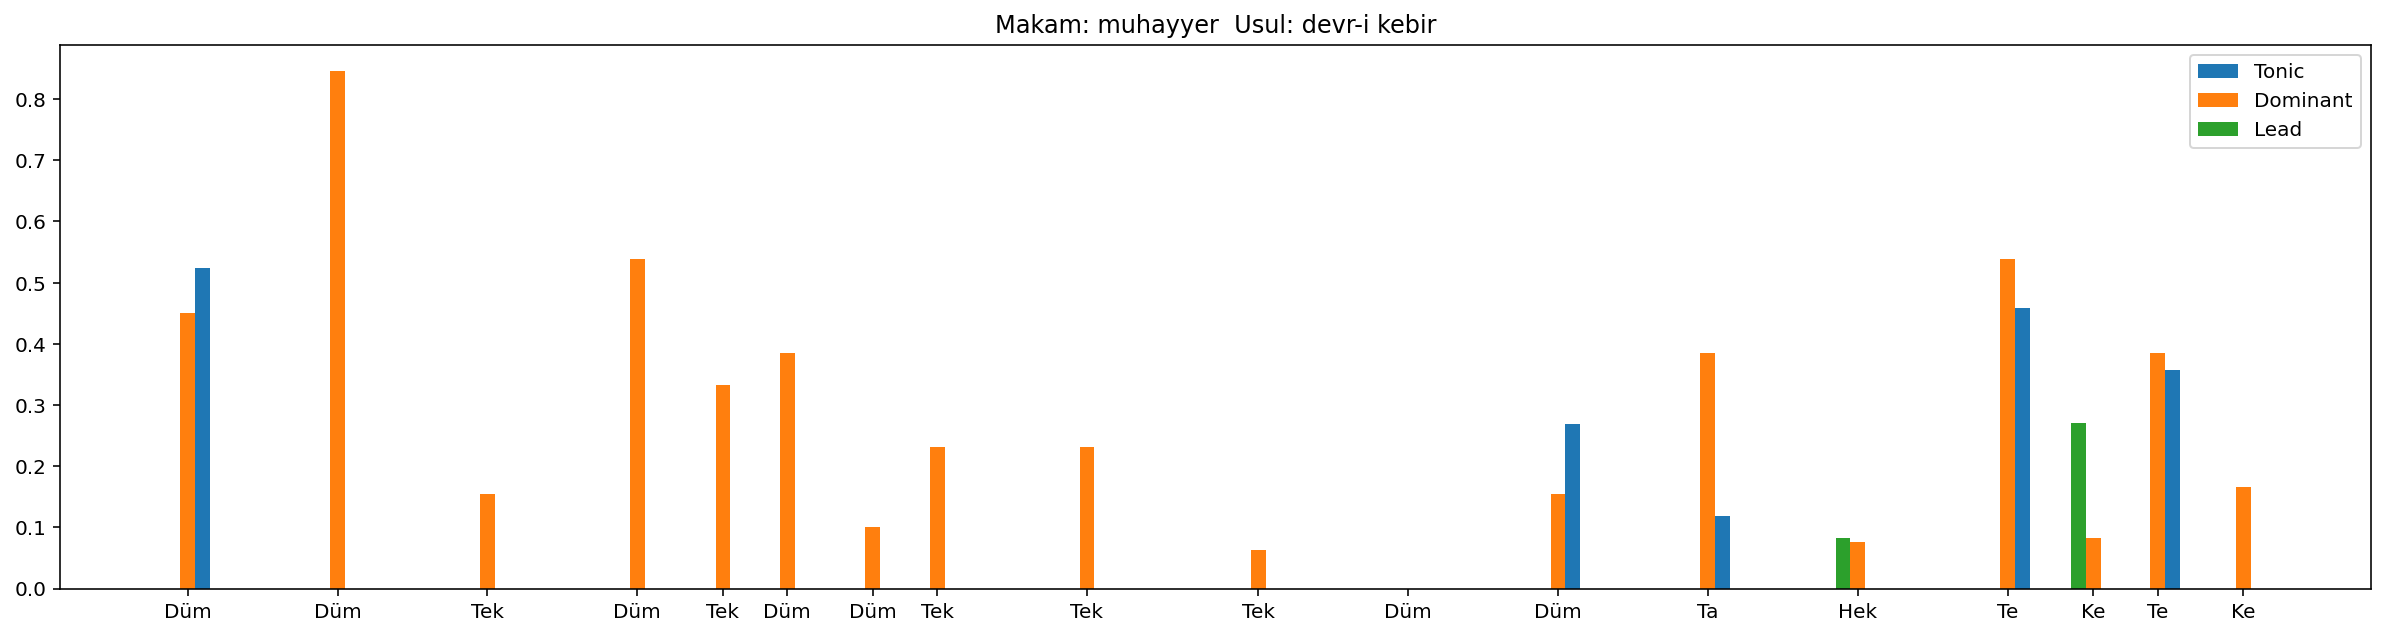

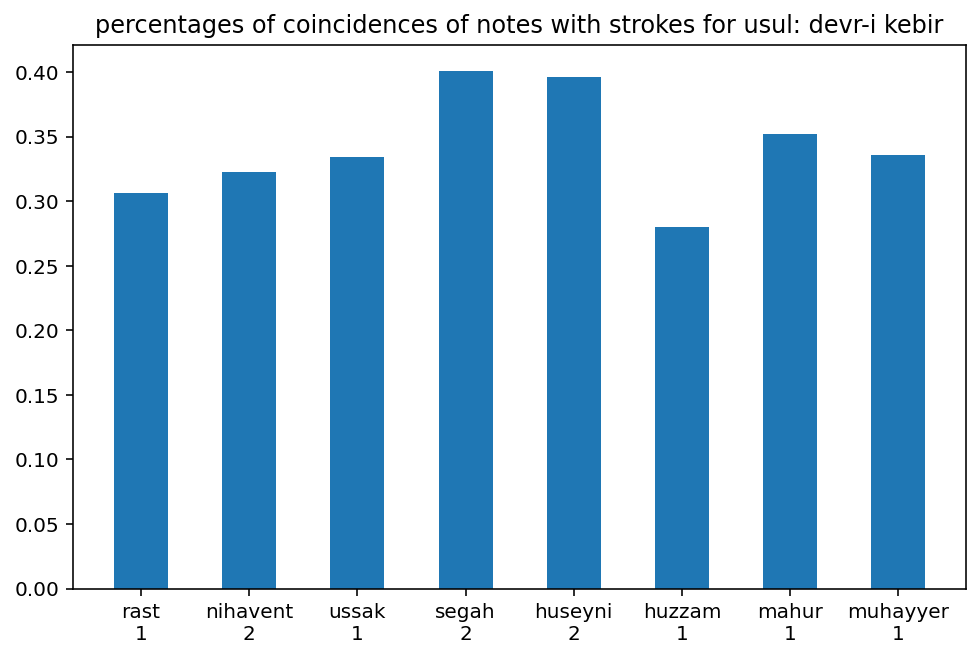

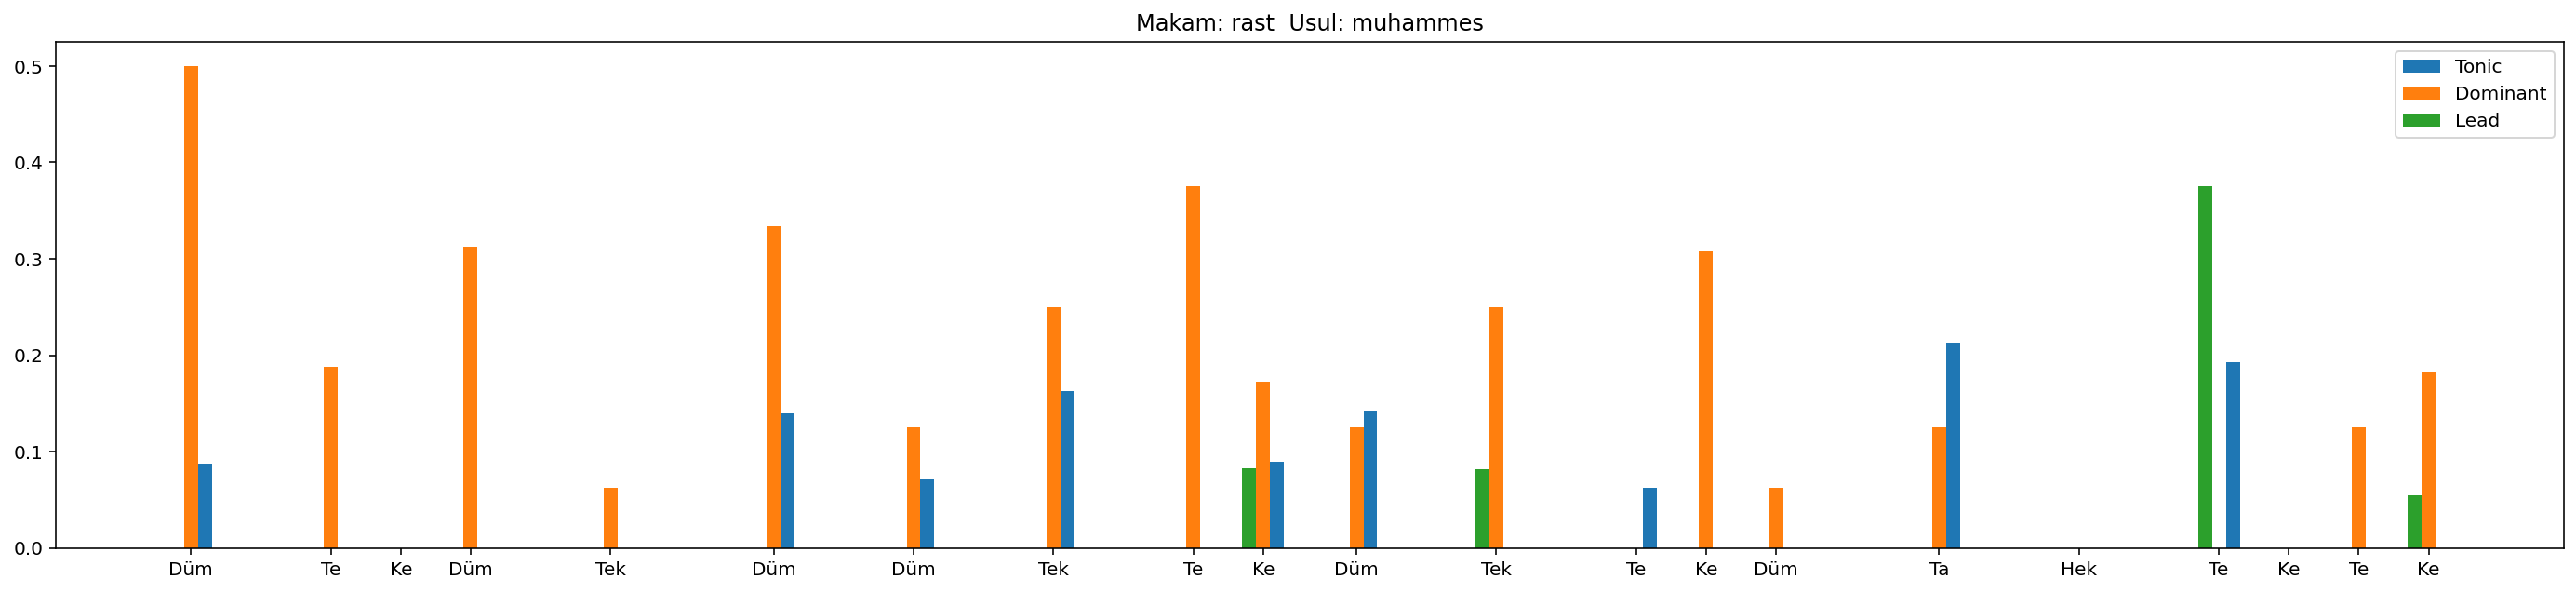

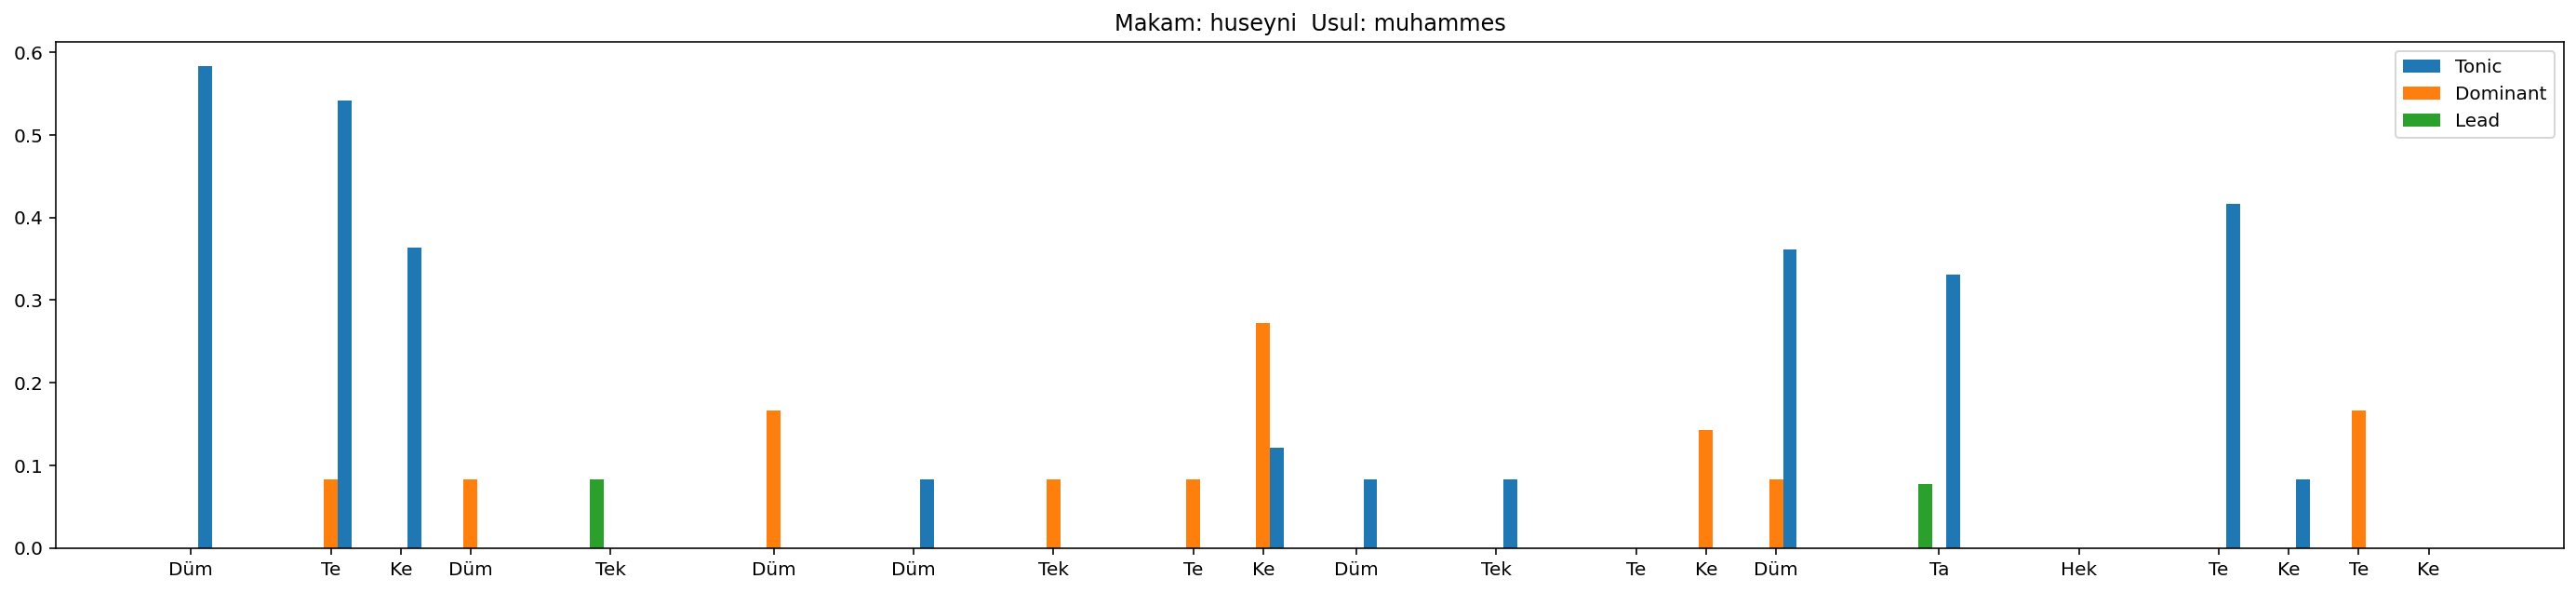

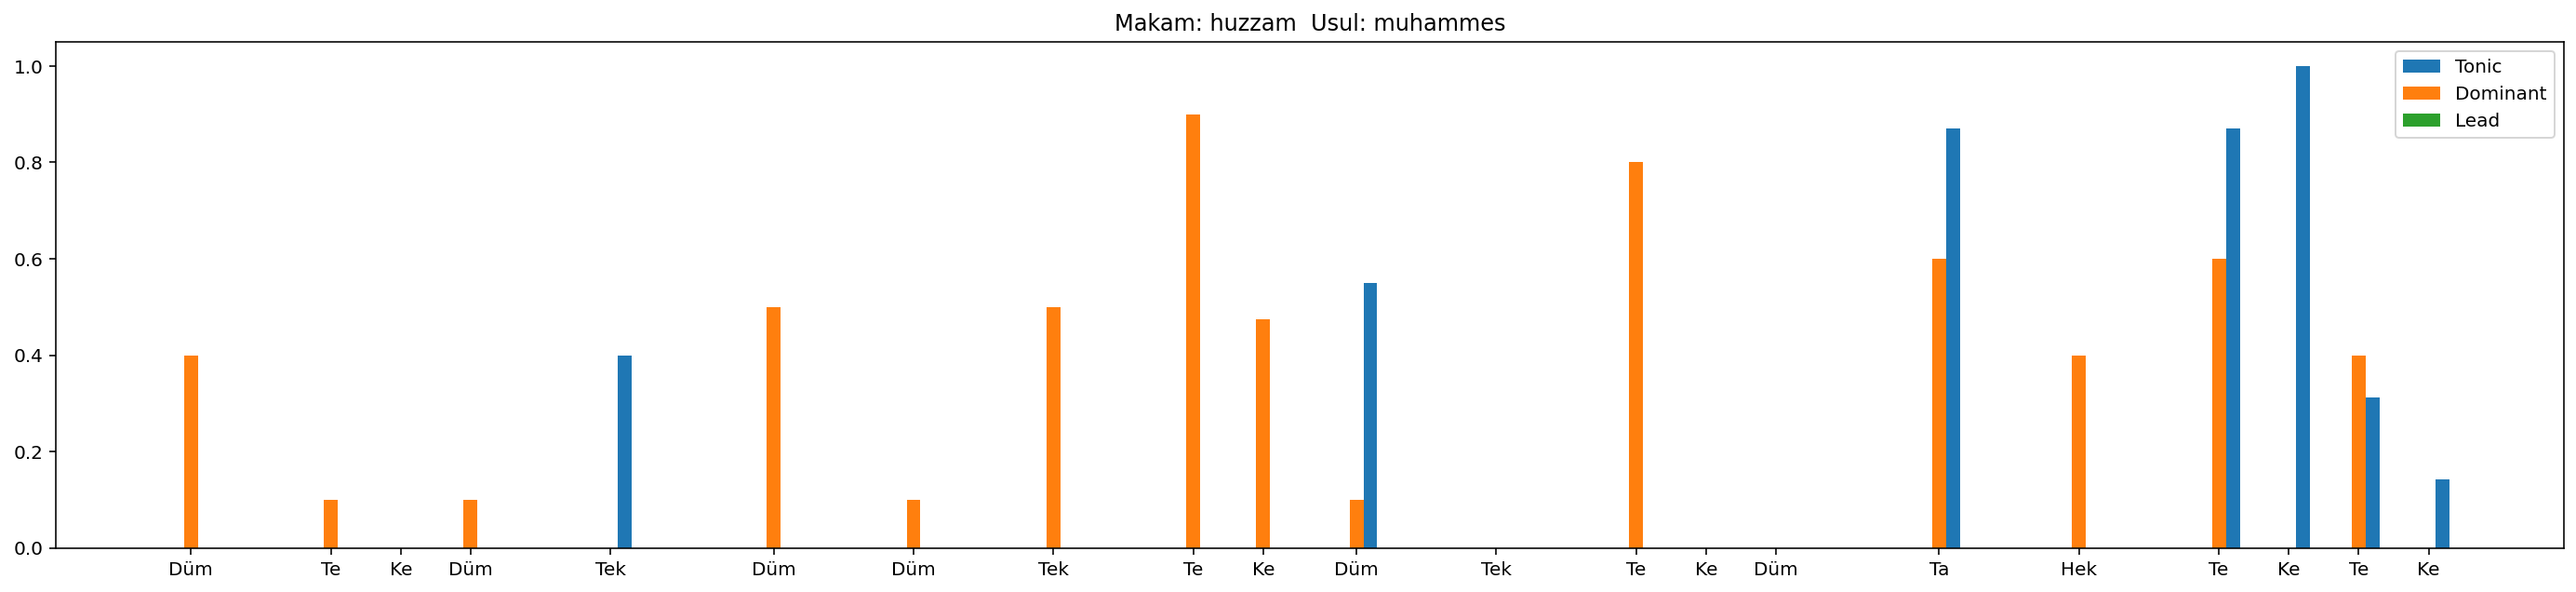

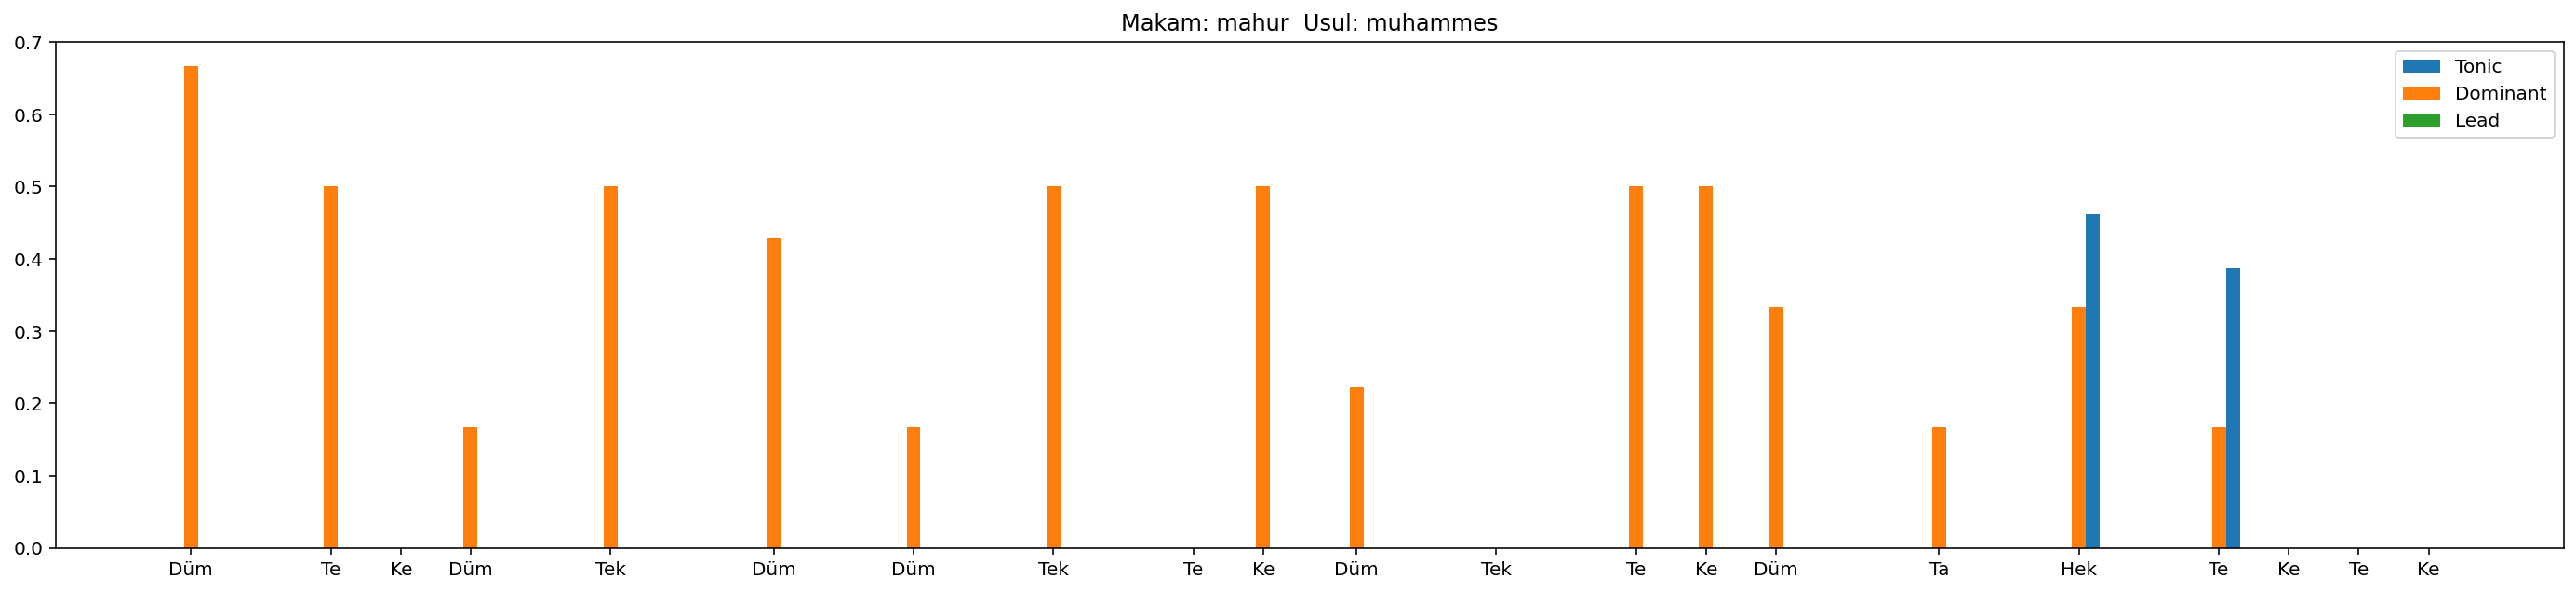

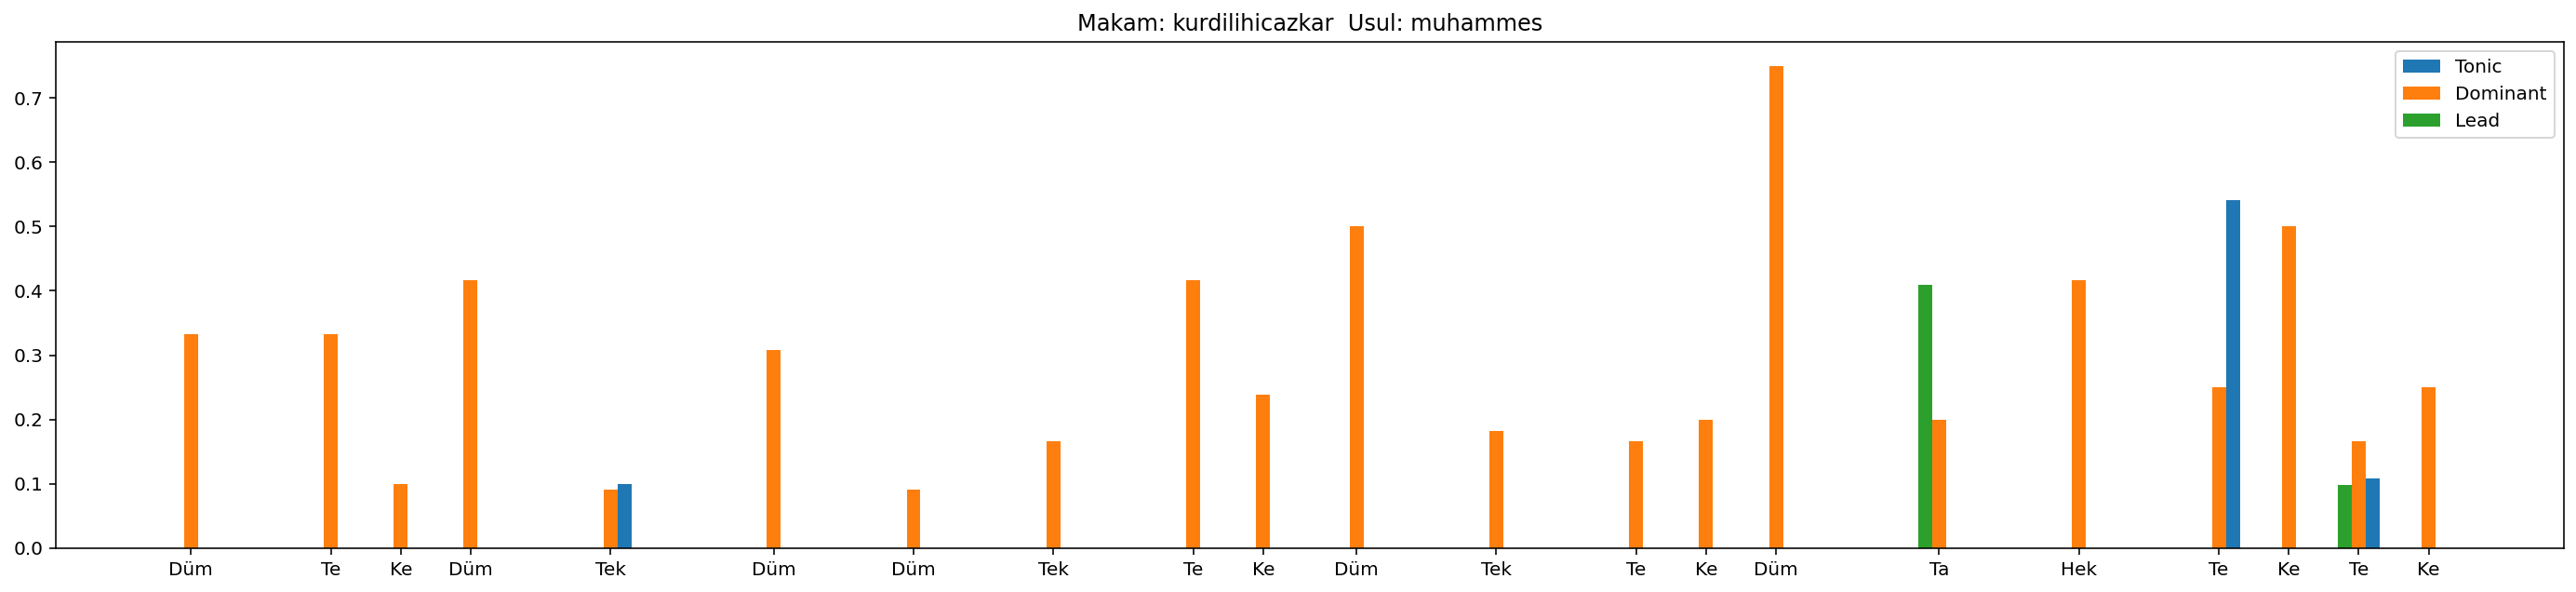

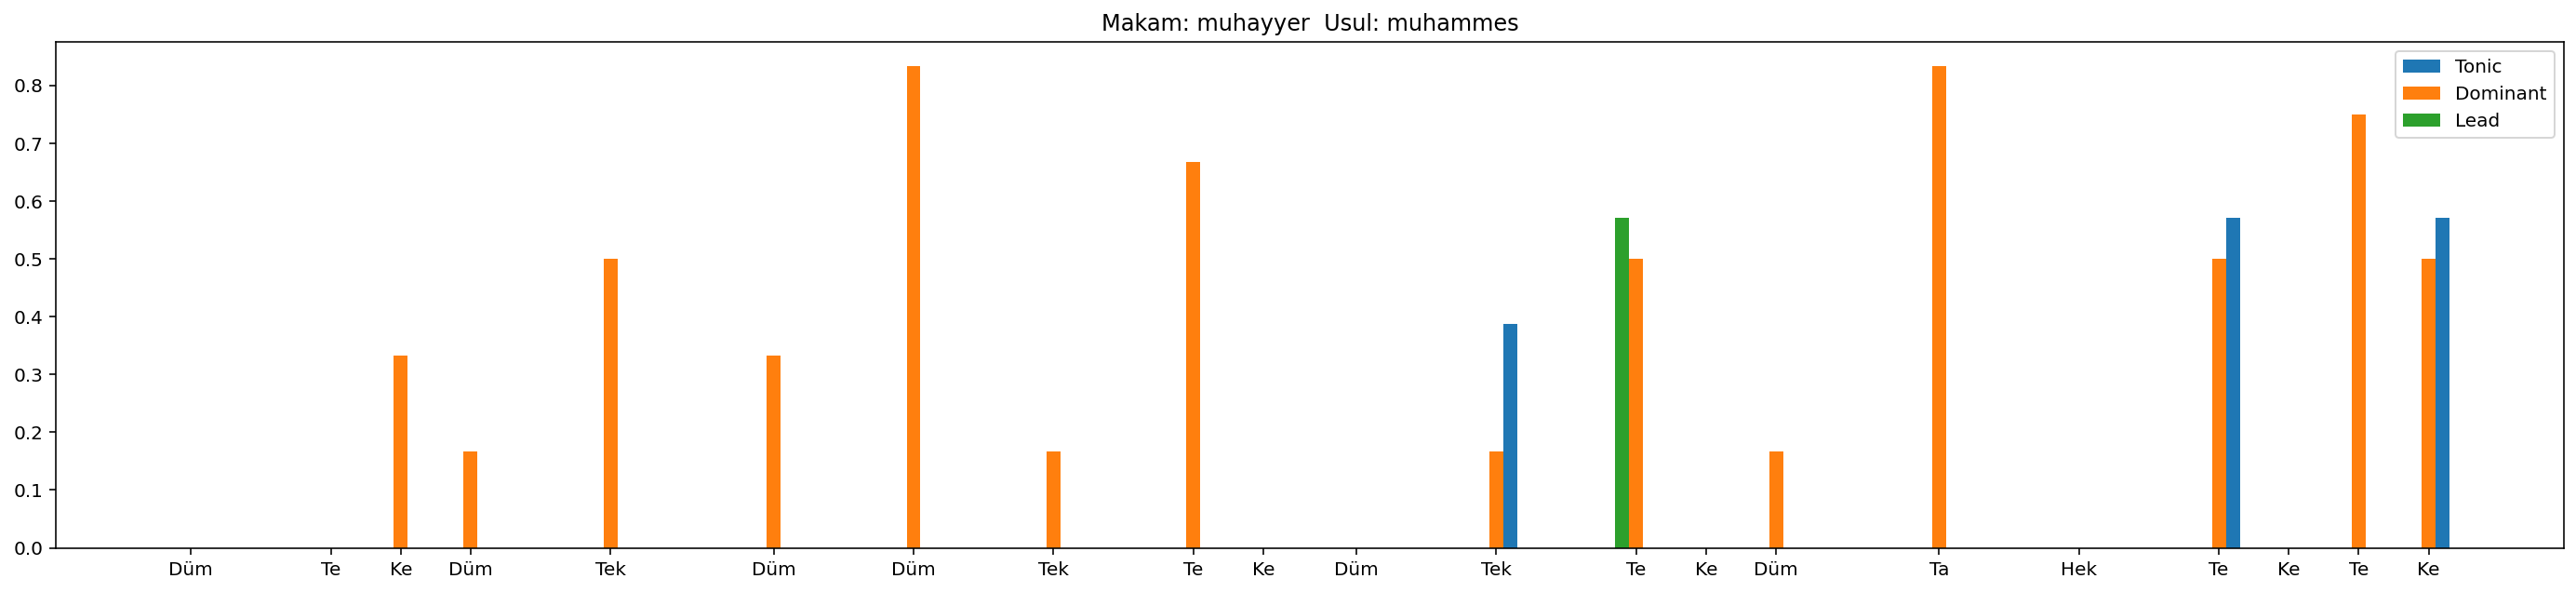

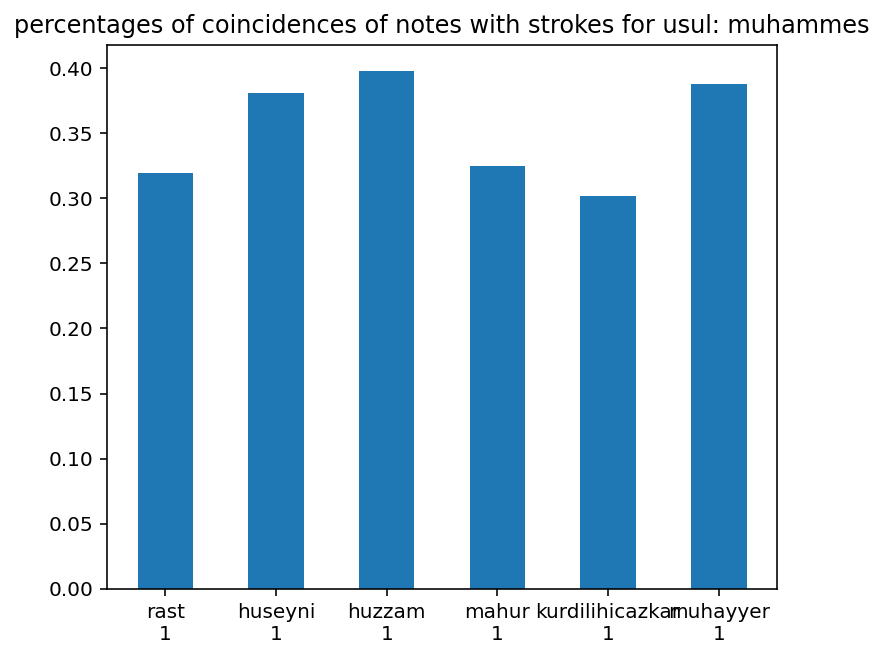

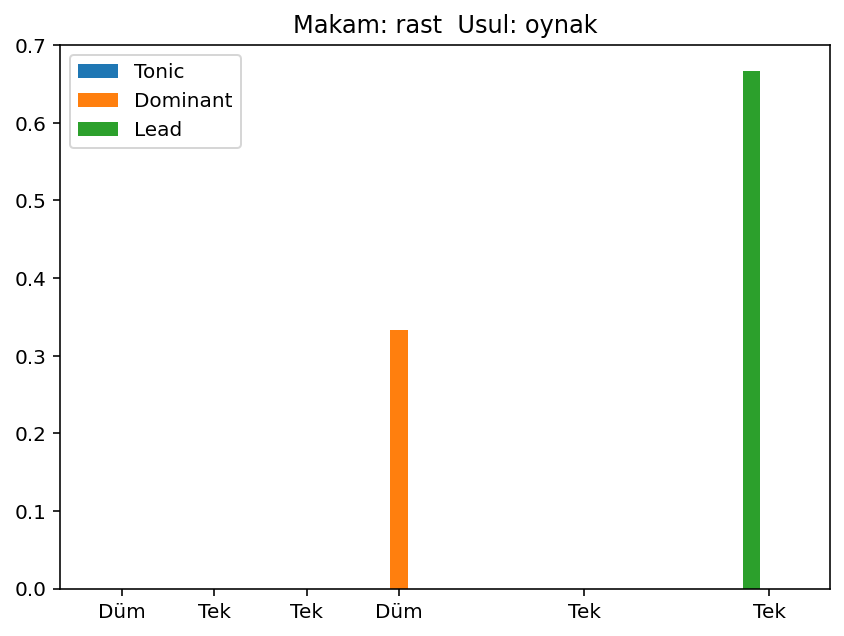

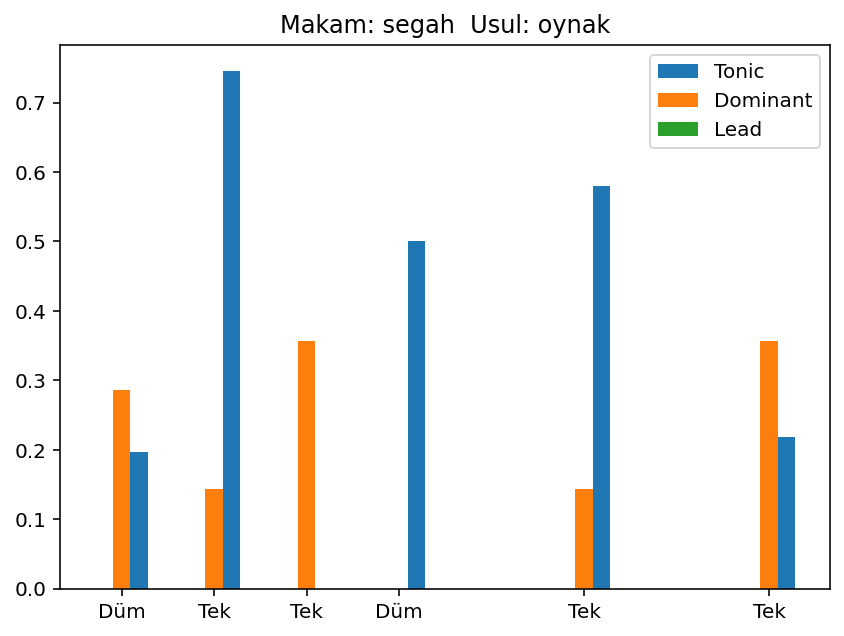

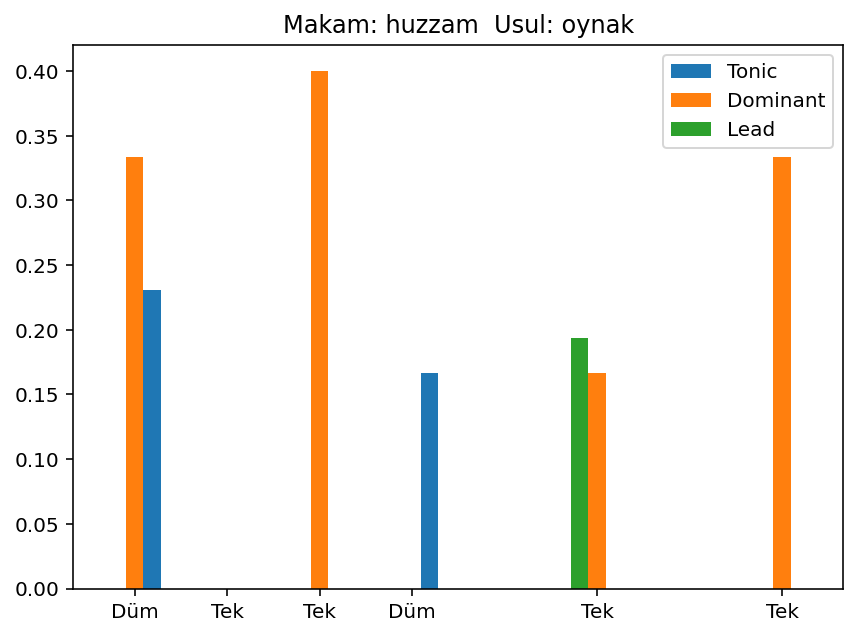

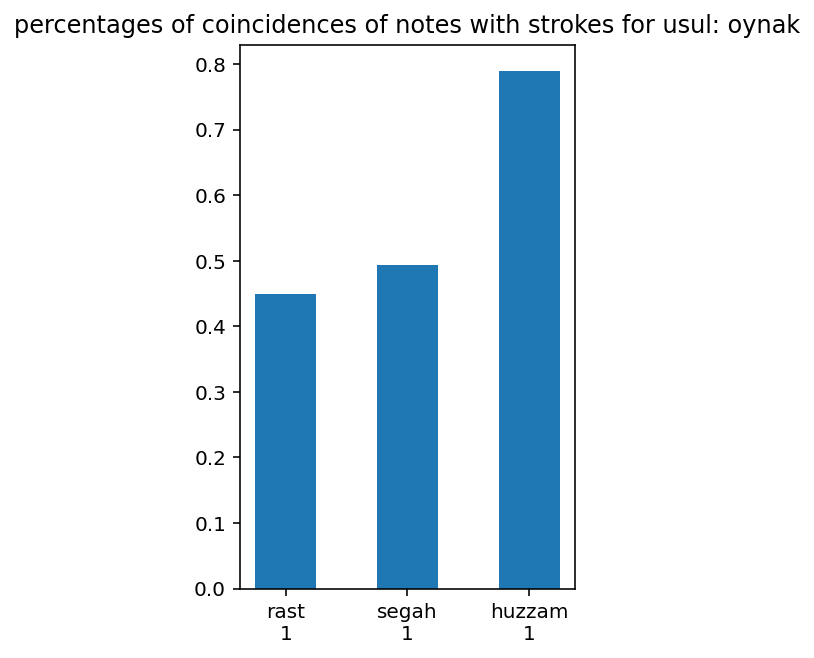

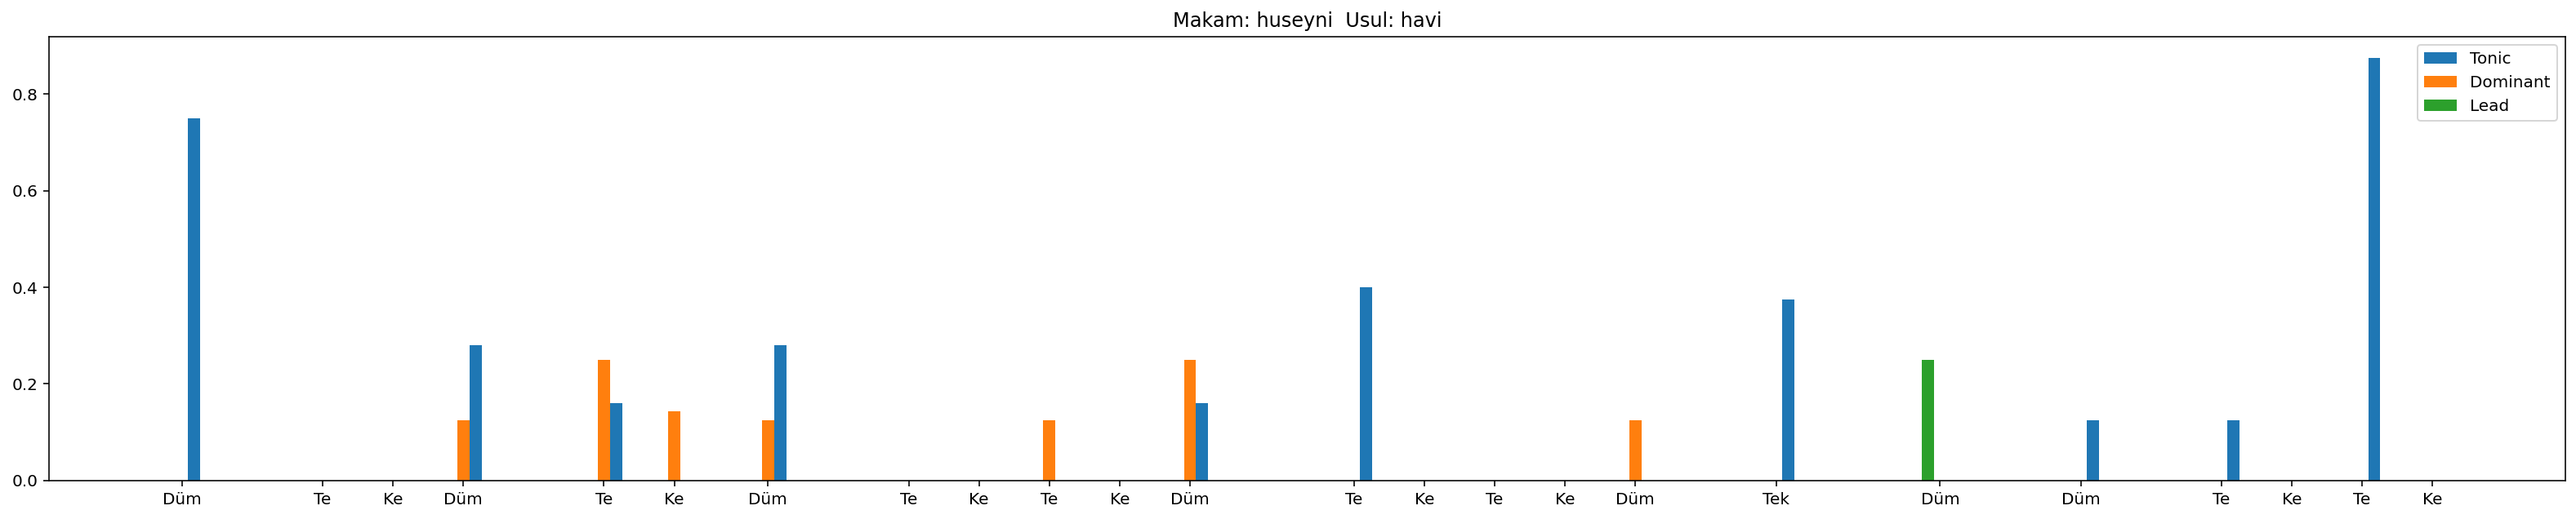

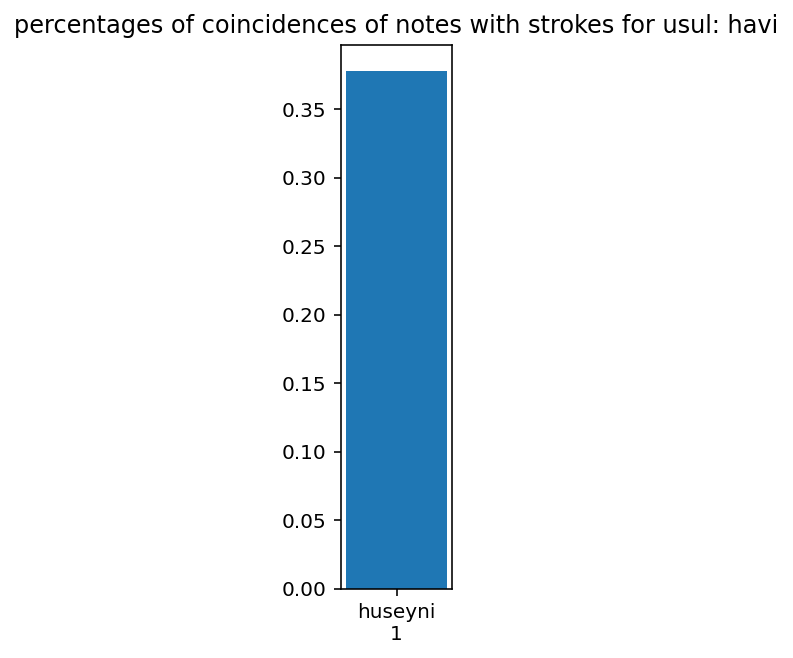

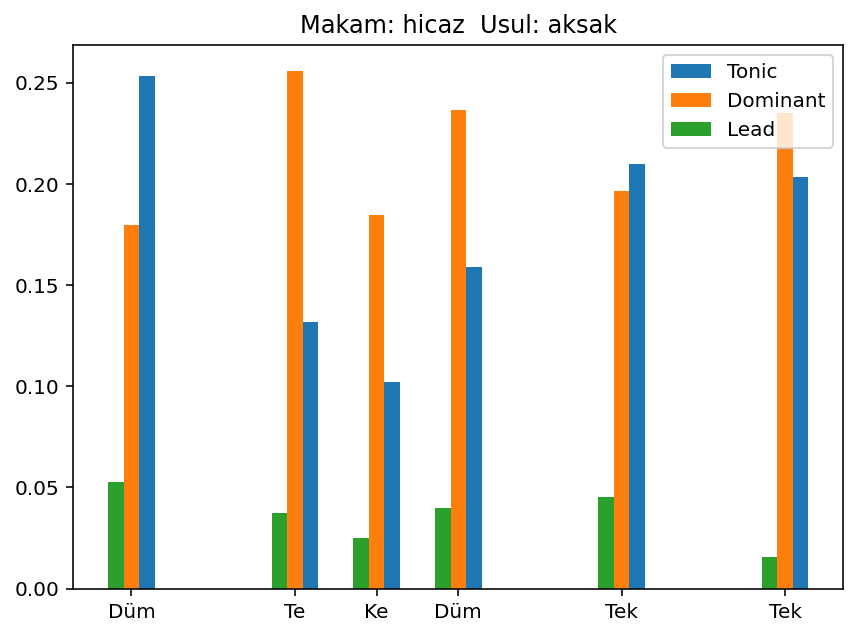

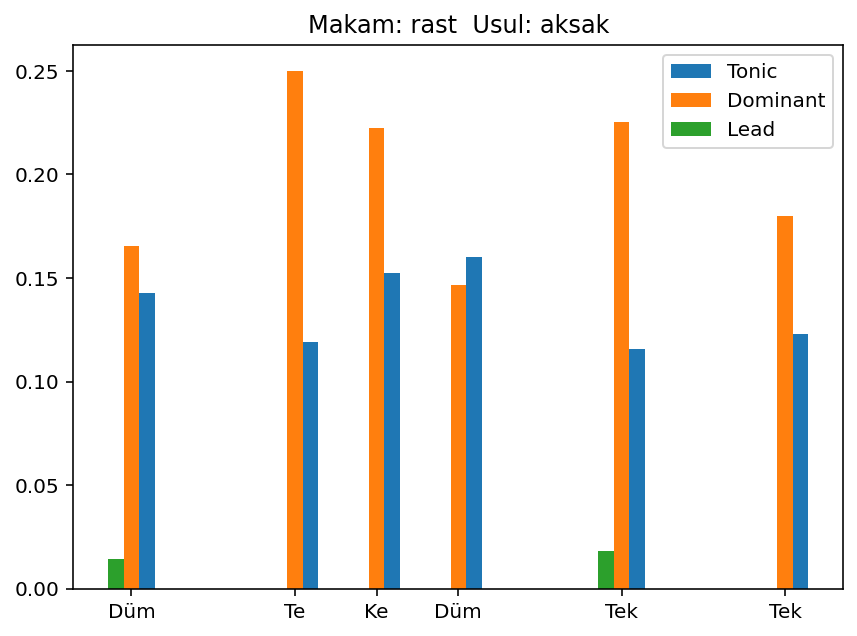

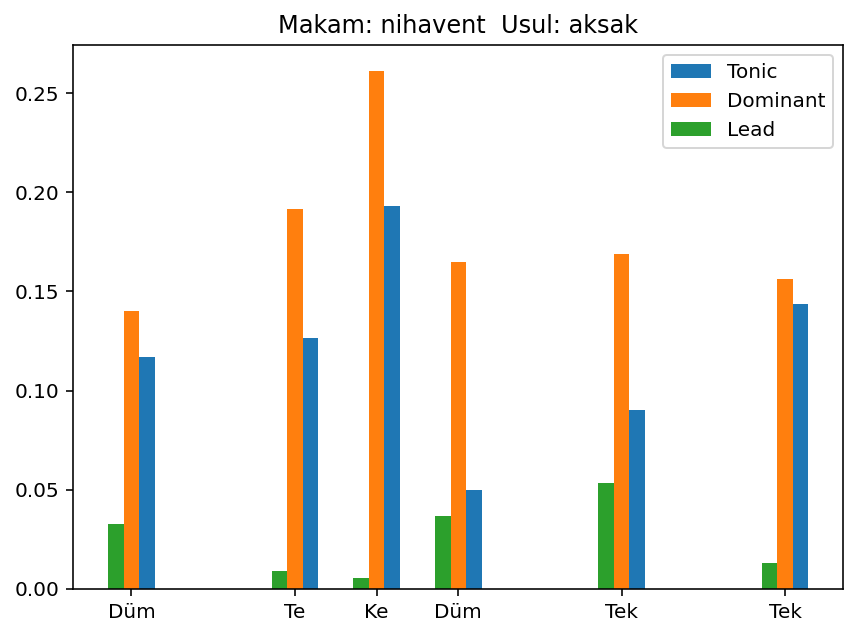

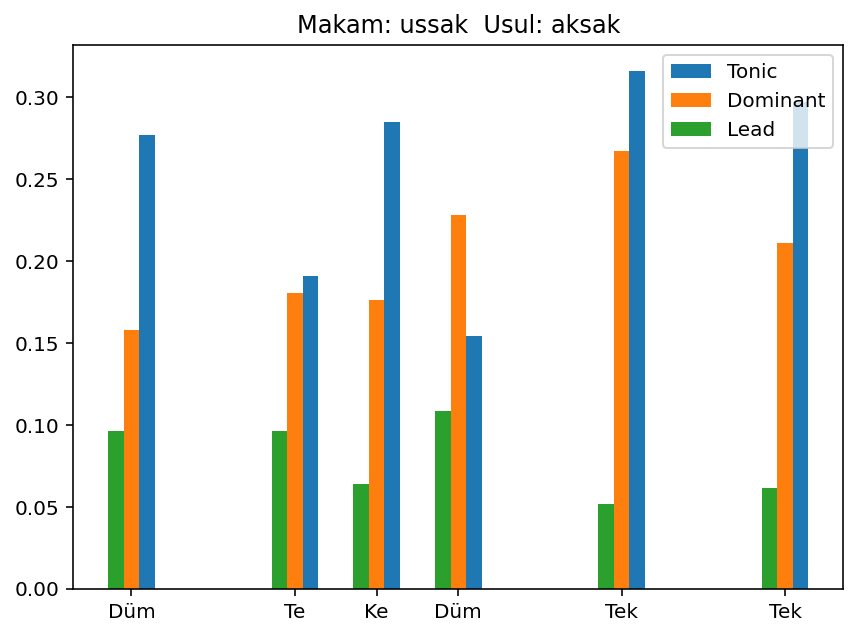

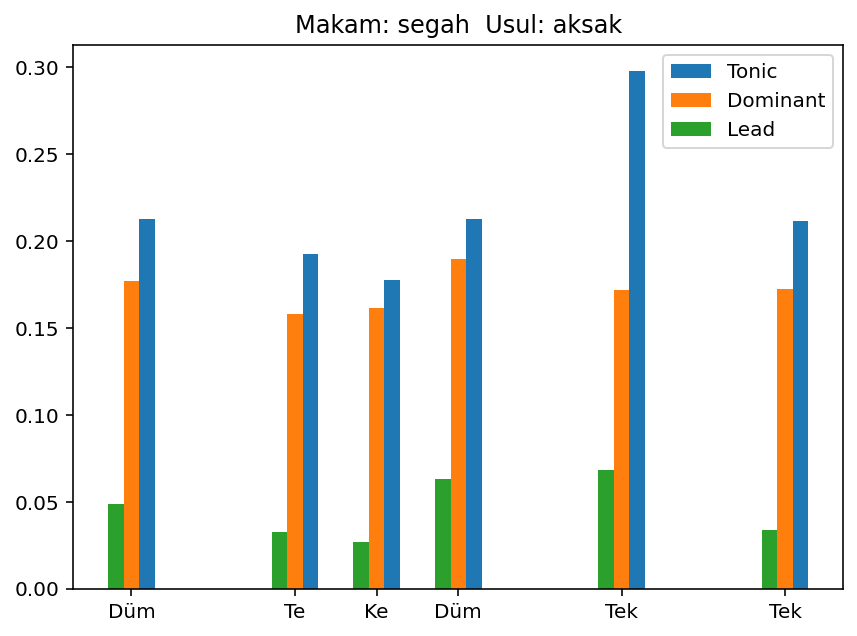

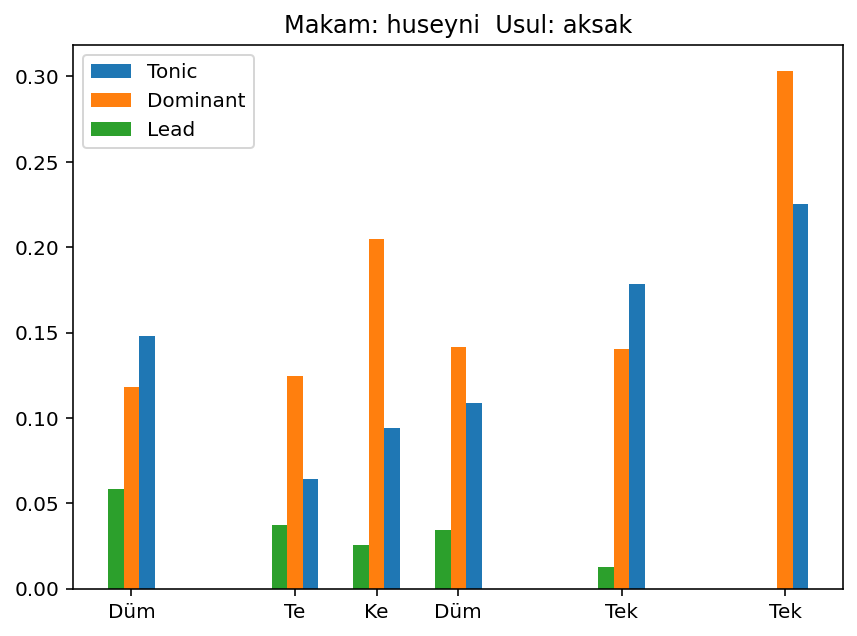

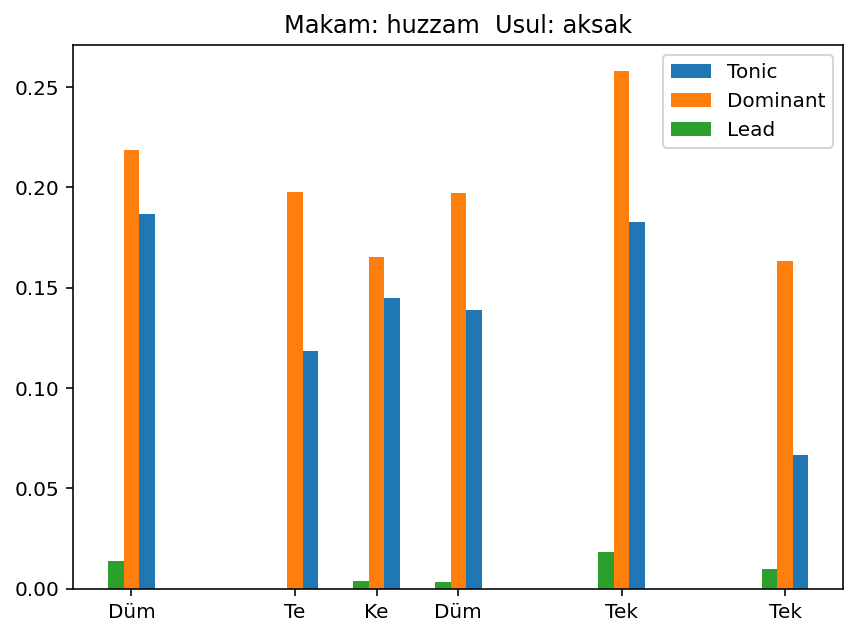

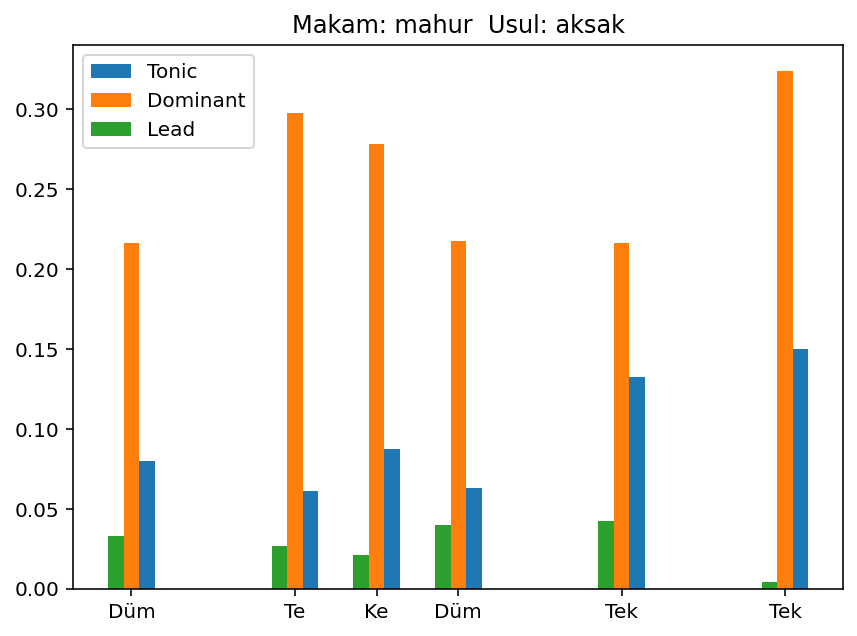

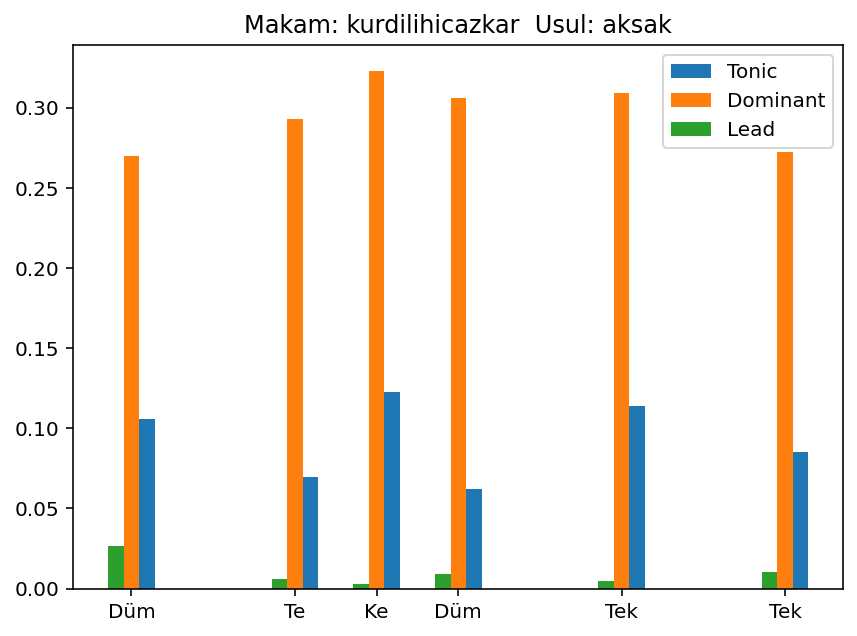

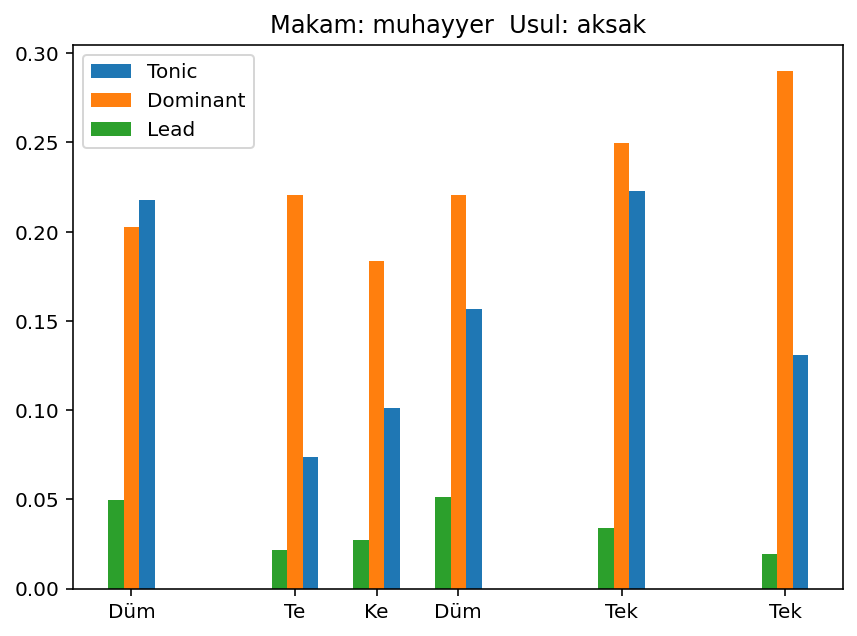

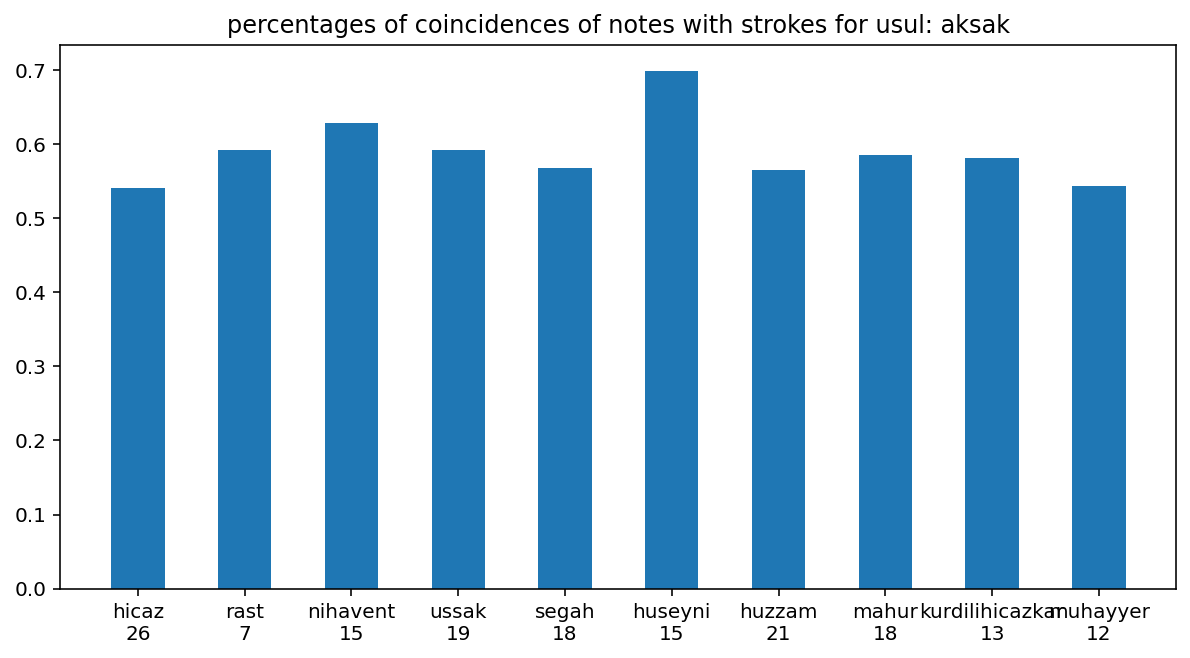

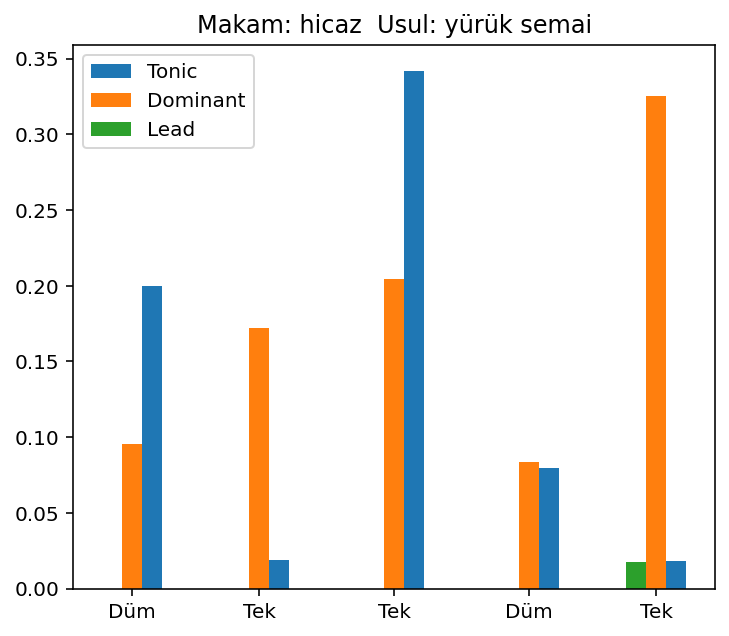

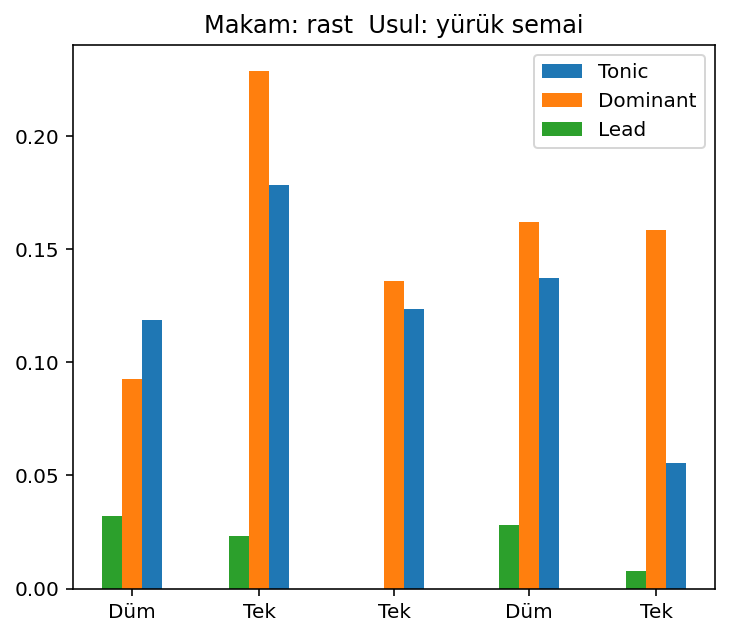

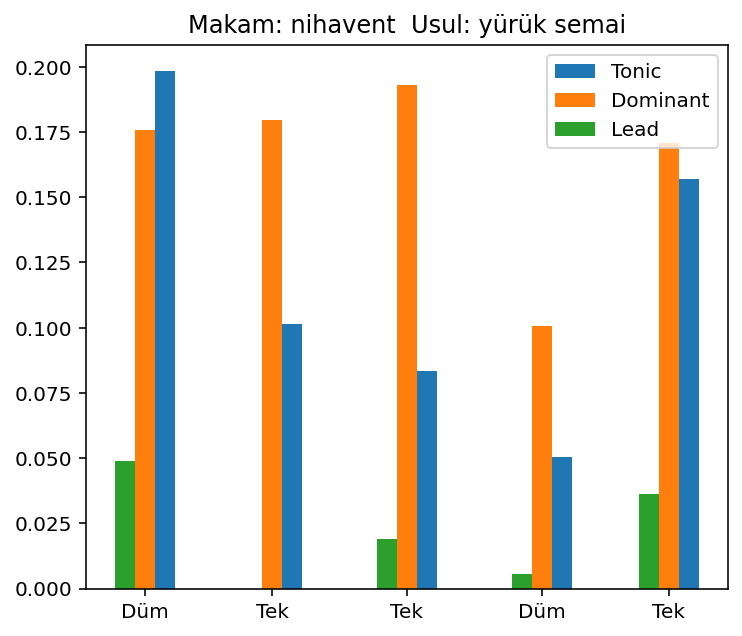

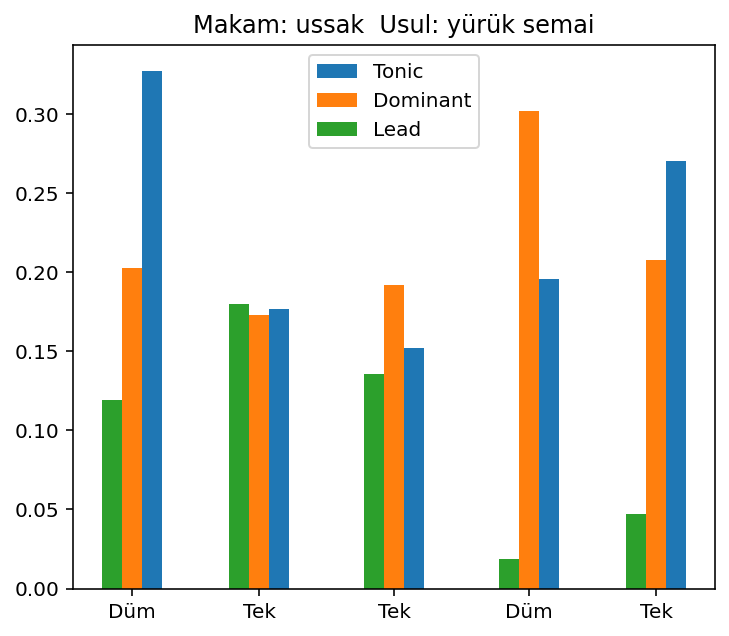

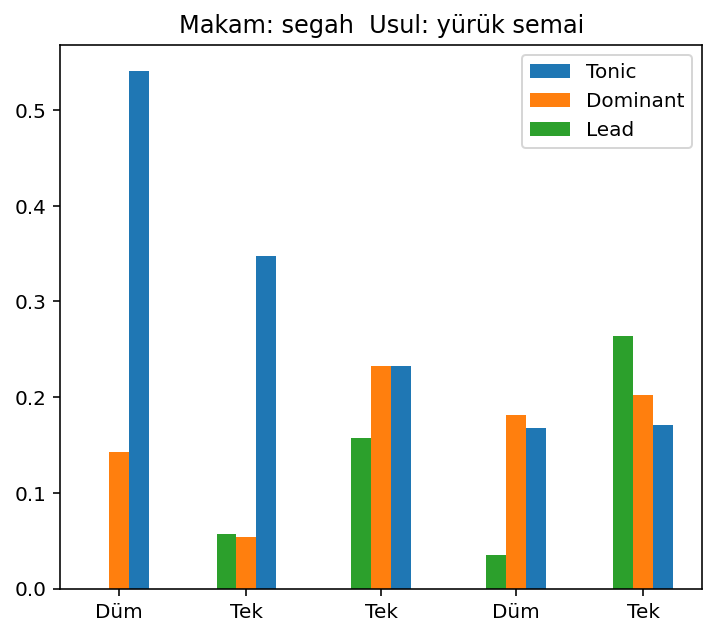

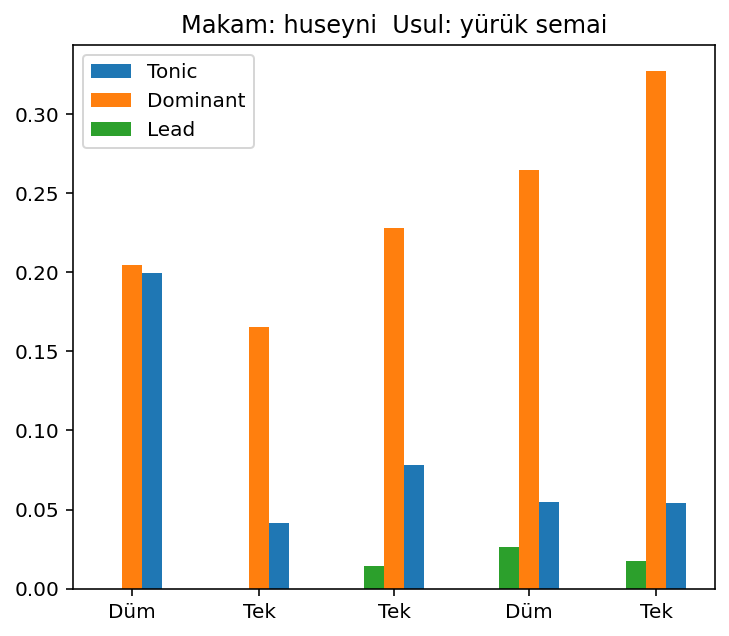

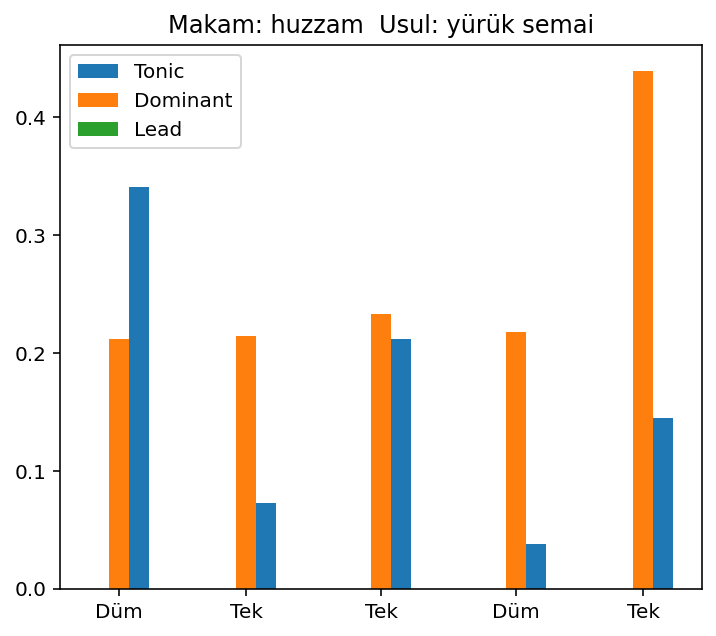

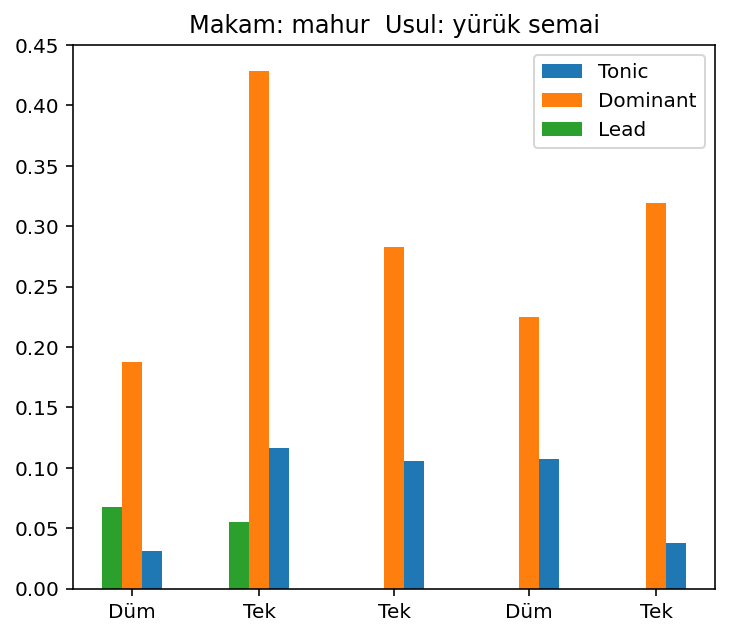

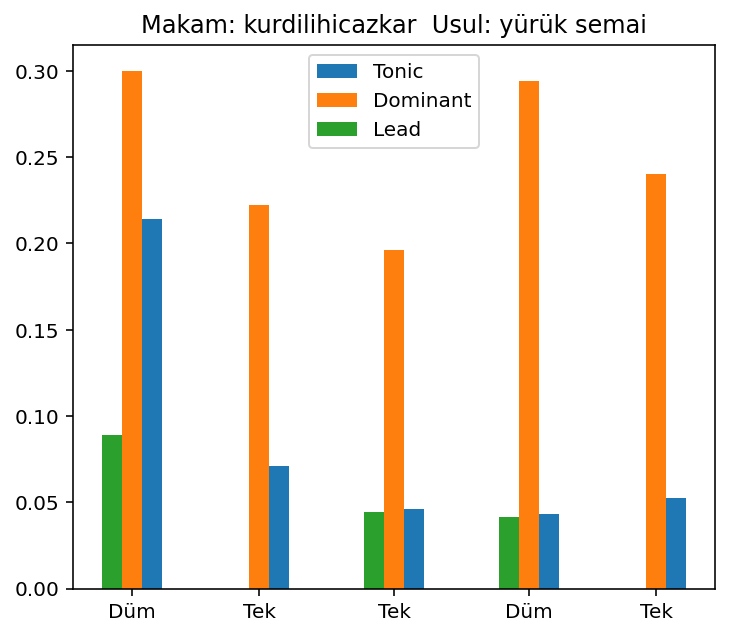

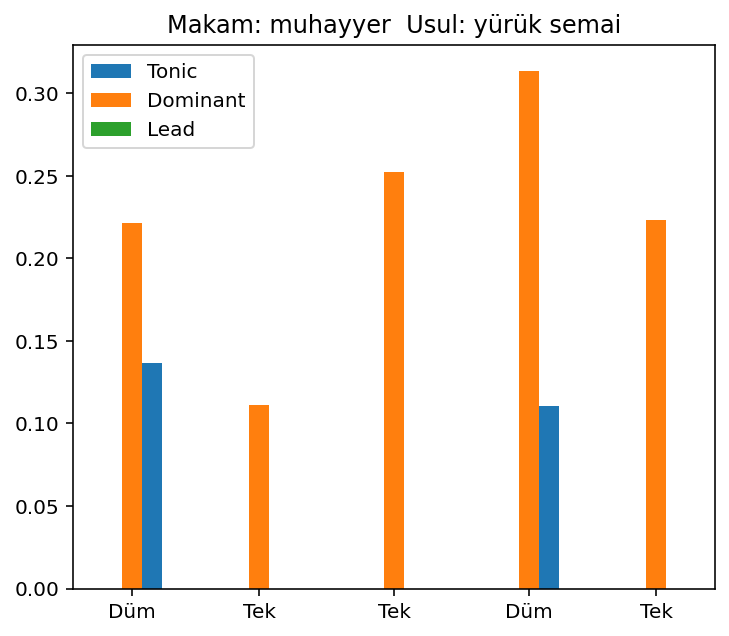

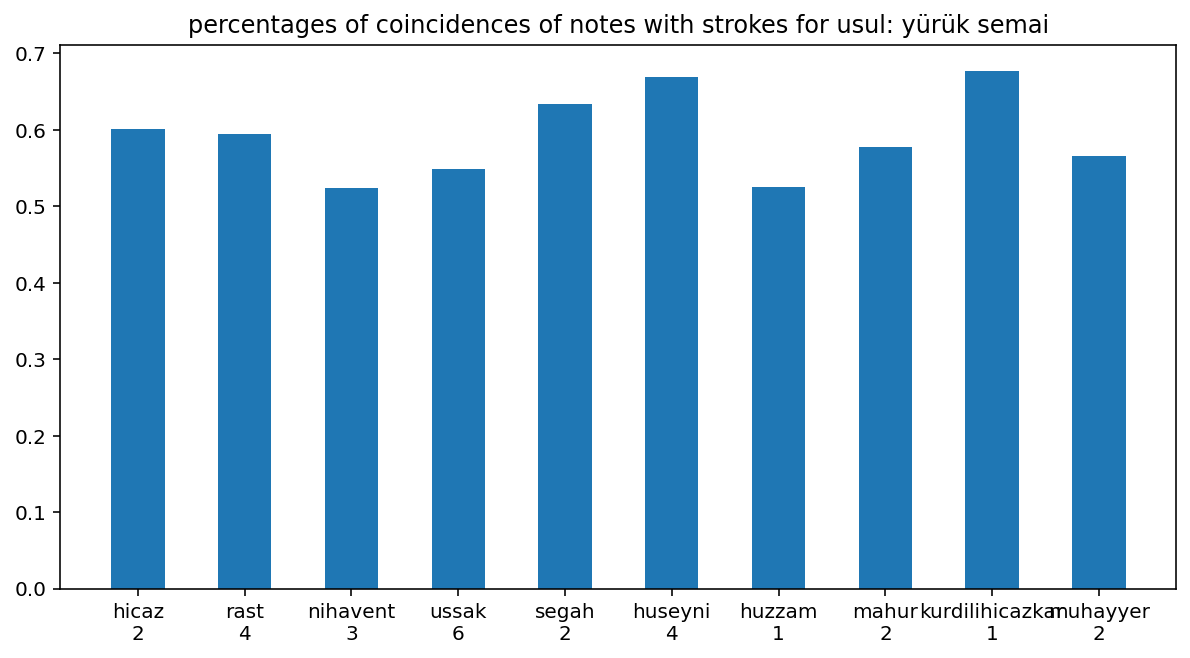

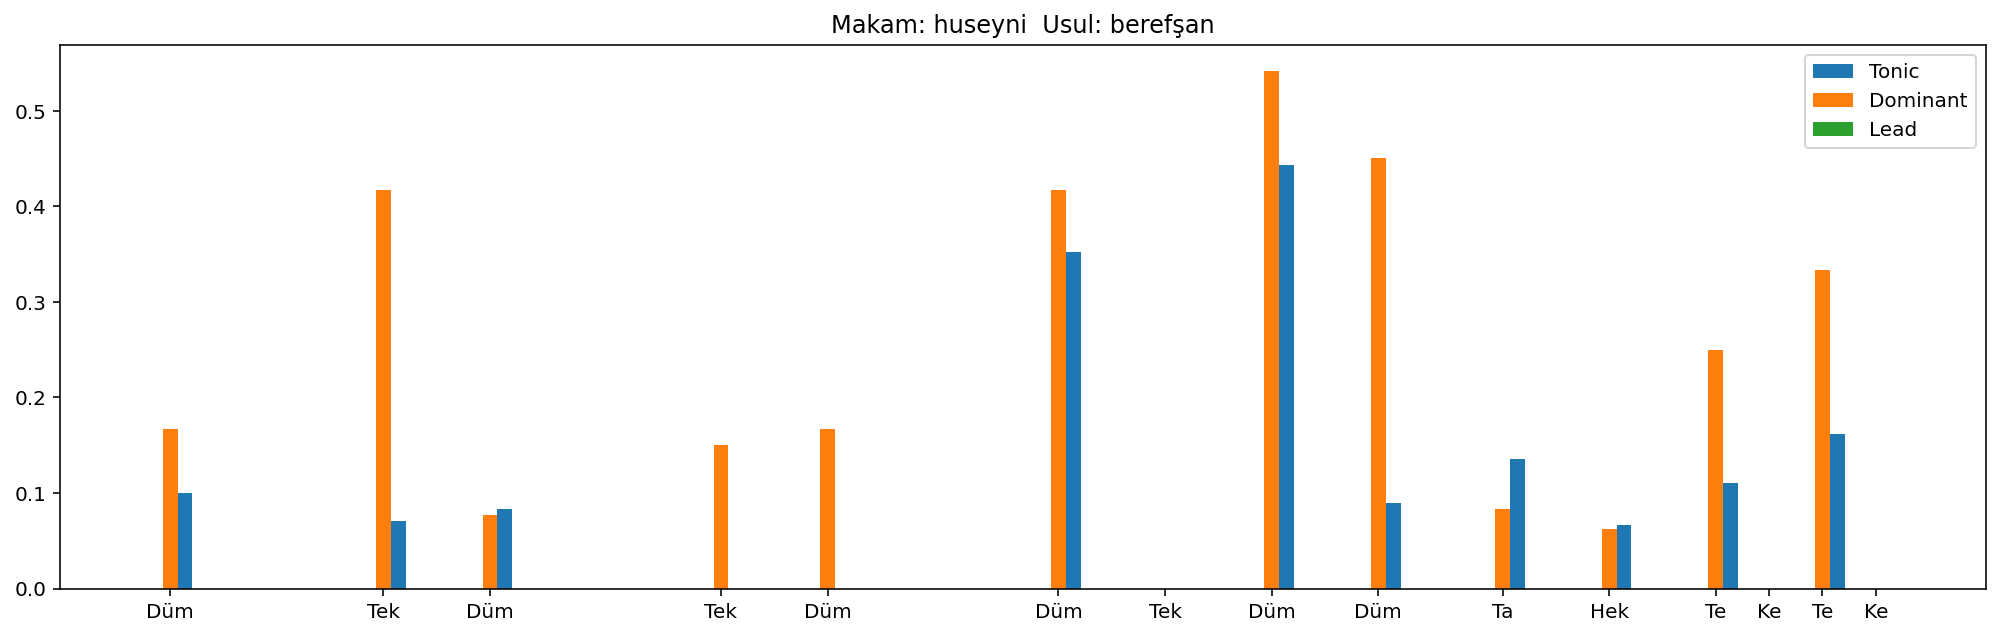

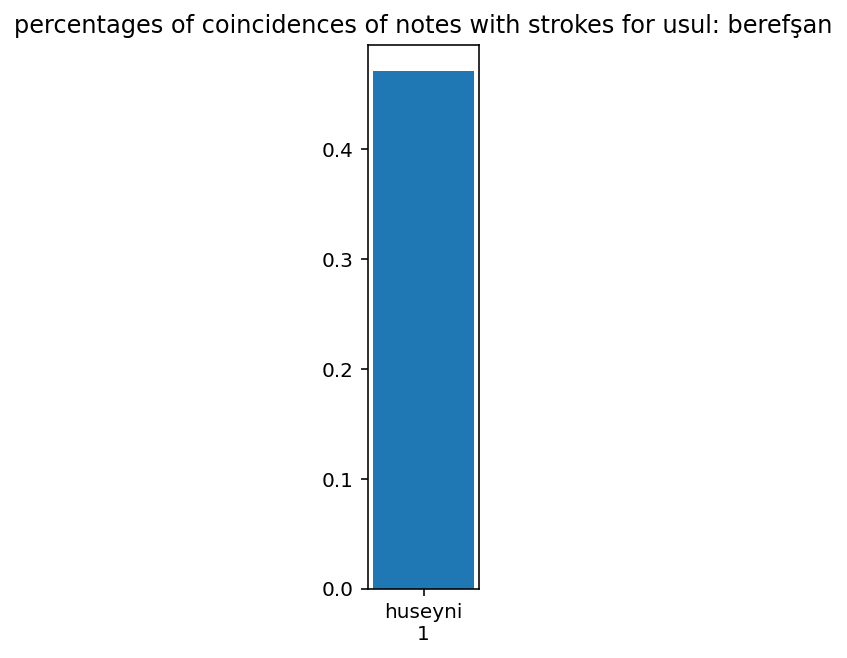

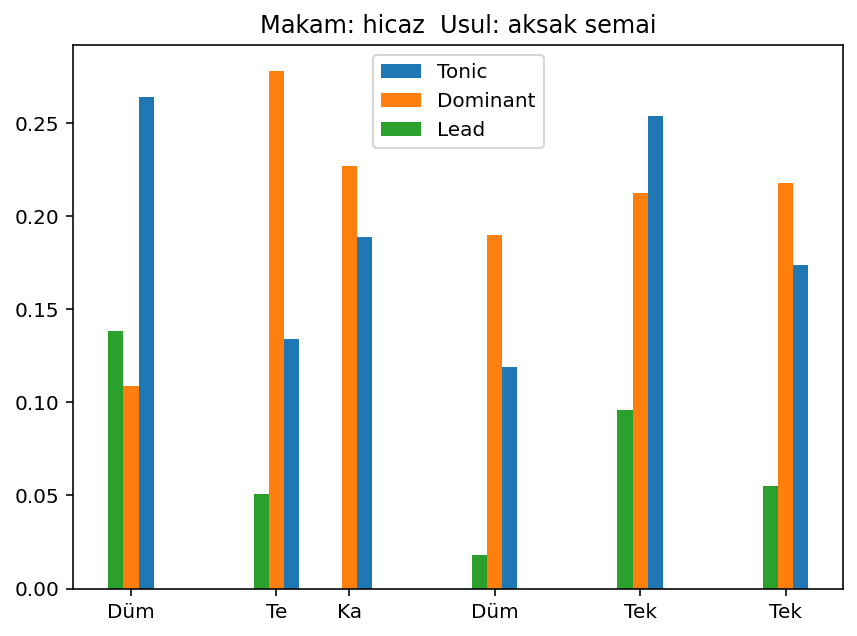

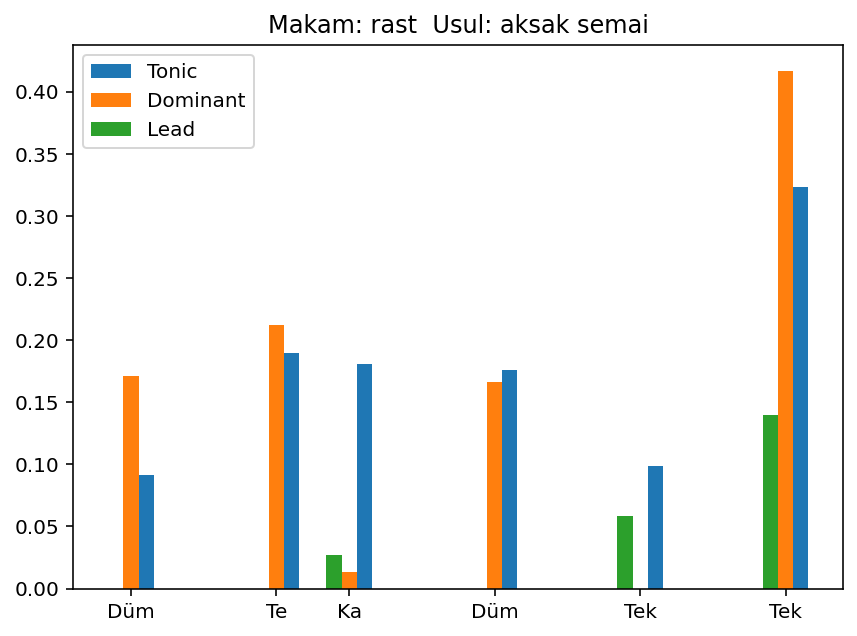

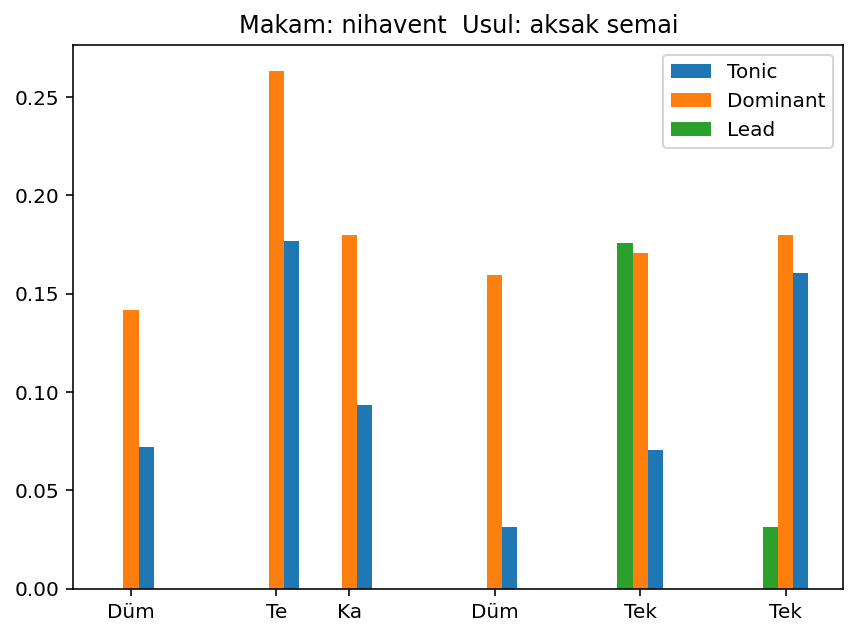

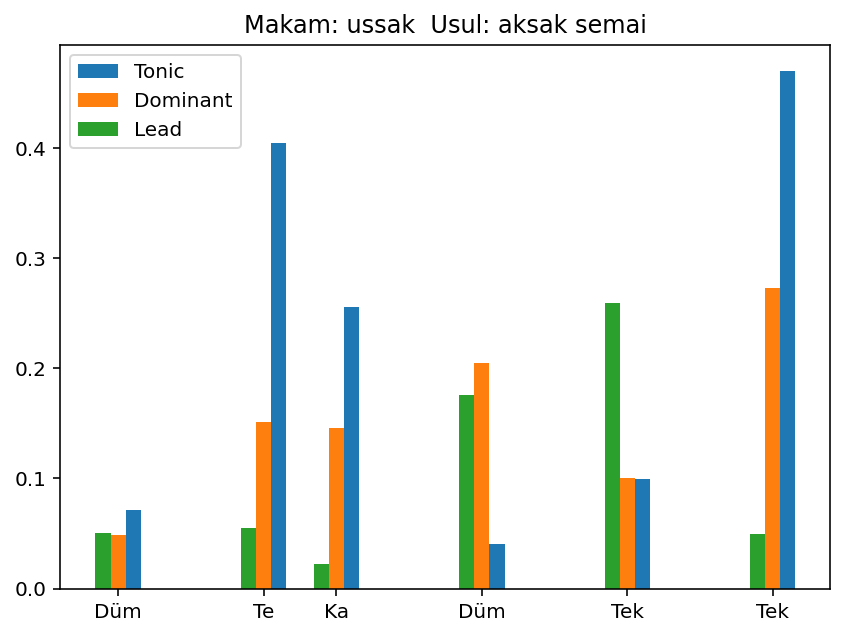

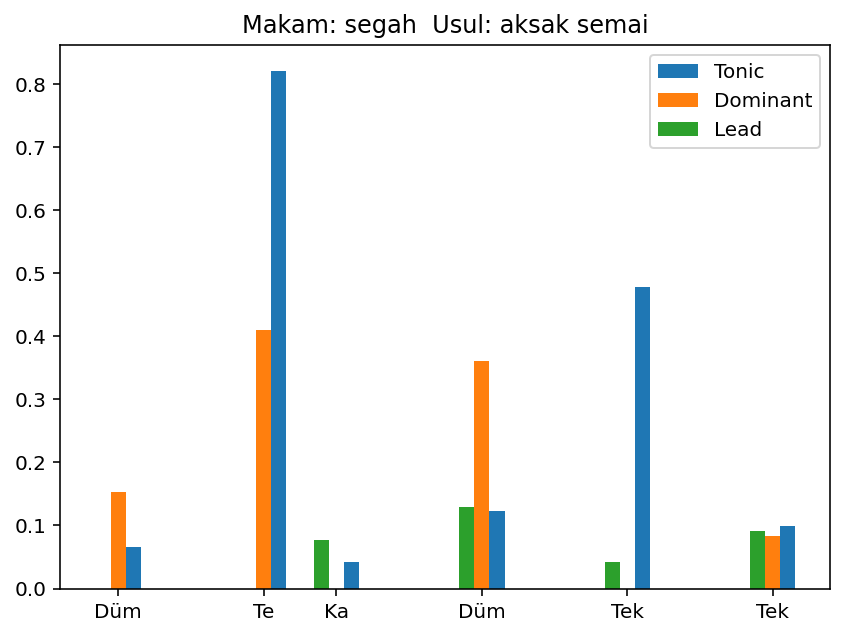

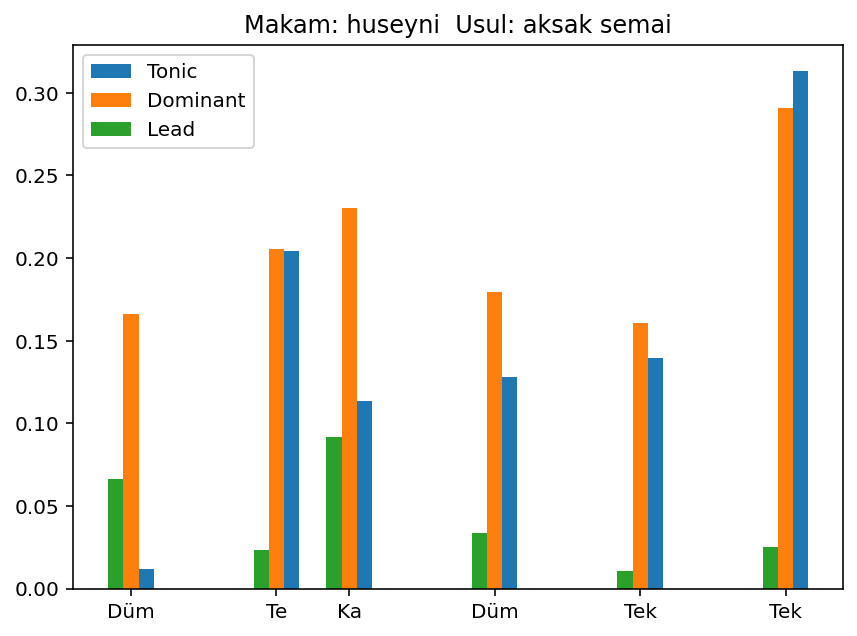

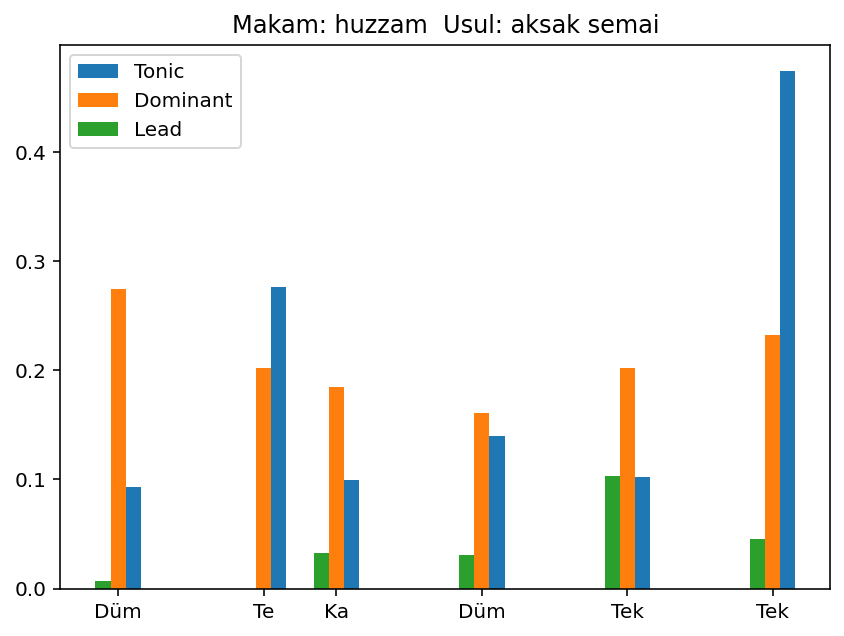

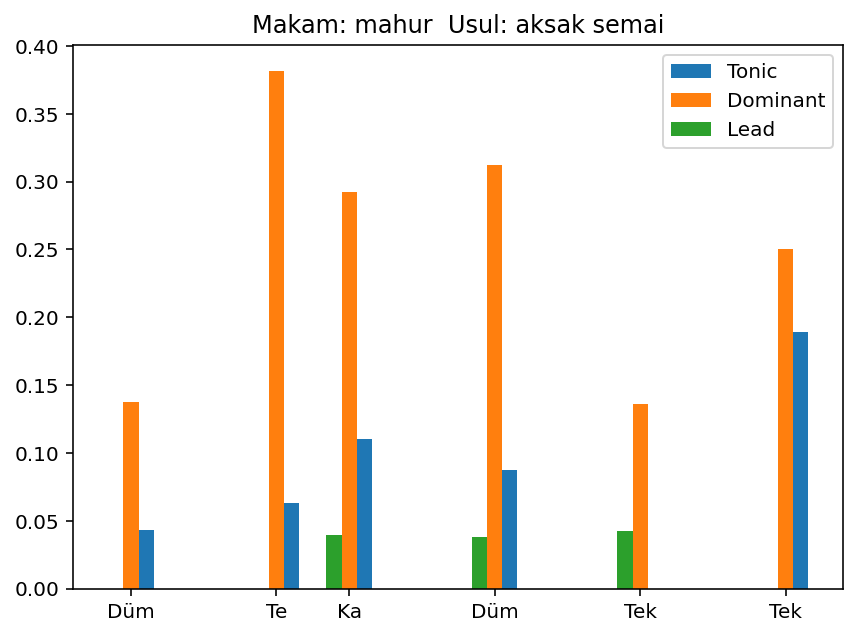

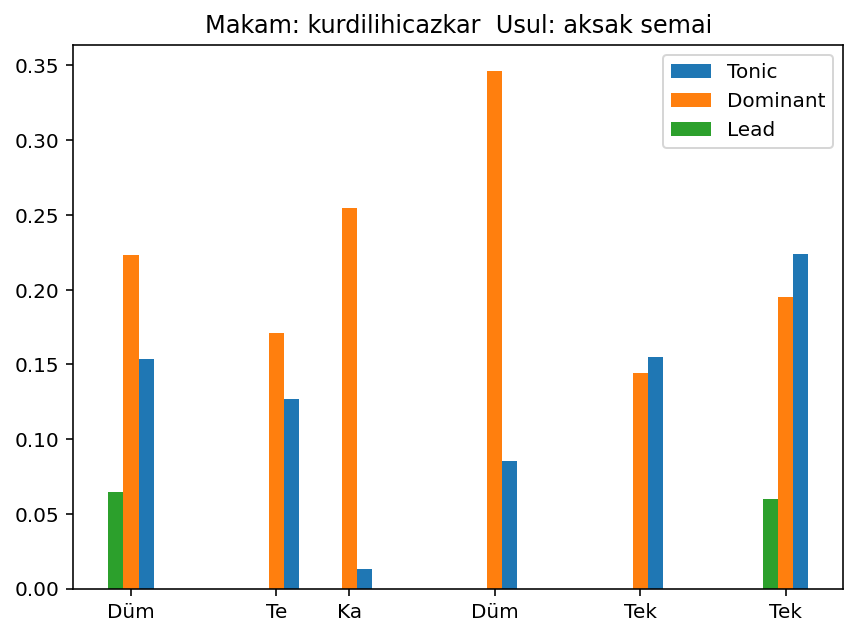

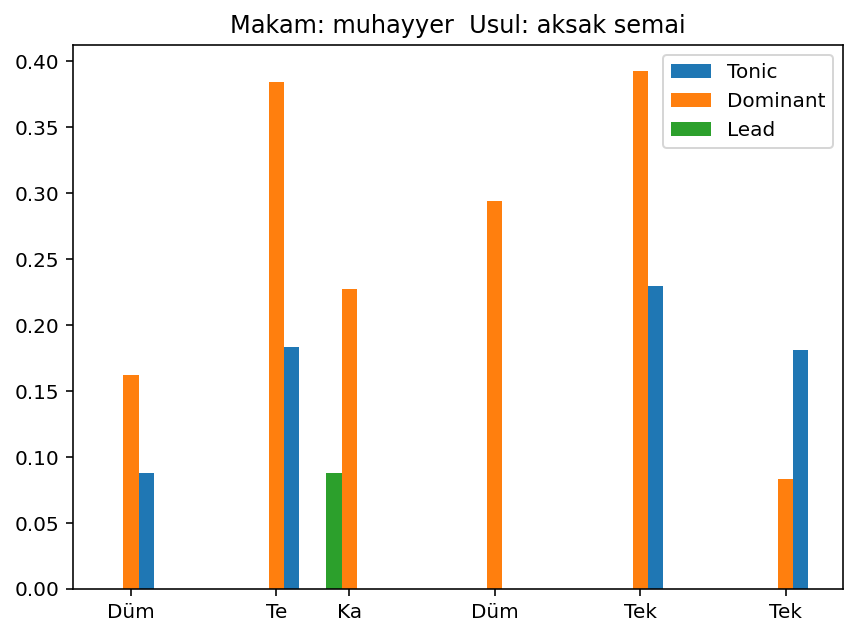

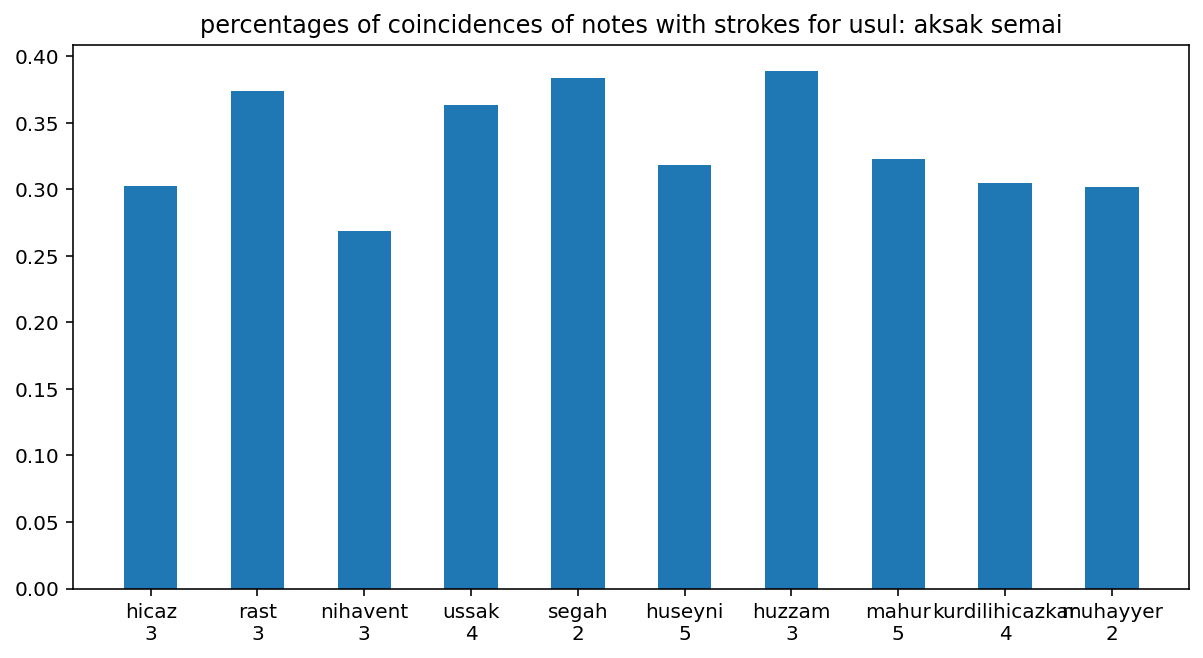

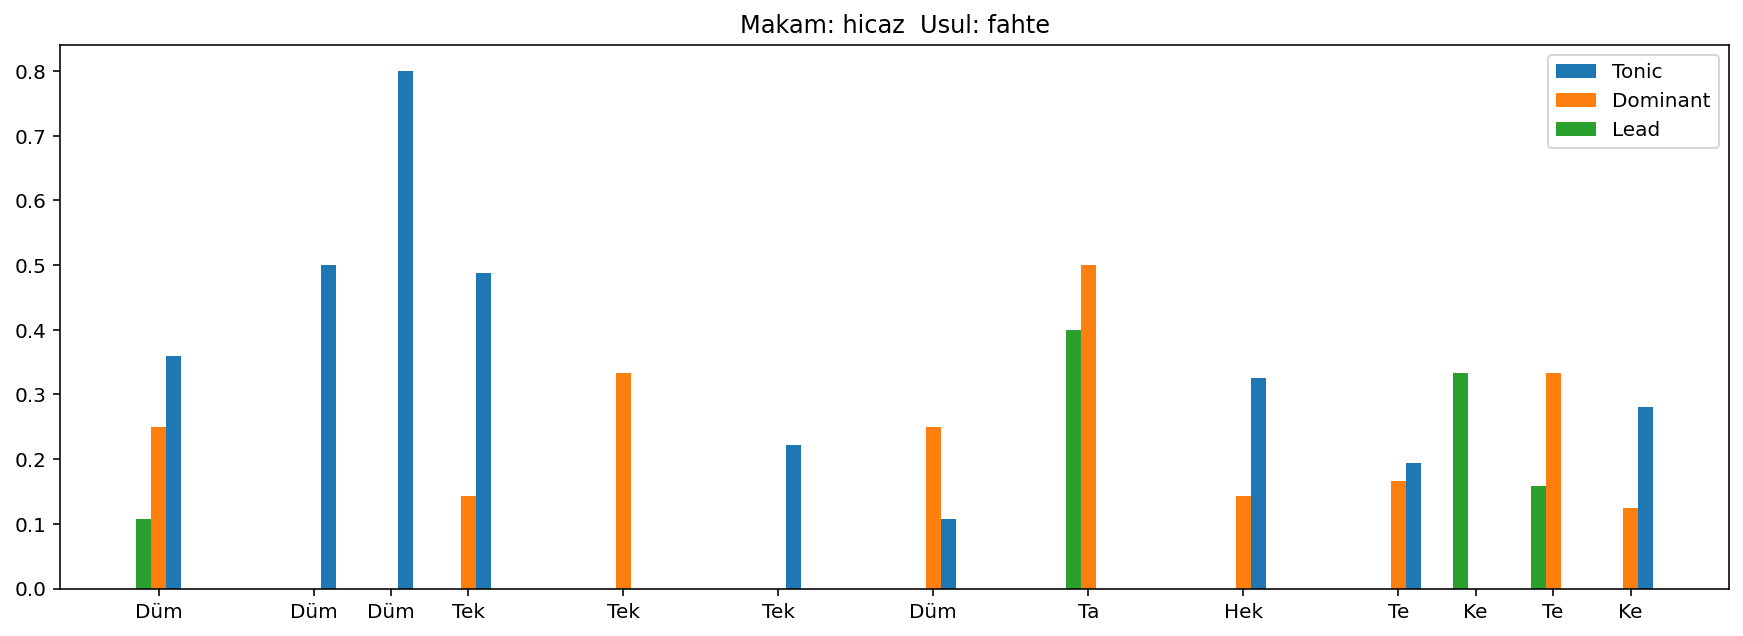

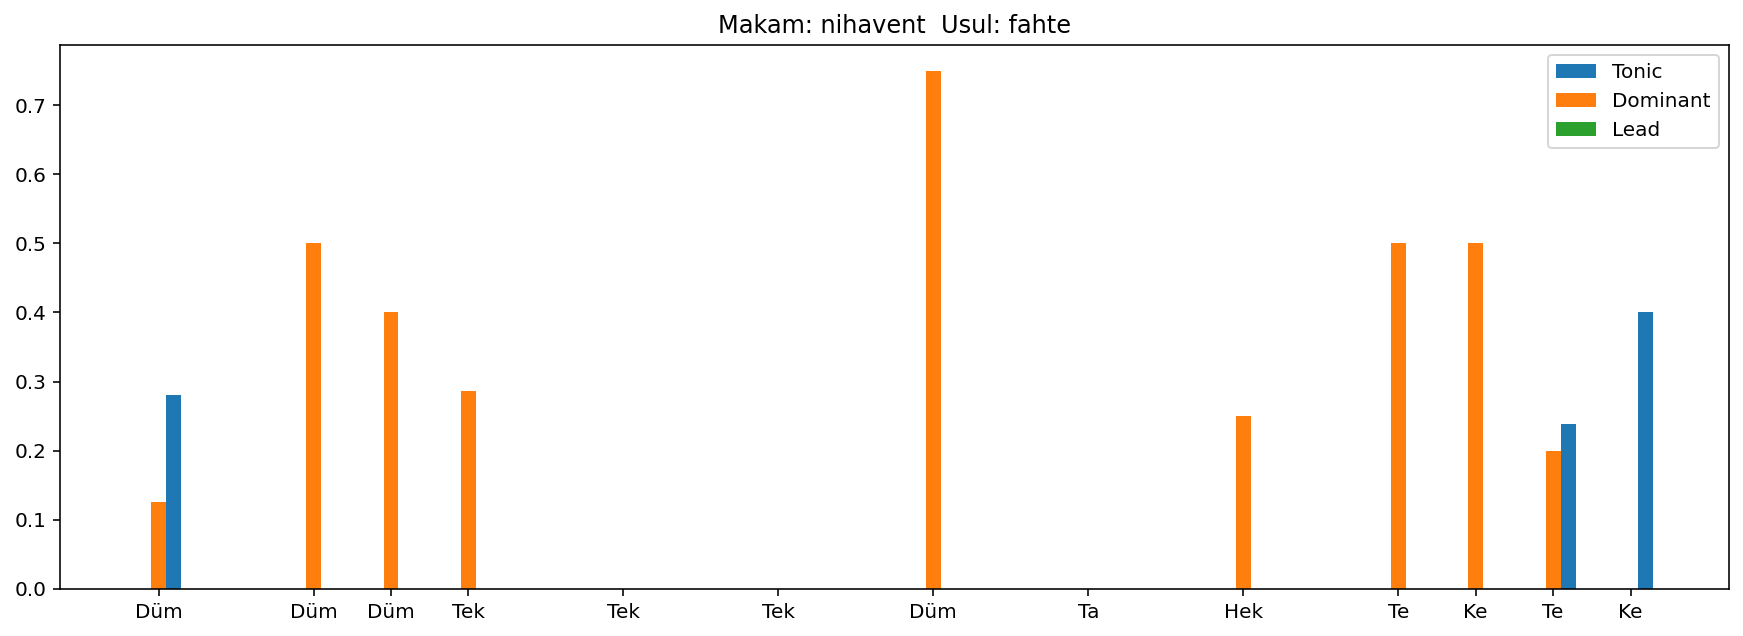

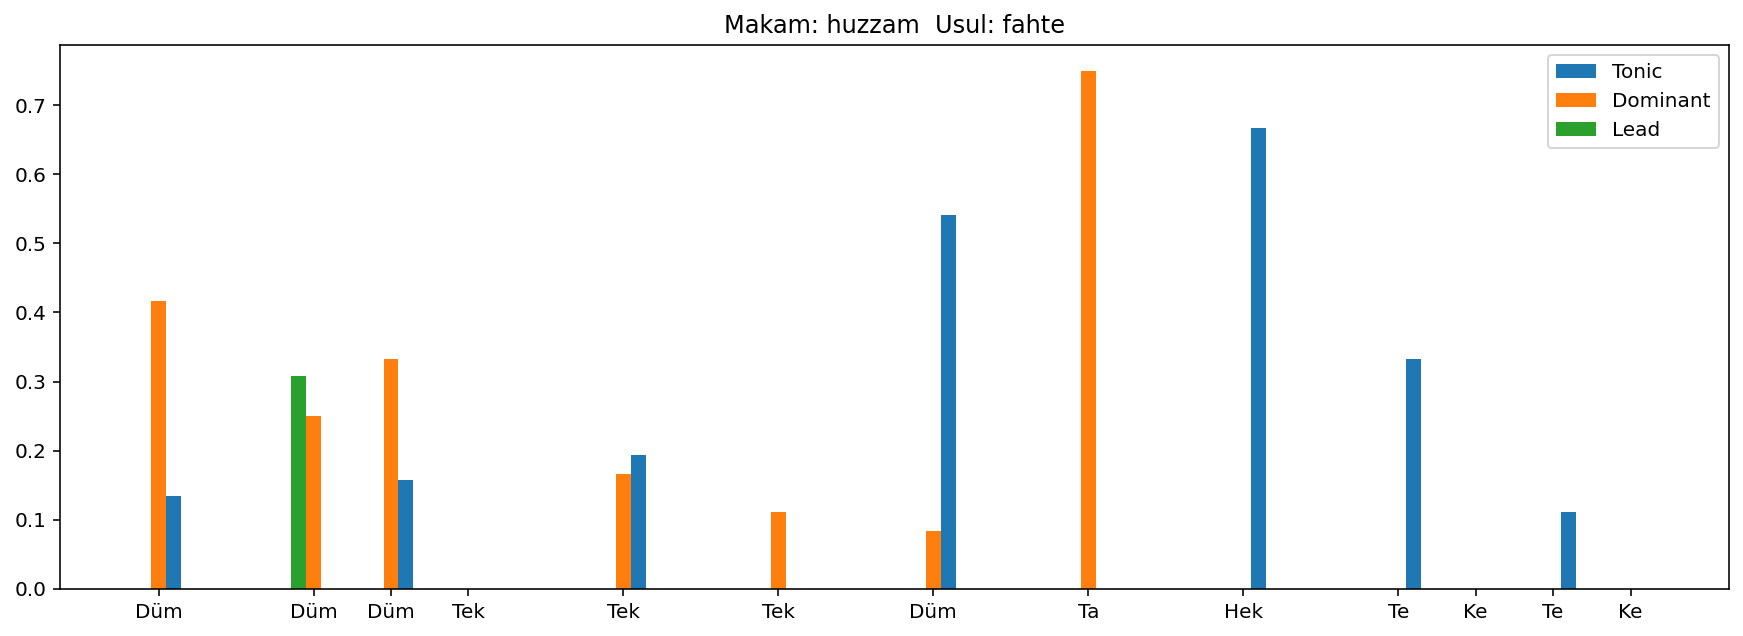

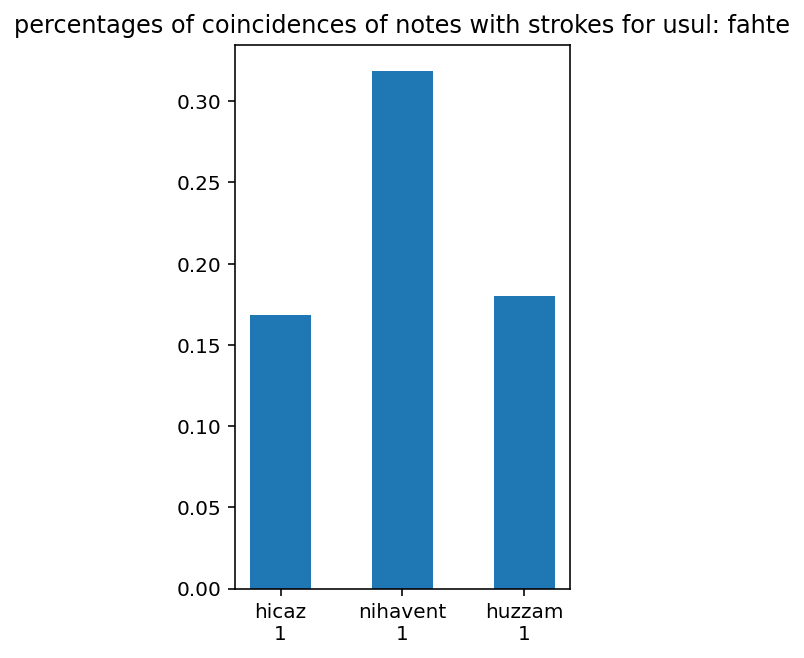

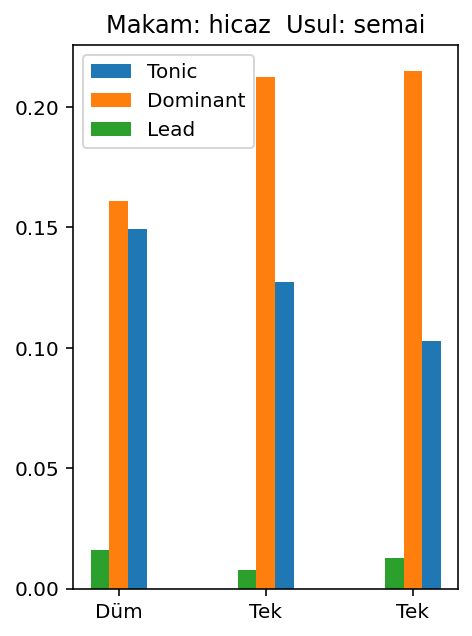

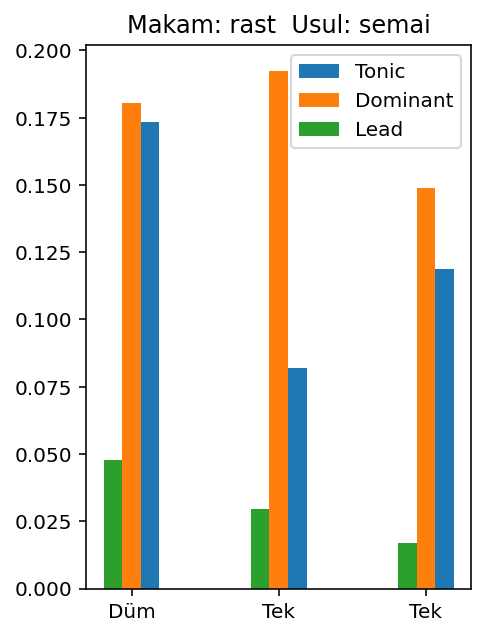

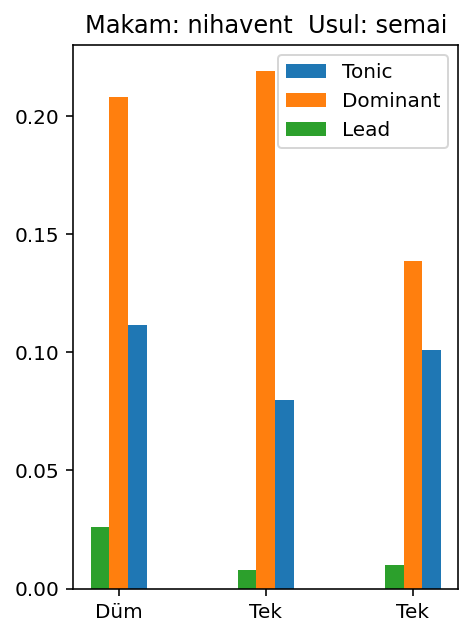

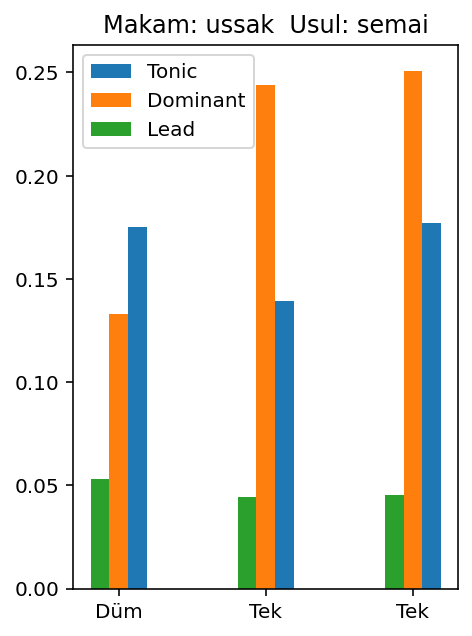

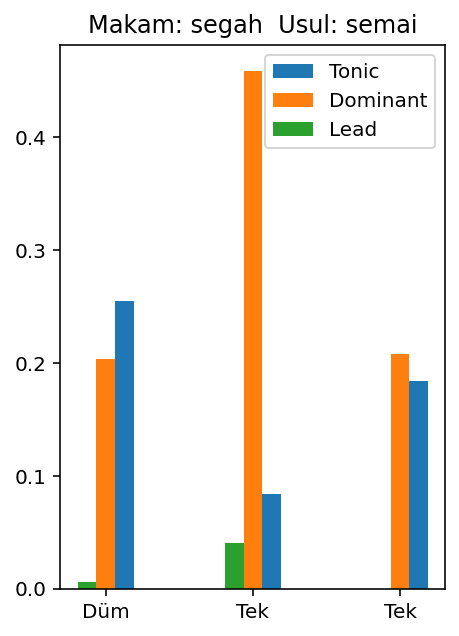

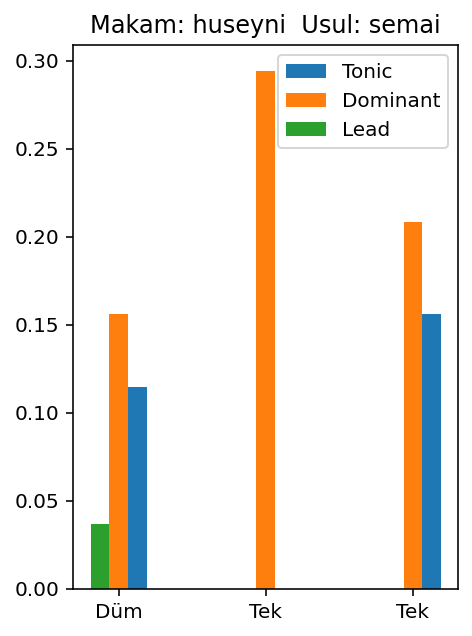

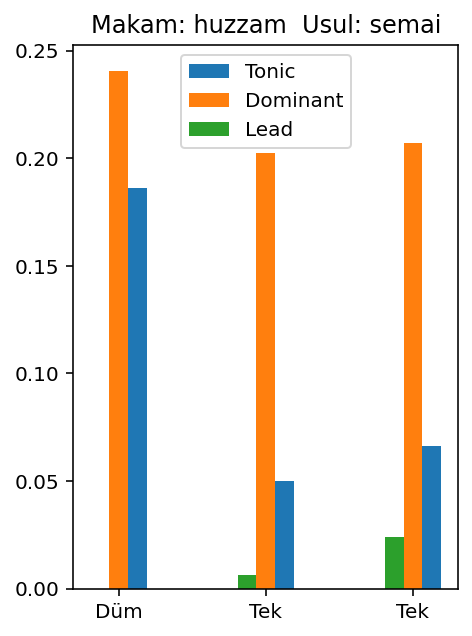

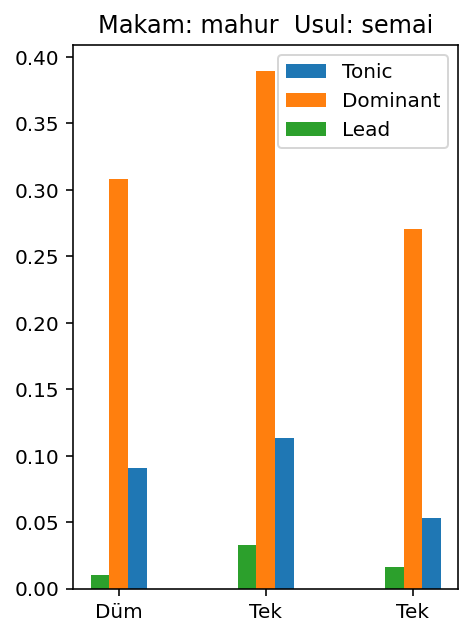

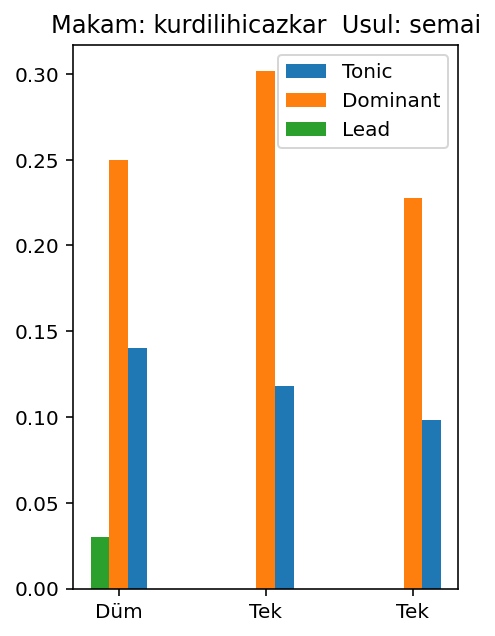

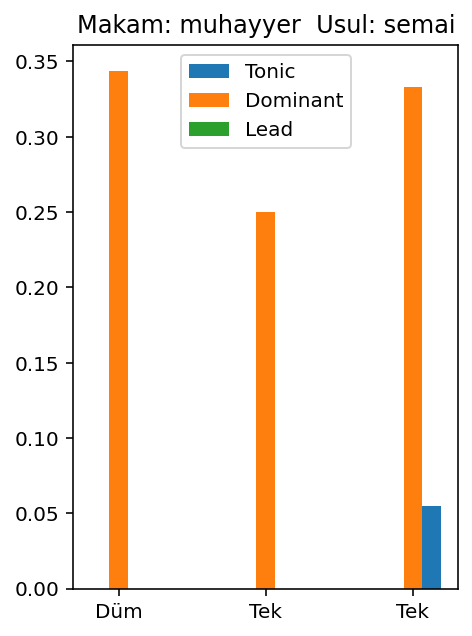

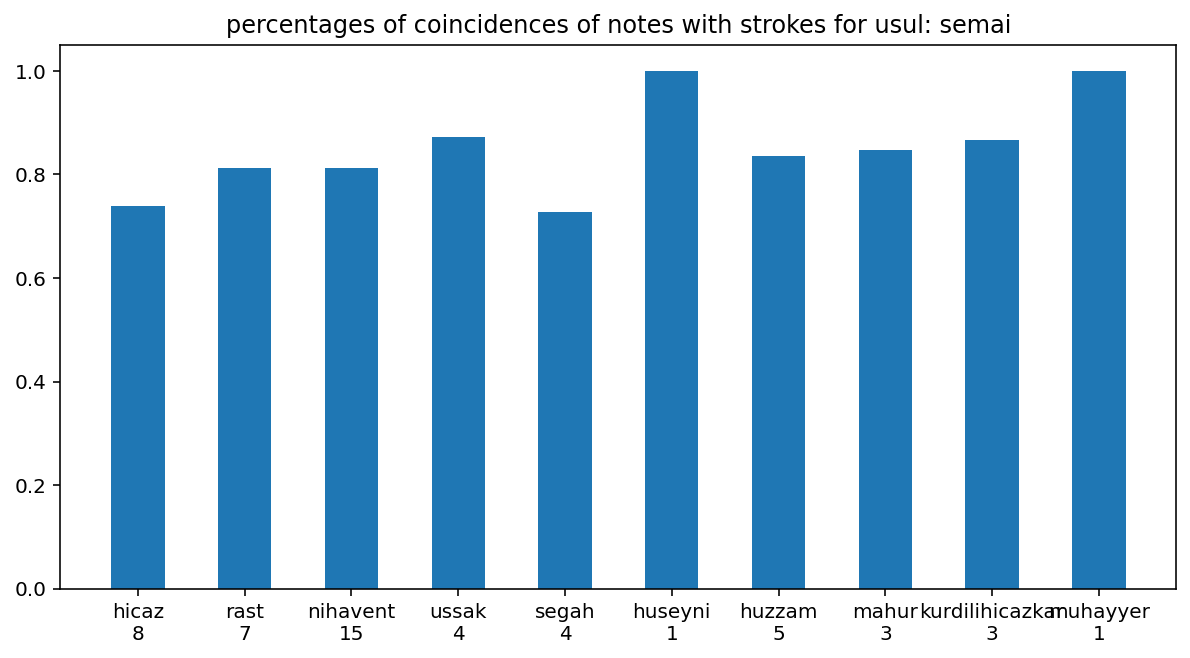

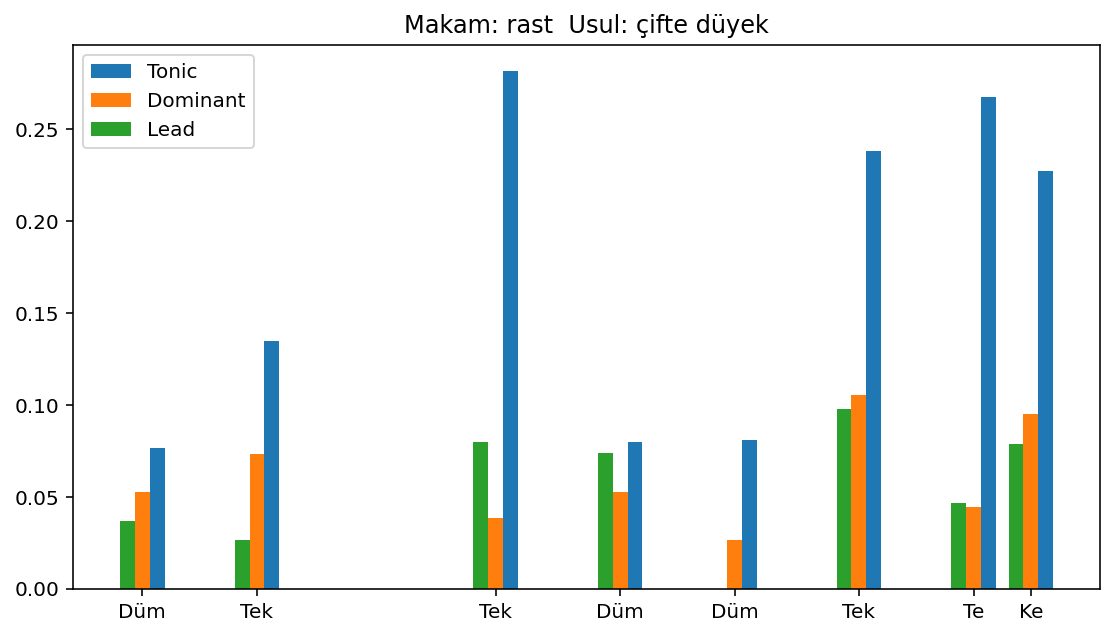

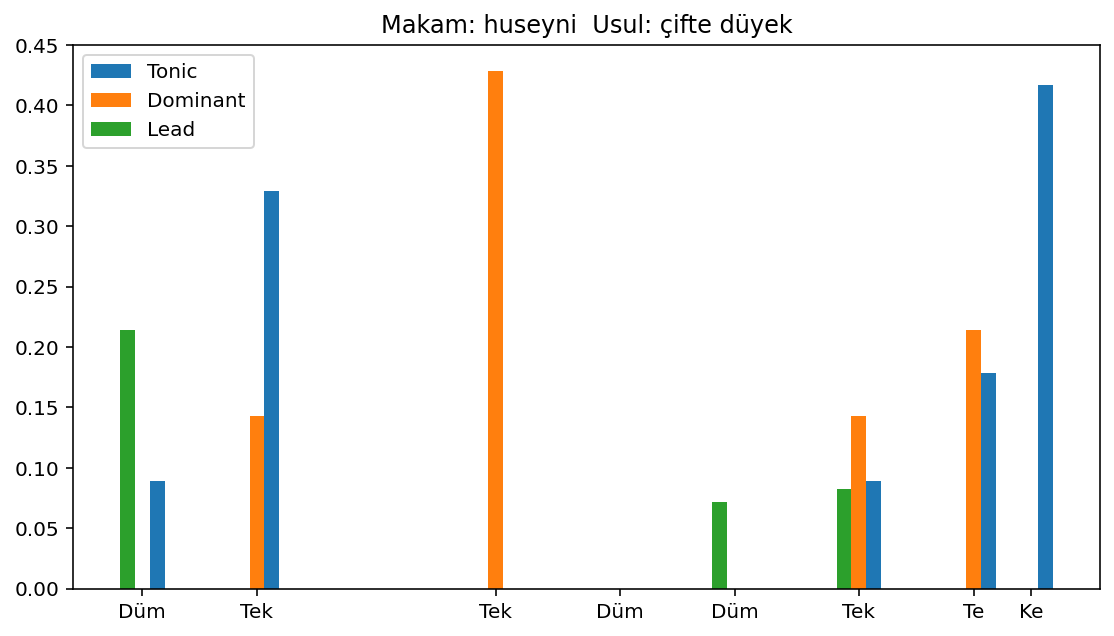

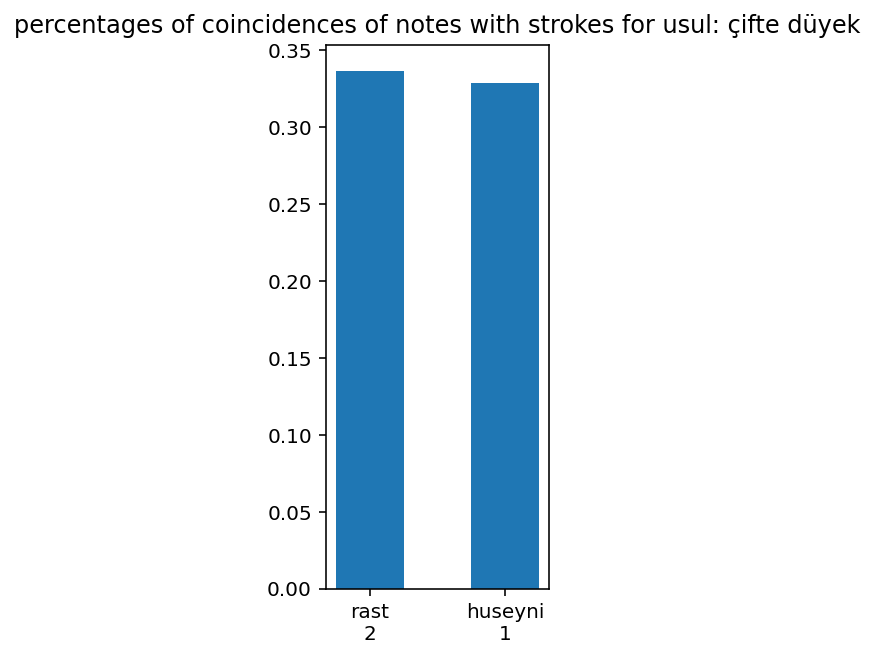

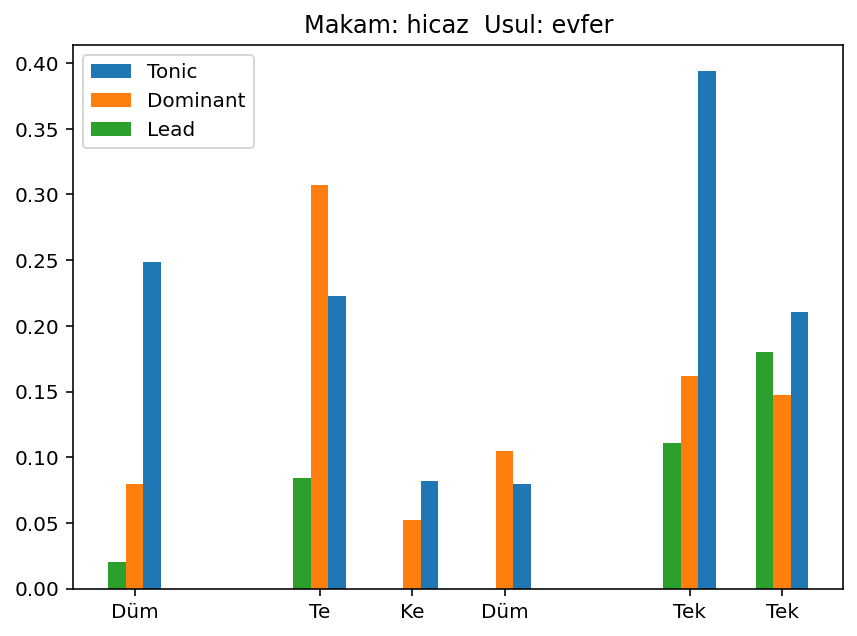

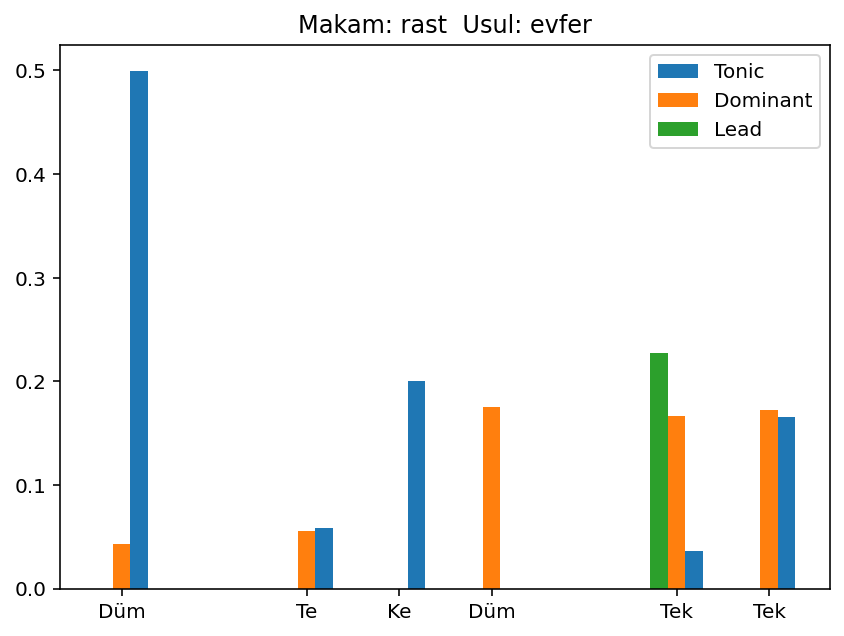

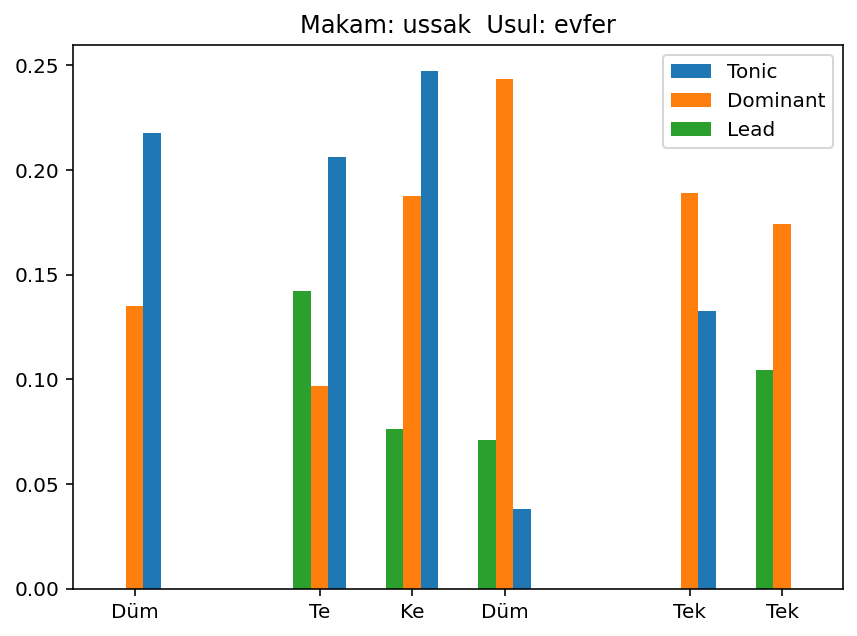

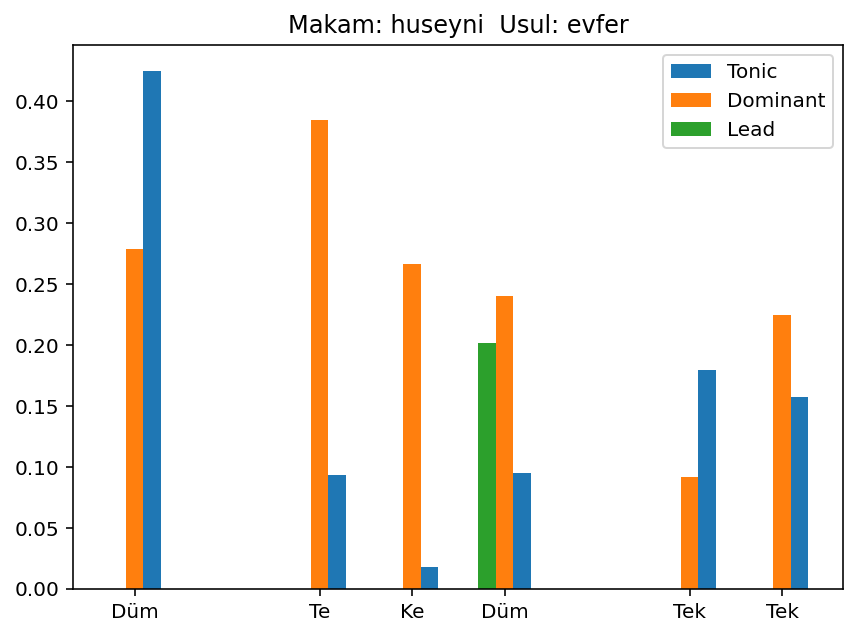

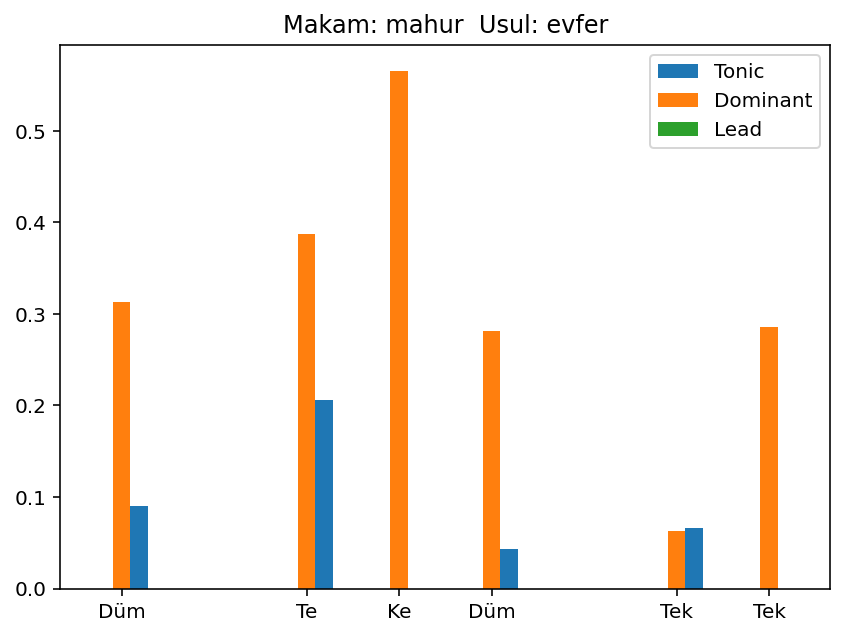

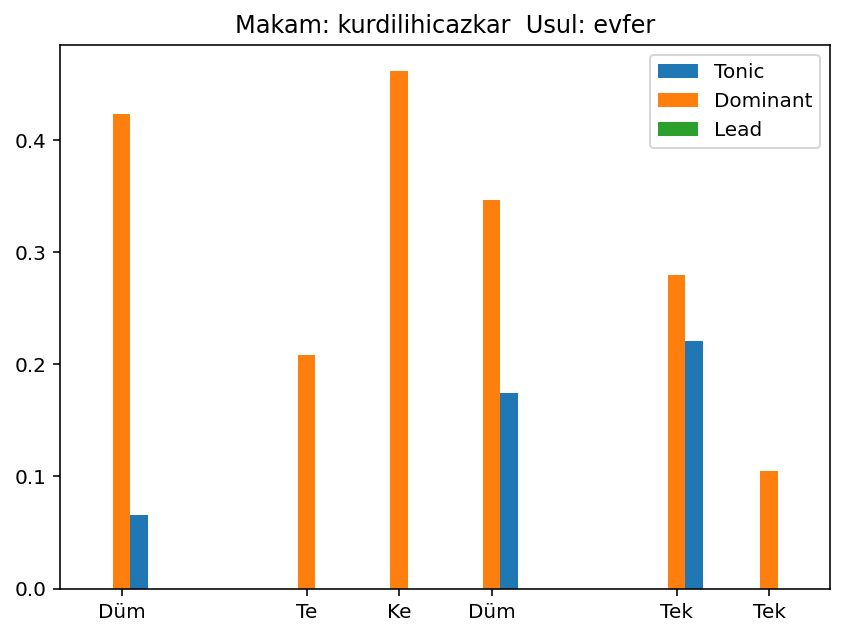

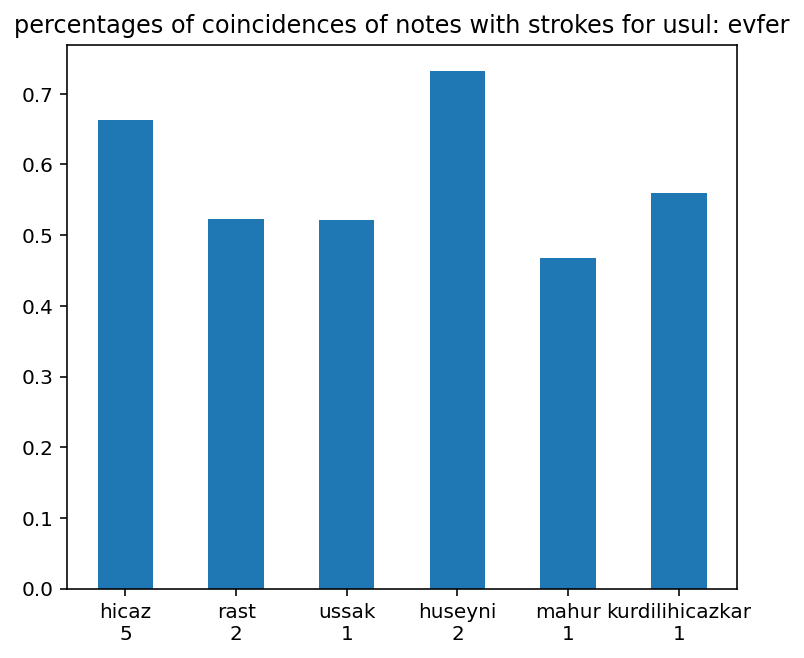

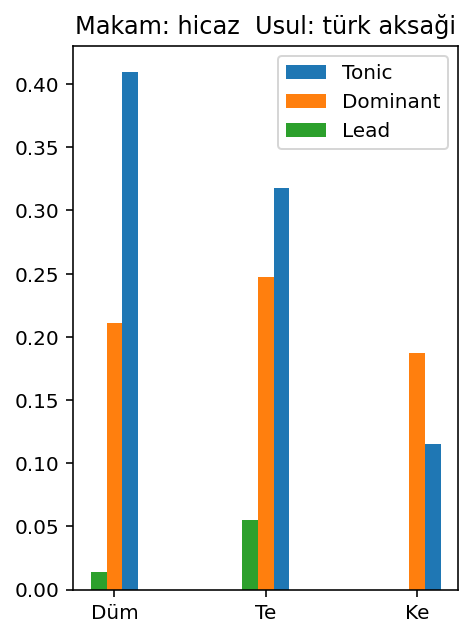

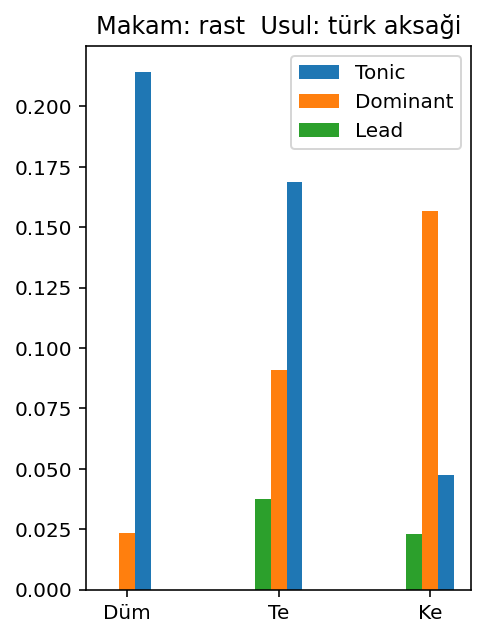

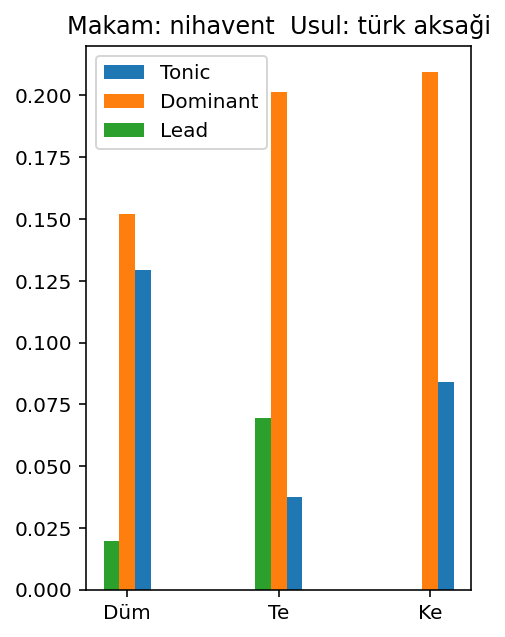

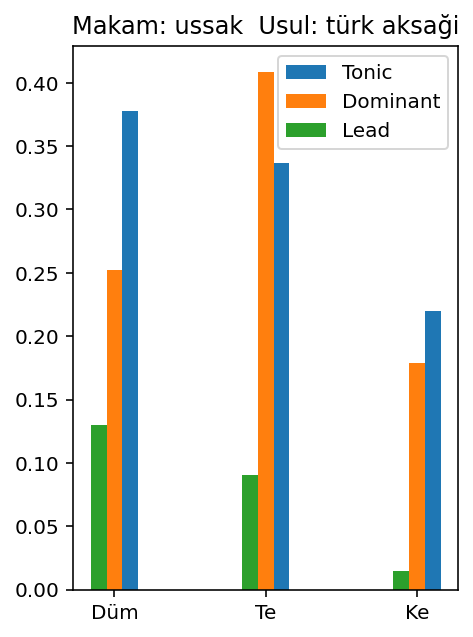

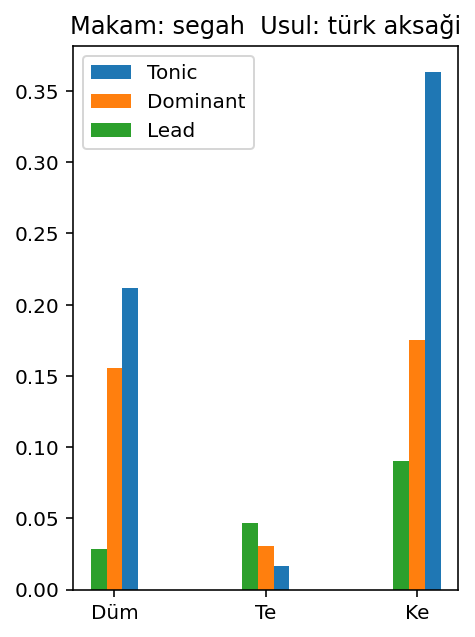

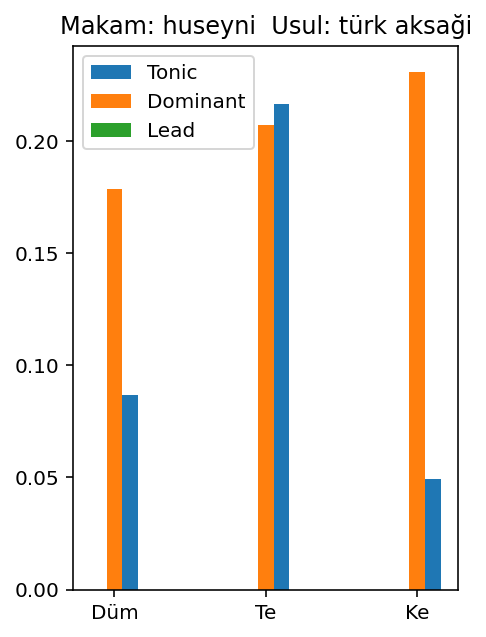

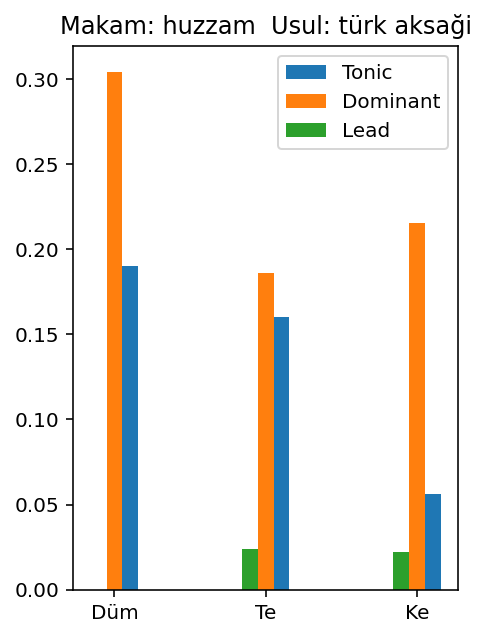

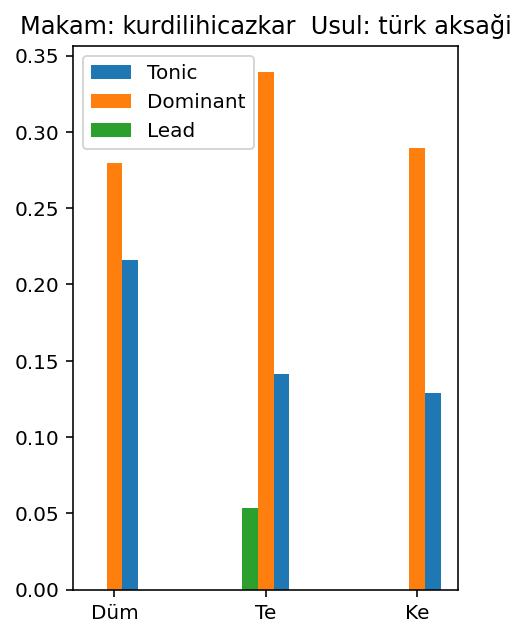

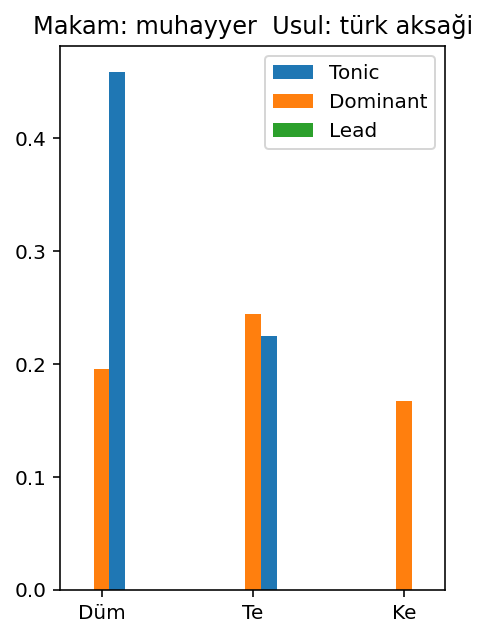

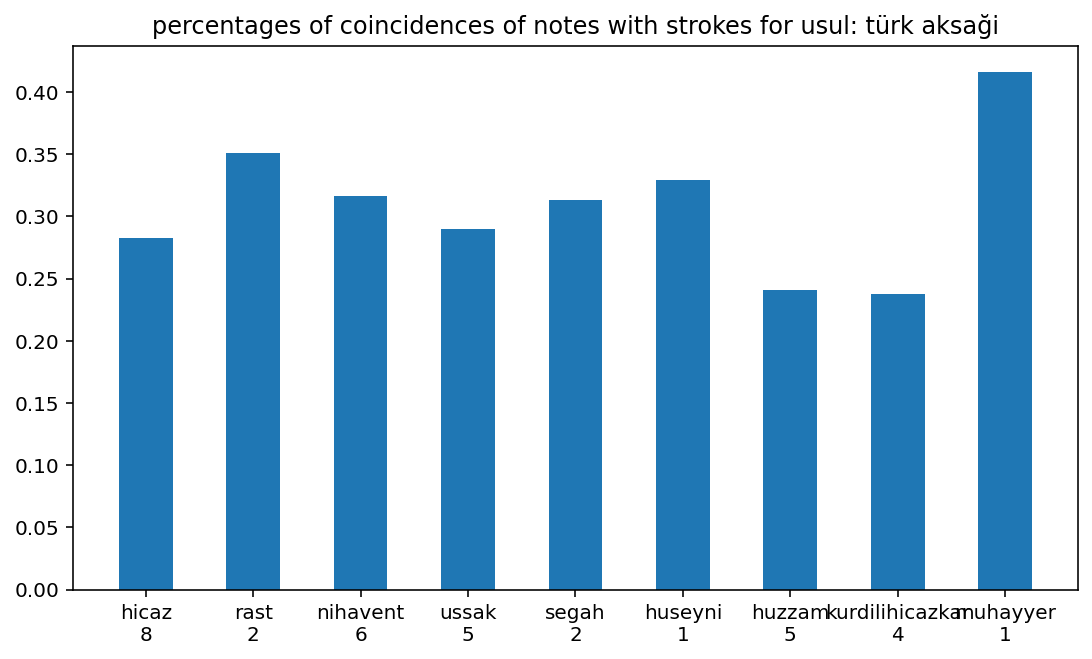

In [18]:
for usul_key in usuls_dict.keys():
  usul = usuls_dict[usul_key]
  usul_onsets = []
  stroke_names = []
  for stroke in usul:
    usul_onsets.append(stroke.compatoffset)
    stroke_names.append(stroke.stroketype)
  usul_onsets = np.asarray(usul_onsets)

  percentages = []
  makam_names= []
  for makam_key in makamdict.keys():
    try:
      coincidences, percentage, nPieces, not_coincide = analyze_makam(makam_key, usul_key)
    except ValueError:
      continue
    if not coincidences.empty:
      makam_name_count = makam_key + "\n" + str(nPieces)
      percentages.append(percentage)
      makam_names.append(makam_name_count)

      Dominant = np.zeros(usul_onsets.shape[0])
      Leading = np.zeros(usul_onsets.shape[0])
      Tonic = np.zeros(usul_onsets.shape[0])
      nan = np.zeros(usul_onsets.shape[0])

      grouped = coincidences.groupby(['note_significance','offset'])
      for g in grouped.groups:
        eval(str(g[0]))[np.where(usul_onsets==g[1])[0][0]] = len(grouped.groups[g])

      for i in range(usul_onsets.shape[0]):  # convert to percentages
        Dominant[i] /=  Dominant[i] + Leading[i] + Tonic[i] + nan[i]
        Leading[i] /=  Dominant[i] + Leading[i] + Tonic[i] + nan[i]
        Tonic[i] /=  Dominant[i] + Leading[i] + Tonic[i] + nan[i]
        nan[i] /=  Dominant[i] + Leading[i] + Tonic[i] + nan[i]

      
      width = 0.05/(0.4*usul_onsets.shape[0])
      fig , ax = plt.subplots(figsize=(1.15*usul_onsets.shape[0],5))

      rects1 = ax.bar(usul_onsets + width, Tonic, width, label='Tonic')
      rects2 = ax.bar(usul_onsets, Dominant, width, label='Dominant')
      rects3 = ax.bar(usul_onsets - width, Leading, width, label='Lead')

      ax.set_xticks(usul_onsets)
      ax.set_xticklabels(stroke_names)
      ax.set_title("Makam: %s  Usul: %s" % (makam_key,usul_key))
      ax.legend()

  fig , ax = plt.subplots(figsize=(len(makam_names),5)) # plotting percentages of coincidences of notes with strokes
  rects = ax.bar(makam_names,percentages,0.5)
  print("Average percentage of coincidence for usul %s is %f" %(usul_key,sum(percentages)/len(percentages)))
  ax.set_title("percentages of coincidences of notes with strokes for usul: %s" %usul_key)